In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy import stats
import datetime as dt
from datetime import timedelta
from sklearn.tree import DecisionTreeRegressor
from matplotlib.animation import FuncAnimation
import sys
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.formula.api as smf
import scipy.stats as stats


In [2]:
SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'

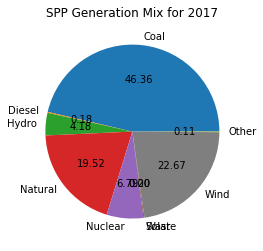

In [3]:
gen_mix = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2017.csv')

new = pd.DataFrame()

first = gen_mix.columns.values.tolist()[1].split(' ')[1]
new[first] = np.array([gen_mix[gen_mix.columns.values.tolist()[1]].sum()])
for element in gen_mix.columns.values.tolist()[2:]:
    if element.split(' ')[1] == first:
        new[first] = new[first] + np.array([gen_mix[element].sum()])
    else:
        new[element.split(' ')[1]] = np.array([gen_mix[element].sum()])
        first = element.split(' ')[1]

output = new.loc[0].values.tolist()[0:-1]
fuels = new.columns.values.tolist()[0:-1]

plt.pie(output,labels=fuels,autopct='%.2f')
plt.title('SPP Generation Mix for 2017')
plt.show()

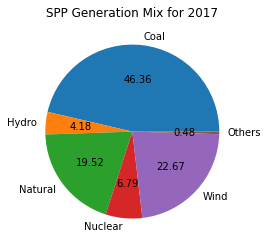

In [4]:
others = []
major_output = []
major_fuels = []
for i in range(len(output)):
    if output[i] < 10e7:
        others.append(output[i])
    else:
        major_output.append(output[i])
        major_fuels.append(fuels[i])
    
major_output.append(np.array(others).sum())
major_fuels.append('Others')

plt.pie(major_output,labels=major_fuels,autopct='%.2f')
plt.title('SPP Generation Mix for 2017')
plt.show()

In [5]:
def GMT2CT(s):
    date = s.split('T')[0]
    date = dt.datetime.strptime(date,'%Y-%m-%d').date()
    time = s.split('T')[1][:-1]
    hour = int(time.split(':')[0])
    if hour >= 6:
        hour = hour - 6
    else:
        hour = 24 + (hour - 6)
        date = date - timedelta(1)
    time = str(hour) + ':' + time.split(':')[1] + ':' + time.split(':')[2]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    return [date, time]


In [6]:
list_intervals = gen_mix[gen_mix.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix['Local Date'] = np.array(local_date)
gen_mix['Local Time'] = np.array(local_time)

In [7]:
gen_mix.head()

GMT MKT Interval   Coal Market   Coal Self   Diesel Fuel Oil   Hydro  \
0  2017-01-01T06:00:00Z        2956.2     13385.3               0.0   251.8   
1  2017-01-01T06:05:00Z        2920.2     13342.3               0.0   241.7   
2  2017-01-01T06:10:00Z        2920.2     13254.2               0.0   241.7   
3  2017-01-01T06:15:00Z        2923.2     13380.3               0.0   267.6   
4  2017-01-01T06:20:00Z        2900.3     13388.1               0.0   276.7   

    Natural Gas   Nuclear   Solar   Waste Disposal Services    Wind  \
0        3025.9    2098.4     0.0                       7.7  4499.1   
1        2988.6    2100.8     0.0                       8.1  4529.3   
2        2969.2    2100.8     0.0                       8.1  4529.3   
3        2981.2    2099.1     0.0                       8.1  4551.8   
4        2960.1    2099.8     0.0                       8.7  4603.1   

    Waste Heat   Other   Average Actual Load  Local Date Local Time  
0          0.0    35.4             25380.548  2017-01-01   00:00:00  
1          0.0    35.7             25356.102  2017-01-01   00:05:00  
2          0.0    35.7             25356.102  2017-01-01   00:10:00  
3          0.0    35.7             25358.945  2017-01-01   00:15:00  
4          0.0    36.4             25345.252  2017-01-01   00:20:00

<ErrorbarContainer object of 3 artists>

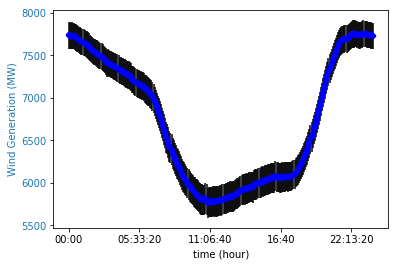

In [8]:
data1 = gen_mix.groupby('Local Time')[[' Wind']].mean()

data1['sem'] = gen_mix.groupby('Local Time')[[' Wind']].sem()

time = data1.index

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (hour)')
ax1.set_ylabel('Wind Generation (MW)', color=color)
ax1.plot(time, data1[' Wind'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.errorbar(time,data1[' Wind'], data1['sem'],
                 marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)

##### DA-RT for 2017

In [9]:
DA = pd.read_csv(r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2017\2017\LMP_SL_2017.csv')
DA.head()

INTERVAL              GMTINTERVALEND  STLMNTLOCNAME  \
0  2017-01-01 01:00:00.000000  2017-01-01 07:00:00.000000            AEC   
1  2017-01-01 01:00:00.000000  2017-01-01 07:00:00.000000      AECC_CSWS   
2  2017-01-01 01:00:00.000000  2017-01-01 07:00:00.000000    AECC_ELKINS   
3  2017-01-01 01:00:00.000000  2017-01-01 07:00:00.000000  AECC_FITZHUGH   
4  2017-01-01 01:00:00.000000  2017-01-01 07:00:00.000000  AECC_FLTCREEK   

                     PNODENAME      LMP     MLC     MCC      MEC  
0                         SOUC  23.6810  0.2235 -0.0405  23.4980  
1                 CSWS_AECC_LA  24.7412  0.8705  0.3727  23.4980  
2        CSWSELKINSUNELKINS_RA  25.4095  1.1575  0.7541  23.4979  
3             CSWSFITZHUGHPLT1  25.2253  1.0222  0.7052  23.4979  
4  CSWSFLINTCRKUN1_JOU_AECC_RA  24.7430  0.5142  0.7309  23.4979

In [10]:
#DA2 = pd.read_csv(SPP_path + '\\DA\\2017\\2017\\LMP_SL_2017.csv')

    Iterates through every location (more granular, but slower)
DA_intervals = DA[DA.columns[0]].values.tolist()
DA_dates = []
DA_hours = []
for interval in DA_intervals:
    date = interval.split(' ')[0]
    DA_dates.append(dt.datetime.strptime(date,'%Y-%m-%d').date())
    hour = interval.split(' ')[1].split('.')[0]
    DA_hours.append(dt.datetime.strptime(hour,'%H:%M:%S').time())
DA['Local Date'] = np.array(DA_dates)
DA['Local Time'] = np.array(DA_hours)
DA.tail()

In [11]:
# Aggregate locations
DA_aggloc = DA.groupby('GMTINTERVALEND')[['INTERVAL','LMP']].agg({'INTERVAL':'first',
                                                                  'LMP':'mean'})
DA_aggloc['loc sem'] = DA.groupby('GMTINTERVALEND')[['LMP']].sem()

In [12]:
DA_intervals = DA_aggloc[DA_aggloc.columns[0]].values.tolist()
DA_dates = []
DA_times = []
weekday = []
for interval in DA_intervals:
    date = interval.split(' ')[0]
    date = dt.datetime.strptime(date,'%Y-%m-%d').date()
    DA_dates.append(date)
    if date.weekday() < 5:
        weekday.append(True)
    else:
        weekday.append(False)
    time = interval.split(' ')[1].split('.')[0]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    DA_times.append(time)
DA_aggloc['Local Date'] = np.array(DA_dates)
DA_aggloc['Local Time'] = np.array(DA_times)
DA_aggloc['Weekday'] = np.array(weekday)
DA_aggloc.tail()

INTERVAL        LMP   loc sem  \
GMTINTERVALEND                                                                
2018-01-01 02:00:00.000000  2017-12-31 20:00:00.000000  44.376063  0.164322   
2018-01-01 03:00:00.000000  2017-12-31 21:00:00.000000  43.884059  0.210470   
2018-01-01 04:00:00.000000  2017-12-31 22:00:00.000000  41.137268  0.174956   
2018-01-01 05:00:00.000000  2017-12-31 23:00:00.000000  43.236809  0.213430   
2018-01-01 06:00:00.000000  2018-01-01 00:00:00.000000  34.699045  0.182230   

                            Local Date Local Time  Weekday  
GMTINTERVALEND                                              
2018-01-01 02:00:00.000000  2017-12-31   20:00:00    False  
2018-01-01 03:00:00.000000  2017-12-31   21:00:00    False  
2018-01-01 04:00:00.000000  2017-12-31   22:00:00    False  
2018-01-01 05:00:00.000000  2017-12-31   23:00:00    False  
2018-01-01 06:00:00.000000  2018-01-01   00:00:00     True

In [13]:
DA_price = DA_aggloc.groupby('Local Time')[['LMP']].mean()
DA_price['time sem'] = DA_aggloc.groupby('Local Time')[['LMP']].sem()
time_x = DA_price.index

plt.plot(time_x,DA_price['LMP'],label='Mean DA')
plt.xlabel('Hour')
plt.ylabel('DA')
plt.title('Average DA price by hour in 2017')
plt.legend(loc='best')
plt.errorbar(time_x,DA_price['LMP'], DA_price['time sem'],
             marker='x', ecolor='black',mec='red', linestyle='None',ms=4, mew=4)


<ErrorbarContainer object of 3 artists>

In [14]:
def plot_dfs(df1, df2):
    
    data1 = df1.groupby('Local Time')[[' Wind']].mean()
    data2 = df2.groupby('Local Time')[['LMP']].mean()

    data1['sem'] = df1.groupby('Local Time')[[' Wind']].sem()
    data2['sem'] = df2.groupby('Local Time')[['LMP']].sem()

    time = data1.index

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (hour)')
    ax1.set_ylabel('Wind Generation (MW)', color=color)
    ax1.plot(time, data1[' Wind'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.errorbar(time,data1[' Wind'], data1['sem'],
                     marker='x', ecolor='black',mec='red', linestyle='None',ms=4, mew=4, label=None)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    time = data2.index
    
    color = 'tab:blue'
    ax2.set_ylabel('Price ($/MW)', color=color)  # we already handled the x-label with ax1
    ax2.plot(time, data2['LMP'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.errorbar(time,data2['LMP'], data2['sem'],
                     marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

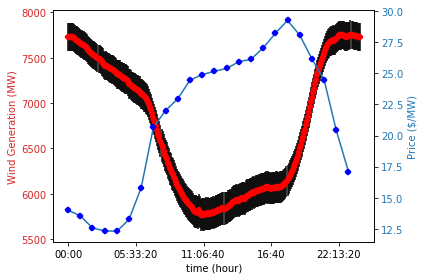

In [15]:
plot_dfs(gen_mix, DA_price)

In [16]:
def plot_dfs_seasons(gen, price, year):
    
    equinox1 = dt.datetime.strptime(year+'-03-21','%Y-%m-%d').date()
    solstice1 = dt.datetime.strptime(year+'-06-21','%Y-%m-%d').date()
    equinox2 = dt.datetime.strptime(year+'-09-21','%Y-%m-%d').date()
    solstice2 = dt.datetime.strptime(year+'-12-21','%Y-%m-%d').date()
    
    winter_price = price[(price['Local Date']<=equinox1)]
    spring_price = price[(price['Local Date']>=equinox1) & (price['Local Date']<=solstice1)]
    summer_price = price[(price['Local Date']>=solstice1) & (price['Local Date']<=equinox2)]
    fall_price = price[(price['Local Date']>=equinox2)]

    winter_gen = gen[(gen['Local Date']<=equinox1)]
    spring_gen = gen[(gen['Local Date']>=equinox1) & (gen['Local Date']<=solstice1)]
    summer_gen = gen[(gen['Local Date']>=solstice1) & (gen['Local Date']<=equinox2)]
    fall_gen = gen[(gen['Local Date']>=equinox2)]

    seasons_dict = {'Winter':[winter_price, winter_gen],
                    'Spring':[spring_price, spring_gen],
                    'Summer':[summer_price, summer_gen],
                    'Fall':[fall_price, fall_gen]
                   }

    for season, data in seasons_dict.items():

        data1 = data[1].groupby('Local Time')[[' Wind']].mean()
        data2 = data[0].groupby('Local Time')[['LMP']].mean()

        time = data1.index
        
        data1['sem'] = gen.groupby('Local Time')[[' Wind']].sem()
        data2['sem'] = price.groupby('Local Time')[['LMP']].sem()

        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('time (hour)')
        ax1.set_ylabel('Wind Generation (MW)', color=color)
        ax1.plot(time, data1[' Wind'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.errorbar(time,data1[' Wind'], data1['sem'],
                         marker='x', ecolor='black',mec='red', linestyle='None',ms=4, mew=4, label=None)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        time = data2.index
        
        color = 'tab:blue'
        ax2.set_ylabel('Price ($/MW)', color=color)  # we already handled the x-label with ax1
        ax2.plot(time, data2['LMP'], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.errorbar(time,data2['LMP'], data2['sem'],
                         marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)


        plt.title(season)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

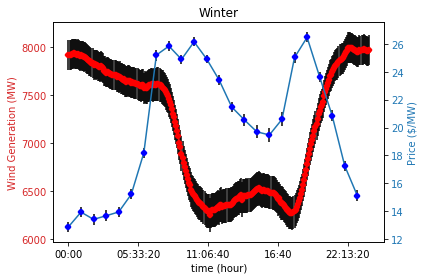

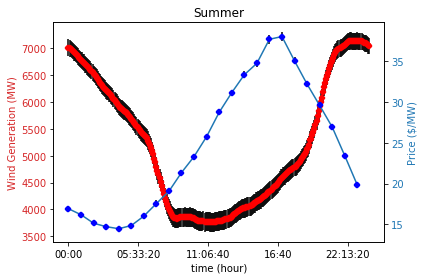

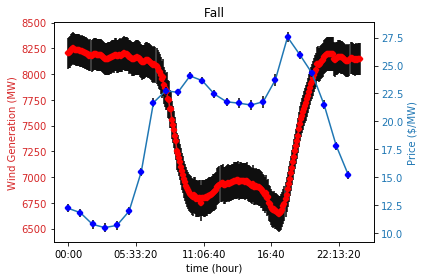

In [17]:
plot_dfs_seasons(gen_mix, DA_aggloc, '2017')

In [18]:
timespan = [str(d) for d in DA_price.index.values.tolist()]
minutes = []
for t in timespan:
    minutes.append(int(t.split(':')[0])*60)
DA_price['Minutes'] = np.array(minutes)
DA_price.head()

LMP  time sem  Minutes
Local Time                              
00:00:00    14.004104  0.360668        0
01:00:00    13.572501  0.361794       60
02:00:00    12.587807  0.373007      120
03:00:00    12.354799  0.379655      180
04:00:00    12.323302  0.381407      240

In [19]:
dict_ssr = {}

for i in range(24):
    try:
        x_avg = (DA_price['Minutes'][i]+DA_price['Minutes'][i+1])/2
        y_avg1 = DA_price['LMP'][0:i+1].values.mean()
        y_avg2 = DA_price['LMP'][i:].values.mean()
        ssr = ((DA_price['LMP'][0:i+1].values - y_avg1)**2).sum() + ((DA_price['LMP'][i:].values - y_avg2)**2).sum()
        dict_ssr[i] = ssr
    except:
        y_avg1 = DA_price['LMP'].values.mean()
        ssr = ((DA_price['LMP'][0:i+1].values - y_avg1)**2).sum()
        dict_ssr[i] = ssr
        
ssr_min = np.array(list(dict_ssr.values())).min()
#np.where(np.array(list(dict_ssr.values()))==ssr_min,1,0).loc

In [20]:
smallest_x = 0
smallest_y = 0
for i in range(24):
    try:
        y_avg1 = DA_price['LMP'][0:i+1].values.mean()
        y_avg2 = DA_price['LMP'][i:].values.mean()
        ssr = ((DA_price['LMP'][0:i+1].values - y_avg1)**2).sum() + ((DA_price['LMP'][i:].values - y_avg2)**2).sum()
        if i == 0:
            smallest_y = ssr
        else:
            if ssr < smallest_y:
                smallest_y = ssr
                smallest_x = i
    except:
        y_avg1 = DA_price['LMP'].values.mean()
        ssr = ((DA_price['LMP'][0:i+1].values - y_avg1)**2).sum()
        if ssr < smallest_y:
                smallest_y = ssr
                smallest_x = i
smallest_x

7

In [21]:
def ssr_split(df):
    smallest_y = 0
    smallest_x = 0
    for i in range(0, df.shape[0]):
        try:
            y_avg1 = df['LMP'][0:i+1].values.mean()
            y_avg2 = df['LMP'][i:df.shape[0]].values.mean()
            ssr = ((df['LMP'][0:i+1].values - y_avg1)**2).sum() + ((df['LMP'][i:df.shape[0]].values - y_avg2)**2).sum()
            if i == 0:
                smallest_y = ssr
            if ssr < smallest_y:
                smallest_y = ssr
                smallest_x = i
        except:
            y_avg1 = df['LMP'].values.mean()
            ssr = ((df['LMP'][0:i+1].values - y_avg1)**2).sum()
            if ssr < smallest_y:
                smallest_y = ssr
                smallest_x = i
    return [df.iloc[0:smallest_x+1],df.iloc[smallest_x+1:]]

In [22]:
split = ssr_split(DA_price)
split[0]

LMP  time sem  Minutes
Local Time                              
00:00:00    14.004104  0.360668        0
01:00:00    13.572501  0.361794       60
02:00:00    12.587807  0.373007      120
03:00:00    12.354799  0.379655      180
04:00:00    12.323302  0.381407      240
05:00:00    13.266328  0.369283      300
06:00:00    15.823157  0.349744      360
07:00:00    20.648623  0.395752      420

In [23]:
def ssr_split(df):
    if df.shape[0]>6:
        smallest_y = 0
        smallest_x = 0
        for i in range(0, df.shape[0]):
            try:
                y_avg1 = df['LMP'][0:i+1].values.mean()
                y_avg2 = df['LMP'][i:df.shape[0]].values.mean()
                ssr = ((df['LMP'][0:i+1].values - y_avg1)**2).sum() + ((df['LMP'][i:df.shape[0]].values - y_avg2)**2).sum()
                if i == 0:
                    smallest_y = ssr
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
            except:
                y_avg1 = df['LMP'].values.mean()
                ssr = ((df['LMP'][0:i+1].values - y_avg1)**2).sum()
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
        return [df.iloc[0:smallest_x+1],df.iloc[smallest_x+1:]]
    else:
        return df

In [24]:
manual_split = [ssr_split(DA_price)[0]] + ssr_split(ssr_split(ssr_split(DA_price)[1])[0]) + [ssr_split(ssr_split(DA_price)[1])[1]]

In [25]:
for i in range(len(manual_split)):
    print(manual_split[i]['LMP'].mean())


14.322577477209855
24.132254132536573
26.892553924522957
18.758628700759292


In [26]:
## work on recursive algorithm

#df = DA_price
#splits = []
#while ssr_split(df) != False:
#    splits = ssr_split(df)
#    df = ssr_split(df)[0]
    

In [27]:
# Opening and concatenating DA datasets
days_30 = []
for n in range(1,10):
    days_30.append('0'+str(n))
for n in range(10,31):
    days_30.append(str(n))
days_31 = days_30 + ['31']
cal_dict = {'01':days_31,
           '04':days_30,
           '07':days_31,
           '10':days_31}
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2019'
DA_path = 'DA-LMP-SL-2019'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\'+DA_path+key+value+end))
DA = pd.concat(dfs)
DA.head()

Interval       GMTIntervalEnd Settlement Location  \
0  01/01/2019 01:00:00  01/01/2019 07:00:00                 AEC   
1  01/01/2019 01:00:00  01/01/2019 07:00:00           AECC_CSWS   
2  01/01/2019 01:00:00  01/01/2019 07:00:00         AECC_ELKINS   
3  01/01/2019 01:00:00  01/01/2019 07:00:00       AECC_FITZHUGH   
4  01/01/2019 01:00:00  01/01/2019 07:00:00       AECC_FLTCREEK   

                         Pnode      LMP     MLC     MCC      MEC  
0                         SOUC  19.7410  0.6601  1.8215  17.2594  
1                 CSWS_AECC_LA  21.6101  0.6941  3.6566  17.2594  
2        CSWSELKINSUNELKINS_RA  22.1668  0.4265  4.4809  17.2594  
3             CSWSFITZHUGHPLT1  21.4401  0.9387  3.2420  17.2594  
4  CSWSFLINTCRKUN1_JOU_AECC_RA  21.9882  0.1084  4.6204  17.2594

In [28]:
# Opening and concatenating RT datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\RT\2019'
RT_path = 'RTBM-LMP-DAILY-SL-2019'
end = '.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\'+RT_path+key+value+end))
RT = pd.concat(dfs)
RT.head()

Interval         GMT Interval  Settlement Location Name  \
0  01/01/2019 00:05:00  01/01/2019 06:05:00                       AEC   
1  01/01/2019 00:05:00  01/01/2019 06:05:00                 AECC_CSWS   
2  01/01/2019 00:05:00  01/01/2019 06:05:00               AECC_ELKINS   
3  01/01/2019 00:05:00  01/01/2019 06:05:00             AECC_FITZHUGH   
4  01/01/2019 00:05:00  01/01/2019 06:05:00             AECC_FLTCREEK   

                    PNODE Name      LMP     MLC      MCC     MEC  
0                         SOUC  29.0316  0.1671  25.8830  2.9815  
1                 CSWS_AECC_LA  27.0062  0.1091  23.9156  2.9815  
2        CSWSELKINSUNELKINS_RA  17.4872  0.0613  14.4444  2.9815  
3             CSWSFITZHUGHPLT1  21.9942  0.1735  18.8392  2.9815  
4  CSWSFLINTCRKUN1_JOU_AECC_RA  17.9800  0.0134  14.9851  2.9815

In [29]:
# Groups by interval (hour) and takes mean of locations

DA_aggloc = DA.groupby('GMTIntervalEnd')[['Interval','LMP']].agg({'Interval':'first',
                                                                  'LMP':'mean'})
DA_aggloc['loc sem'] = DA.groupby('GMTIntervalEnd')[['LMP']].sem()

DA_aggloc.head()

Interval        LMP   loc sem
GMTIntervalEnd                                               
01/01/2019 07:00:00  01/01/2019 01:00:00  15.926744  0.209225
01/01/2019 08:00:00  01/01/2019 02:00:00  15.493855  0.206428
01/01/2019 09:00:00  01/01/2019 03:00:00  15.607973  0.198752
01/01/2019 10:00:00  01/01/2019 04:00:00  16.196642  0.161243
01/01/2019 11:00:00  01/01/2019 05:00:00  18.510701  0.118942

In [30]:
# Groups by interval (5-min) and takes mean of locations

RT_aggloc = RT.groupby(' GMT Interval')[['Interval',' LMP']].agg({'Interval':'first',
                                                                  ' LMP':'mean'})
RT_aggloc['loc sem'] = RT.groupby(' GMT Interval')[[' LMP']].sem()

RT_aggloc.head()

Interval       LMP   loc sem
 GMT Interval                                               
01/01/2019 06:05:00  01/01/2019 00:05:00  0.250149  0.729346
01/01/2019 06:10:00  01/01/2019 00:10:00 -7.802782  0.445401
01/01/2019 06:15:00  01/01/2019 00:15:00  2.905577  0.484422
01/01/2019 06:20:00  01/01/2019 00:20:00  3.350695  0.190441
01/01/2019 06:25:00  01/01/2019 00:25:00 -2.253530  0.353375

In [31]:
comparison = DA_aggloc.join(RT_aggloc,how='right',lsuffix='_DA',rsuffix='_RT')
comparison.head()

Interval_DA  LMP  loc sem_DA          Interval_RT  \
 GMT Interval                                                           
01/01/2019 06:05:00         NaN  NaN         NaN  01/01/2019 00:05:00   
01/01/2019 06:10:00         NaN  NaN         NaN  01/01/2019 00:10:00   
01/01/2019 06:15:00         NaN  NaN         NaN  01/01/2019 00:15:00   
01/01/2019 06:20:00         NaN  NaN         NaN  01/01/2019 00:20:00   
01/01/2019 06:25:00         NaN  NaN         NaN  01/01/2019 00:25:00   

                          LMP  loc sem_RT  
 GMT Interval                              
01/01/2019 06:05:00  0.250149    0.729346  
01/01/2019 06:10:00 -7.802782    0.445401  
01/01/2019 06:15:00  2.905577    0.484422  
01/01/2019 06:20:00  3.350695    0.190441  
01/01/2019 06:25:00 -2.253530    0.353375

In [32]:
comparison = comparison.rename(columns={comparison.columns[1]:'LMP_DA',
                                       comparison.columns[4]:'LMP_RT'})
comparison.head()

Interval_DA  LMP_DA  loc sem_DA          Interval_RT  \
 GMT Interval                                                              
01/01/2019 06:05:00         NaN     NaN         NaN  01/01/2019 00:05:00   
01/01/2019 06:10:00         NaN     NaN         NaN  01/01/2019 00:10:00   
01/01/2019 06:15:00         NaN     NaN         NaN  01/01/2019 00:15:00   
01/01/2019 06:20:00         NaN     NaN         NaN  01/01/2019 00:20:00   
01/01/2019 06:25:00         NaN     NaN         NaN  01/01/2019 00:25:00   

                       LMP_RT  loc sem_RT  
 GMT Interval                              
01/01/2019 06:05:00  0.250149    0.729346  
01/01/2019 06:10:00 -7.802782    0.445401  
01/01/2019 06:15:00  2.905577    0.484422  
01/01/2019 06:20:00  3.350695    0.190441  
01/01/2019 06:25:00 -2.253530    0.353375

In [33]:
# Fills DA blanks and returns new df with less info

def filler_short(df, DA, RT):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    new_df = pd.DataFrame()
    new_df[DA] = np.array(new_list)
    new_df[RT] = df[RT].values
    return new_df

In [34]:
# Fills DA blanks

def filler(df, DA):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    df[DA] = np.array(new_list)
    return df

In [35]:
filled = filler(comparison, 'LMP_DA')
filled.tail()

Interval_DA     LMP_DA  loc sem_DA  \
 GMT Interval                                                     
11/01/2019 04:40:00                  NaN  15.361160         NaN   
11/01/2019 04:45:00                  NaN  15.361160         NaN   
11/01/2019 04:50:00                  NaN  15.361160         NaN   
11/01/2019 04:55:00                  NaN  15.361160         NaN   
11/01/2019 05:00:00  11/01/2019 00:00:00  13.003898    0.359167   

                             Interval_RT     LMP_RT  loc sem_RT  
 GMT Interval                                                    
11/01/2019 04:40:00  10/31/2019 23:40:00  14.375957    1.003117  
11/01/2019 04:45:00  10/31/2019 23:45:00   9.699994    0.285358  
11/01/2019 04:50:00  10/31/2019 23:50:00   2.202964    0.698098  
11/01/2019 04:55:00  10/31/2019 23:55:00  -2.375167    0.817341  
11/01/2019 05:00:00  11/01/2019 00:00:00  -2.173327    0.786940

In [36]:
filled['loc sem_RT'].mean()

0.3611175471370789

In [37]:
intervals = filled[filled.columns[3]].values.tolist()
dates = []
times = []
weekday = []
for interval in intervals:
    date = interval.split(' ')[0]
    date = dt.datetime.strptime(date,'%m/%d/%Y').date()
    dates.append(date)
    if date.weekday() < 5:
        weekday.append(True)
    else:
        weekday.append(False)
    time = interval.split(' ')[1]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    times.append(time)
filled['Local Date'] = np.array(dates)
filled['Local Time'] = np.array(times)
filled['Weekday'] = np.array(weekday)
filled.tail()

Interval_DA     LMP_DA  loc sem_DA  \
 GMT Interval                                                     
11/01/2019 04:40:00                  NaN  15.361160         NaN   
11/01/2019 04:45:00                  NaN  15.361160         NaN   
11/01/2019 04:50:00                  NaN  15.361160         NaN   
11/01/2019 04:55:00                  NaN  15.361160         NaN   
11/01/2019 05:00:00  11/01/2019 00:00:00  13.003898    0.359167   

                             Interval_RT     LMP_RT  loc sem_RT  Local Date  \
 GMT Interval                                                                 
11/01/2019 04:40:00  10/31/2019 23:40:00  14.375957    1.003117  2019-10-31   
11/01/2019 04:45:00  10/31/2019 23:45:00   9.699994    0.285358  2019-10-31   
11/01/2019 04:50:00  10/31/2019 23:50:00   2.202964    0.698098  2019-10-31   
11/01/2019 04:55:00  10/31/2019 23:55:00  -2.375167    0.817341  2019-10-31   
11/01/2019 05:00:00  11/01/2019 00:00:00  -2.173327    0.786940  2019-11-01   

                    Local Time  Weekday  
 GMT Interval                            
11/01/2019 04:40:00   23:40:00     True  
11/01/2019 04:45:00   23:45:00     True  
11/01/2019 04:50:00   23:50:00     True  
11/01/2019 04:55:00   23:55:00     True  
11/01/2019 05:00:00   00:00:00     True

In [38]:
filled['spread'] = filled['LMP_DA'] - filled['LMP_RT']
filled.tail()

Interval_DA     LMP_DA  loc sem_DA  \
 GMT Interval                                                     
11/01/2019 04:40:00                  NaN  15.361160         NaN   
11/01/2019 04:45:00                  NaN  15.361160         NaN   
11/01/2019 04:50:00                  NaN  15.361160         NaN   
11/01/2019 04:55:00                  NaN  15.361160         NaN   
11/01/2019 05:00:00  11/01/2019 00:00:00  13.003898    0.359167   

                             Interval_RT     LMP_RT  loc sem_RT  Local Date  \
 GMT Interval                                                                 
11/01/2019 04:40:00  10/31/2019 23:40:00  14.375957    1.003117  2019-10-31   
11/01/2019 04:45:00  10/31/2019 23:45:00   9.699994    0.285358  2019-10-31   
11/01/2019 04:50:00  10/31/2019 23:50:00   2.202964    0.698098  2019-10-31   
11/01/2019 04:55:00  10/31/2019 23:55:00  -2.375167    0.817341  2019-10-31   
11/01/2019 05:00:00  11/01/2019 00:00:00  -2.173327    0.786940  2019-11-01   

                    Local Time  Weekday     spread  
 GMT Interval                                       
11/01/2019 04:40:00   23:40:00     True   0.985203  
11/01/2019 04:45:00   23:45:00     True   5.661166  
11/01/2019 04:50:00   23:50:00     True  13.158196  
11/01/2019 04:55:00   23:55:00     True  17.736326  
11/01/2019 05:00:00   00:00:00     True  15.177225

<ErrorbarContainer object of 3 artists>

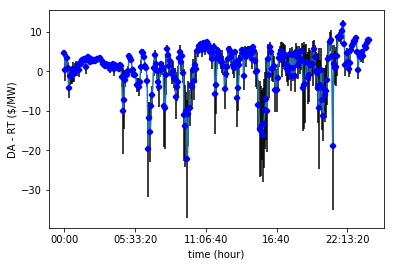

In [39]:
data1 = filled.groupby('Local Time')[['spread']].mean()

time = data1.index

data1['sem'] = filled.groupby('Local Time')[['spread']].sem()

fig, ax1 = plt.subplots()

ax1.set_xlabel('time (hour)')
ax1.set_ylabel('DA - RT ($/MW)')
ax1.plot(time, data1['spread'])
ax1.tick_params(axis='y')
ax1.errorbar(time,data1['spread'], data1['sem'],
                 marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)

In [40]:
abs(filled['spread']).mean()

11.111167871072693

In [41]:
filled = filler(filled, 'loc sem_DA')

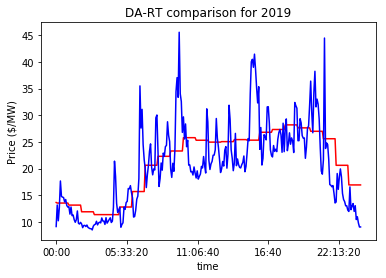

In [42]:
data1 = filled.groupby('Local Time')[['LMP_DA']].mean()
data2 = filled.groupby('Local Time')[['LMP_RT']].mean()

time = data1.index

data1['sem'] = filled.groupby('Local Time')[['LMP_DA']].sem()
data2['sem'] = filled.groupby('Local Time')[['LMP_RT']].sem()

plt.plot(time,data1['LMP_DA'],'red')
plt.plot(time,data2['LMP_RT'],'blue')

plt.ylabel('Price ($/MW)')
plt.title('DA-RT comparison for 2019')
plt.show()

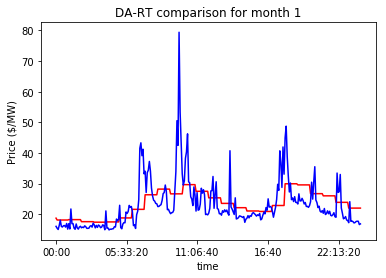

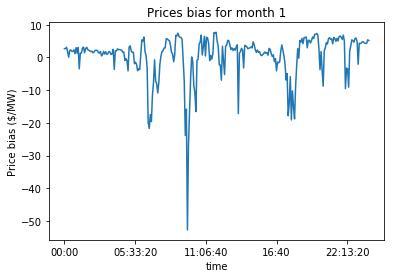

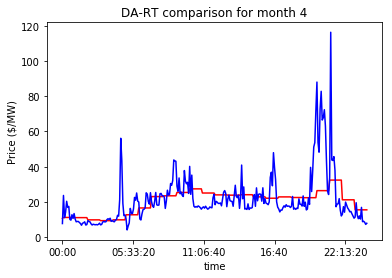

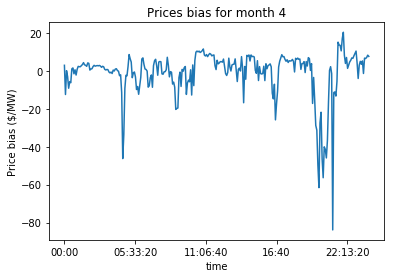

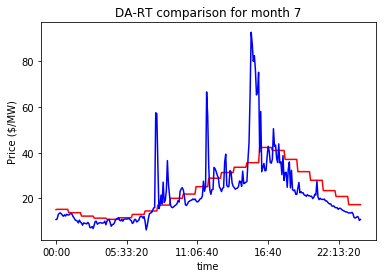

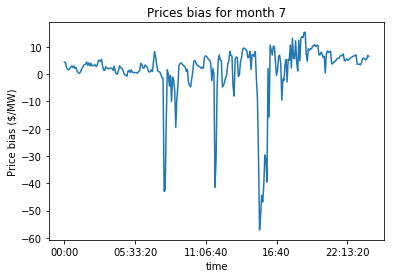

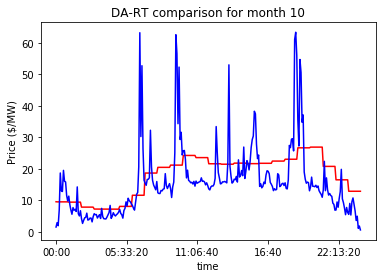

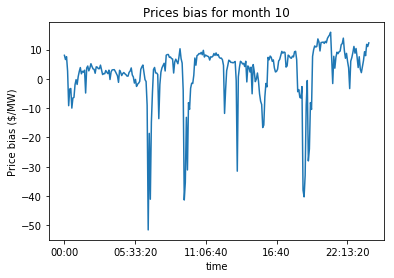

In [43]:
filled_months = filled['Local Date'].values.tolist()
months = []
for month in filled_months:
    months.append(month.month)
filled['Month'] = np.array(months)

for n in [1,4,7,10]:
    by_month = filled[filled['Month']==n]
    data1 = by_month.groupby('Local Time')[['LMP_DA']].mean()
    data2 = by_month.groupby('Local Time')[['LMP_RT']].mean()

    time = data1.index

    data1['sem'] = by_month.groupby('Local Time')[['LMP_DA']].sem()
    data2['sem'] = by_month.groupby('Local Time')[['LMP_RT']].sem()

    fig, ax1 = plt.subplots()
    
    ax1.plot(time,data1['LMP_DA'],'red')
    ax1.plot(time,data2['LMP_RT'],'blue')

    plt.ylabel('Price ($/MW)')
    plt.title('DA-RT comparison for month {}'.format(n))
    plt.show()
    
    fig, ax2 = plt.subplots()
    
    data3 = by_month.groupby('Local Time')[['spread']].mean()
    
    ax2.plot(time,data3['spread'])
    plt.ylabel('Price bias ($/MW)')
    plt.title('Prices bias for month {}'.format(n))
    plt.show()

In [44]:
by_month = filled[filled['Month']==7]
data1 = by_month.groupby('Local Time')[['LMP_DA']].mean()
data2 = by_month.groupby('Local Time')[['LMP_RT']].mean()
peaks = data2.sort_values('LMP_RT',ascending=False)


In [45]:
by_month.sort_values('LMP_RT',ascending=False)

Interval_DA     LMP_DA  loc sem_DA  \
 GMT Interval                                                     
07/12/2019 20:20:00                  NaN  42.988763    0.131599   
07/09/2019 20:35:00                  NaN  39.770369    0.297071   
07/09/2019 20:50:00                  NaN  39.770369    0.297071   
07/01/2019 12:50:00                  NaN  16.328353    0.030428   
07/01/2019 12:55:00                  NaN  16.328353    0.030428   
07/09/2019 20:55:00                  NaN  39.770369    0.297071   
07/12/2019 20:25:00                  NaN  42.988763    0.131599   
07/09/2019 20:40:00                  NaN  39.770369    0.297071   
07/02/2019 16:50:00                  NaN  31.252251    0.083166   
07/09/2019 20:45:00                  NaN  39.770369    0.297071   
07/02/2019 16:55:00                  NaN  31.252251    0.083166   
07/09/2019 20:30:00                  NaN  39.770369    0.297071   
07/09/2019 20:20:00                  NaN  39.770369    0.297071   
07/01/2019 13:00:00  07/01/2019 08:00:00  18.502537    0.042068   
07/08/2019 13:45:00                  NaN  16.883070    0.037743   
07/09/2019 20:25:00                  NaN  39.770369    0.297071   
07/09/2019 21:05:00                  NaN  47.445448    0.403075   
07/09/2019 20:10:00                  NaN  39.770369    0.297071   
07/09/2019 22:05:00                  NaN  47.127266    0.401334   
07/09/2019 20:15:00                  NaN  39.770369    0.297071   
07/27/2019 20:15:00                  NaN  28.950480    0.119204   
07/17/2019 21:05:00                  NaN  46.622029    0.643401   
07/12/2019 20:30:00                  NaN  42.988763    0.131599   
07/09/2019 21:00:00  07/09/2019 16:00:00  47.445448    0.403075   
07/09/2019 22:15:00                  NaN  47.127266    0.401334   
07/09/2019 22:10:00                  NaN  47.127266    0.401334   
07/02/2019 17:00:00  07/02/2019 12:00:00  35.256567    0.093807   
07/07/2019 17:25:00                  NaN  27.131052    0.118932   
07/03/2019 21:40:00                  NaN  35.207637    0.155960   
07/13/2019 22:30:00                  NaN  55.616463    0.098195   
...                                  ...        ...         ...   
07/25/2019 08:35:00                  NaN   4.512103    0.107732   
07/25/2019 08:15:00                  NaN   4.512103    0.107732   
07/25/2019 11:30:00                  NaN   8.958385    0.088705   
07/03/2019 07:35:00                  NaN  14.177434    0.036106   
07/17/2019 07:55:00                  NaN   9.651008    0.196898   
07/25/2019 08:05:00                  NaN   4.512103    0.107732   
07/25/2019 08:20:00                  NaN   4.512103    0.107732   
07/25/2019 08:25:00                  NaN   4.512103    0.107732   
07/25/2019 11:25:00                  NaN   8.958385    0.088705   
07/25/2019 11:20:00                  NaN   8.958385    0.088705   
07/28/2019 12:10:00                  NaN   6.838851    0.124265   
07/25/2019 10:15:00                  NaN   4.249286    0.081920   
07/25/2019 10:40:00                  NaN   4.249286    0.081920   
07/25/2019 08:00:00  07/25/2019 03:00:00   4.512103    0.107732   
07/25/2019 10:00:00  07/25/2019 05:00:00   4.249286    0.081920   
07/28/2019 12:05:00                  NaN   6.838851    0.124265   
07/03/2019 07:15:00                  NaN  14.177434    0.036106   
07/25/2019 10:10:00                  NaN   4.249286    0.081920   
07/18/2019 09:35:00                  NaN   9.113253    0.113017   
07/28/2019 07:05:00                  NaN   6.601524    0.194717   
07/25/2019 10:35:00                  NaN   4.249286    0.081920   
07/27/2019 12:00:00  07/27/2019 07:00:00  10.707167    0.041402   
07/25/2019 10:25:00                  NaN   4.249286    0.081920   
07/26/2019 05:05:00                  NaN   9.110009    0.171052   
07/25/2019 10:20:00                  NaN   4.249286    0.081920   
07/27/2019 12:05:00                  NaN  10.707167    0.041402   
07/25/2019 10:30:00                  NaN   4.249286    0.081920   
07/25/201

In [46]:
# outliers -- how to deal with them?
# for now, write a function to identify them

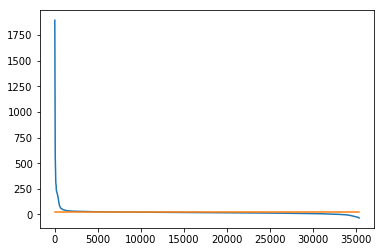

In [47]:
RT_aggloc[' LMP'].mean()
plt.plot(np.arange(1,RT_aggloc.shape[0]+1),RT_aggloc.sort_values(' LMP',ascending=False)[' LMP'])
plt.plot([0.0,float(RT_aggloc.shape[0])],[RT_aggloc[' LMP'].mean(),RT_aggloc[' LMP'].mean()])

In [48]:
(RT_aggloc[RT_aggloc[' LMP']>500].shape[0])/RT_aggloc.shape[0]

0.0017219963866305329

In [49]:
(RT_aggloc[(RT_aggloc[' LMP']<250)&(RT_aggloc[' LMP']>30)].shape[0])/RT_aggloc.shape[0]

0.06868224932249323

In [50]:
RT_peak = filled[filled['LMP_RT']>200].groupby('Local Time')[['LMP_RT']].count()
RT_peak.sort_values('LMP_RT',ascending=False).head()

LMP_RT
Local Time        
20:20:00         7
09:50:00         7
15:15:00         5
20:25:00         5
20:30:00         5

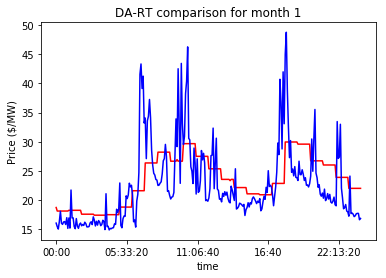

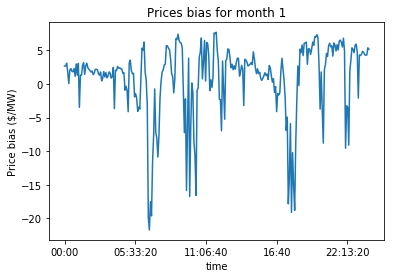

mean spread is 0.8742252898263525


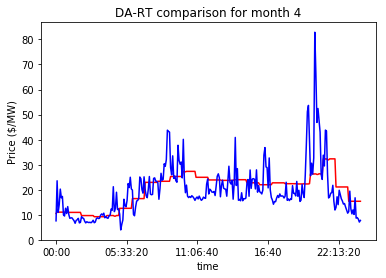

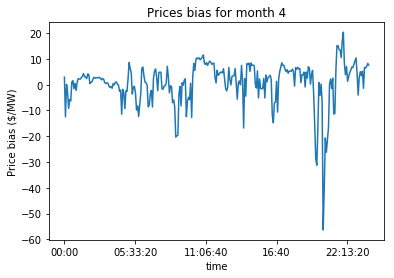

mean spread is 0.6860416804368284


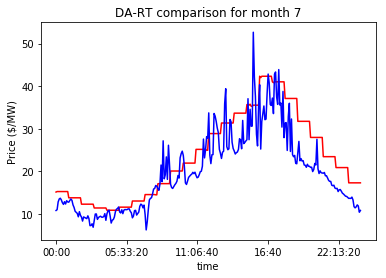

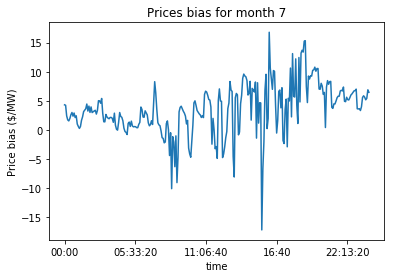

mean spread is 3.591125759561443


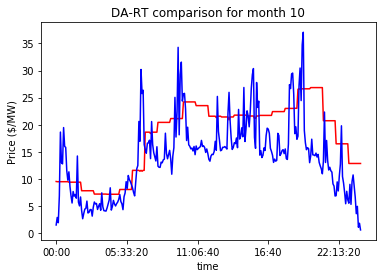

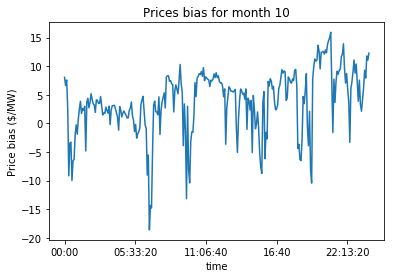

mean spread is 3.8081381841525346


In [51]:
# Deleting outliers for RT > ceiling

filled_months = filled['Local Date'].values.tolist()
months = []
for month in filled_months:
    months.append(month.month)
filled['Month'] = np.array(months)

ceiling = 500

for n in [1,4,7,10]:
    by_month = filled[(filled['Month']==n)&(filled['LMP_RT']<ceiling)]
    data1 = by_month.groupby('Local Time')[['LMP_DA']].mean()
    data2 = by_month.groupby('Local Time')[['LMP_RT']].mean()

    time = data1.index

    data1['sem'] = by_month.groupby('Local Time')[['LMP_DA']].sem()
    data2['sem'] = by_month.groupby('Local Time')[['LMP_RT']].sem()

    fig, ax1 = plt.subplots()
    
    ax1.plot(time,data1['LMP_DA'],'red',label='DA')
    ax1.plot(time,data2['LMP_RT'],'blue',label='RT')

    plt.ylabel('Price ($/MW)')
    plt.title('DA-RT comparison for month {}'.format(n))
    plt.show()
    ax1.legend(loc='best')
    
    fig, ax2 = plt.subplots()
    
    data3 = by_month.groupby('Local Time')[['spread']].mean()
    
    ax2.plot(time,data3['spread'])
    plt.ylabel('Price bias ($/MW)')
    plt.title('Prices bias for month {}'.format(n))
    plt.show()
    print("mean spread is {}".format(data3['spread'].mean()))

##### Load 2019

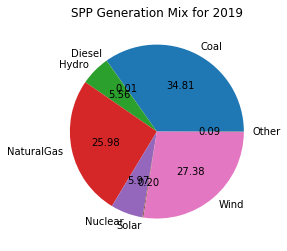

In [52]:
gen_mix_2019 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2019.csv')

new = pd.DataFrame()

first = gen_mix_2019.columns.values.tolist()[1].split(' ')[1]
new[first] = np.array([gen_mix_2019[gen_mix_2019.columns.values.tolist()[1]].sum()])
for element in gen_mix_2019.columns.values.tolist()[2:]:
    if element.split(' ')[1] == first:
        new[first] = new[first] + np.array([gen_mix_2019[element].sum()])
    else:
        new[element.split(' ')[1]] = np.array([gen_mix_2019[element].sum()])
        first = element.split(' ')[1]

output = new.loc[0].values.tolist()[0:-1]
output[3] += output[4]
del output[4]
fuels = new.columns.values.tolist()[0:-1]
fuels[3] += fuels[4]
del fuels[4]
del output[6]
del fuels[6]

plt.pie(output,labels=fuels,autopct='%.2f')
plt.title('SPP Generation Mix for 2019')
plt.show()

In [53]:
list_intervals = gen_mix_2019[gen_mix_2019.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2019['Local Date'] = np.array(local_date)
gen_mix_2019['Local Time'] = np.array(local_time)
gen_mix_2019.head()

GMT MKT Interval   Coal Market   Coal Self   Diesel Fuel Oil Market  \
0  2019-01-01T06:00:00Z         405.9      9523.5                      0.0   
1  2019-01-01T06:05:00Z         401.5      9430.0                      0.0   
2  2019-01-01T06:10:00Z         406.2      9413.6                      0.0   
3  2019-01-01T06:15:00Z         398.7      9305.7                      0.0   
4  2019-01-01T06:20:00Z         394.2      9280.2                      0.0   

    Diesel Fuel Oil Self   Hydro Market   Hydro Self   Natural Gas Market  \
0                    0.0           41.1        577.1               2982.5   
1                    0.0           41.5        578.8               2979.5   
2                    0.0           41.1        577.7               3034.6   
3                    0.0           41.3        579.7               2948.7   
4                    0.0           41.3        578.6               2925.8   

    Gas Self   Nuclear Market     ...       Waste Disposal Services Self  \
0      934.0              0.0     ...                               12.6   
1      899.6              0.0     ...                               12.8   
2      875.5              0.0     ...                               12.9   
3      855.0              0.0     ...                               12.6   
4      854.7              0.0     ...                               12.6   

    Wind Market   Wind Self   Waste Heat Market   Waste Heat Self  \
0           0.0     14228.6                 0.0               0.0   
1           0.0     14215.0                 0.0               0.0   
2           0.0     14109.8                 0.0               0.0   
3           0.0     14220.7                 0.0               0.0   
4           0.0     14237.4                 0.0               0.0   

    Other Market   Other Self       Load  Local Date  Local Time  
0            0.0         33.1  30035.759  2019-01-01    00:00:00  
1            0.0         33.1  29946.144  2019-01-01    00:05:00  
2            0.0         33.5  30011.738  2019-01-01    00:10:00  
3            0.0         33.3  30422.144  2019-01-01    00:15:00  
4            0.0         32.7  30385.553  2019-01-01    00:20:00  

[5 rows x 24 columns]

<ErrorbarContainer object of 3 artists>

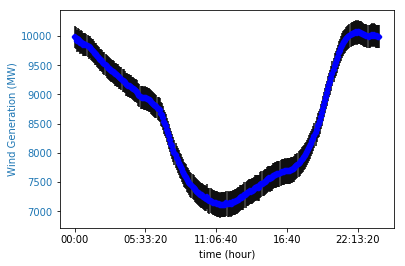

In [54]:
data1 = gen_mix_2019.groupby('Local Time')[[' Wind Self']].mean()

data1['sem'] = gen_mix_2019.groupby('Local Time')[[' Wind Self']].sem()

time = data1.index

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (hour)')
ax1.set_ylabel('Wind Generation (MW)', color=color)
ax1.plot(time, data1[' Wind Self'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.errorbar(time,data1[' Wind Self'], data1['sem'],
                 marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)

In [55]:
gen_mix_2019 = gen_mix_2019.rename(columns={' Wind Self':' Wind'})
filled = filled.rename(columns={'LMP_RT':'LMP'})

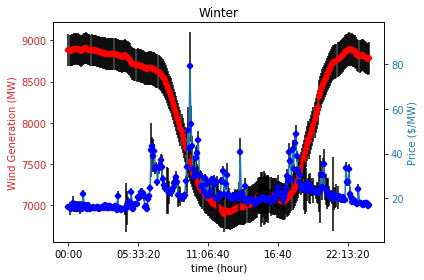

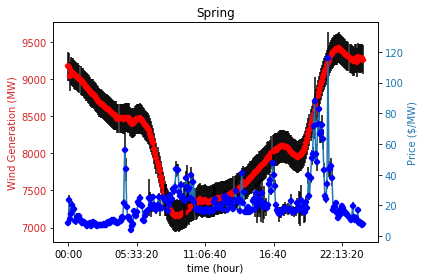

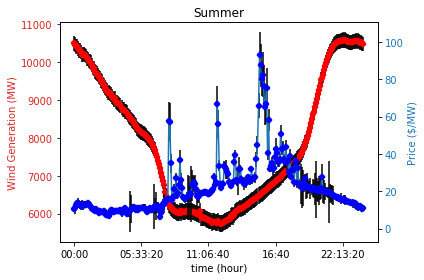

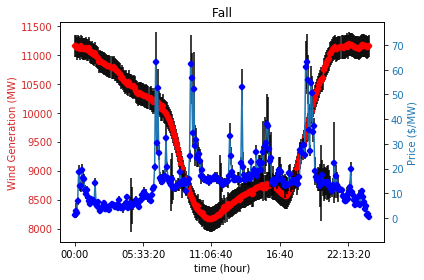

In [56]:
# Wind and RT across seasons
plot_dfs_seasons(gen_mix_2019, filled, '2019')

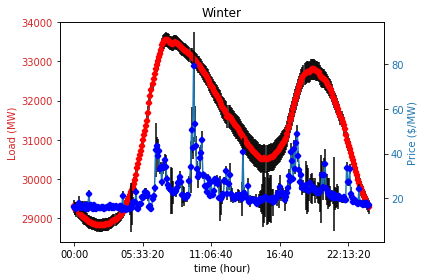

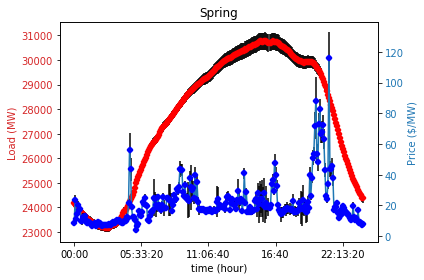

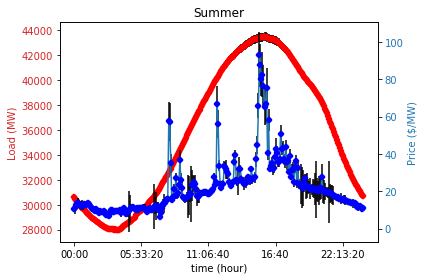

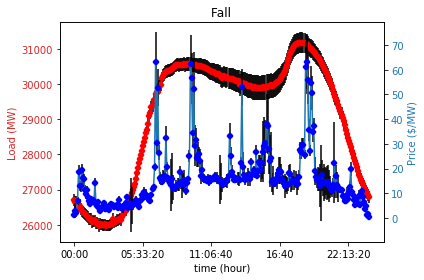

In [57]:
# Total load and RT across seasons

year = '2019'
gen = gen_mix_2019
price = filled

equinox1 = dt.datetime.strptime(year+'-03-21','%Y-%m-%d').date()
solstice1 = dt.datetime.strptime(year+'-06-21','%Y-%m-%d').date()
equinox2 = dt.datetime.strptime(year+'-09-21','%Y-%m-%d').date()
solstice2 = dt.datetime.strptime(year+'-12-21','%Y-%m-%d').date()

winter_price = price[(price['Local Date']<=equinox1)]
spring_price = price[(price['Local Date']>=equinox1) & (price['Local Date']<=solstice1)]
summer_price = price[(price['Local Date']>=solstice1) & (price['Local Date']<=equinox2)]
fall_price = price[(price['Local Date']>=equinox2)]

winter_gen = gen[(gen['Local Date']<=equinox1)]
spring_gen = gen[(gen['Local Date']>=equinox1) & (gen['Local Date']<=solstice1)]
summer_gen = gen[(gen['Local Date']>=solstice1) & (gen['Local Date']<=equinox2)]
fall_gen = gen[(gen['Local Date']>=equinox2)]

seasons_dict = {'Winter':[winter_price, winter_gen],
                'Spring':[spring_price, spring_gen],
                'Summer':[summer_price, summer_gen],
                'Fall':[fall_price, fall_gen]
               }

for season, data in seasons_dict.items():

    data1 = data[1].groupby('Local Time')[[' Load']].mean()
    data2 = data[0].groupby('Local Time')[['LMP']].mean()

    time = data1.index

    data1['sem'] = gen.groupby('Local Time')[[' Load']].sem()
    data2['sem'] = price.groupby('Local Time')[['LMP']].sem()

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (hour)')
    ax1.set_ylabel('Load (MW)', color=color)
    ax1.plot(time, data1[' Load'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.errorbar(time,data1[' Load'], data1['sem'],
                     marker='x', ecolor='black',mec='red', linestyle='None',ms=4, mew=4, label=None)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    time = data2.index

    color = 'tab:blue'
    ax2.set_ylabel('Price ($/MW)', color=color)  # we already handled the x-label with ax1
    ax2.plot(time, data2['LMP'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.errorbar(time,data2['LMP'], data2['sem'],
                     marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)


    plt.title(season)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

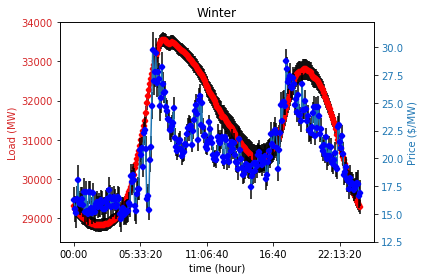

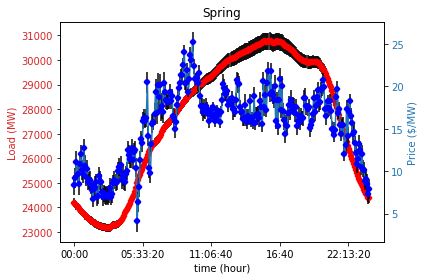

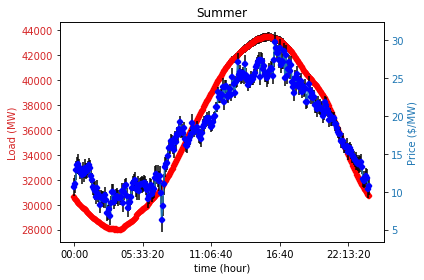

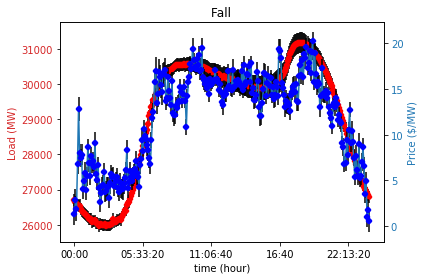

In [58]:
# Total load and RT across seasons -- excluding outliers above ceiling

year = '2019'
gen = gen_mix_2019
price = filled[filled['LMP']<100]

equinox1 = dt.datetime.strptime(year+'-03-21','%Y-%m-%d').date()
solstice1 = dt.datetime.strptime(year+'-06-21','%Y-%m-%d').date()
equinox2 = dt.datetime.strptime(year+'-09-21','%Y-%m-%d').date()
solstice2 = dt.datetime.strptime(year+'-12-21','%Y-%m-%d').date()

winter_price = price[(price['Local Date']<=equinox1)]
spring_price = price[(price['Local Date']>=equinox1) & (price['Local Date']<=solstice1)]
summer_price = price[(price['Local Date']>=solstice1) & (price['Local Date']<=equinox2)]
fall_price = price[(price['Local Date']>=equinox2)]

winter_gen = gen[(gen['Local Date']<=equinox1)]
spring_gen = gen[(gen['Local Date']>=equinox1) & (gen['Local Date']<=solstice1)]
summer_gen = gen[(gen['Local Date']>=solstice1) & (gen['Local Date']<=equinox2)]
fall_gen = gen[(gen['Local Date']>=equinox2)]

seasons_dict = {'Winter':[winter_price, winter_gen],
                'Spring':[spring_price, spring_gen],
                'Summer':[summer_price, summer_gen],
                'Fall':[fall_price, fall_gen]
               }

for season, data in seasons_dict.items():

    data1 = data[1].groupby('Local Time')[[' Load']].mean()
    data2 = data[0].groupby('Local Time')[['LMP']].mean()

    time = data1.index

    data1['sem'] = gen.groupby('Local Time')[[' Load']].sem()
    data2['sem'] = price.groupby('Local Time')[['LMP']].sem()

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (hour)')
    ax1.set_ylabel('Load (MW)', color=color)
    ax1.plot(time, data1[' Load'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.errorbar(time,data1[' Load'], data1['sem'],
                     marker='x', ecolor='black',mec='red', linestyle='None',ms=4, mew=4, label=None)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    time = data2.index

    color = 'tab:blue'
    ax2.set_ylabel('Price ($/MW)', color=color)  # we already handled the x-label with ax1
    ax2.plot(time, data2['LMP'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.errorbar(time,data2['LMP'], data2['sem'],
                     marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)


    plt.title(season)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

1.052803085921596

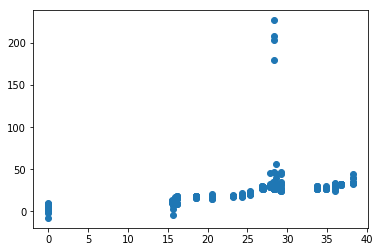

In [59]:
prices_date = filled[filled['Local Date']==filled['Local Date'][0]]
RT_price = prices_date.groupby('Local Time')[['LMP']].first()
DA_price = prices_date.groupby('Local Time')[['LMP_DA']].first()
comparison = DA_price.join(RT_price,how='right',lsuffix='_DA',rsuffix='_RT')
comparison2 = filler(comparison, 'LMP_DA')
m, b = np.polyfit(comparison2['LMP_DA'], comparison2['LMP'], 1)
plt.scatter(comparison2['LMP_DA'],comparison2['LMP'])
m


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  


mean ± sem = 0.967 ± 0.087


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  


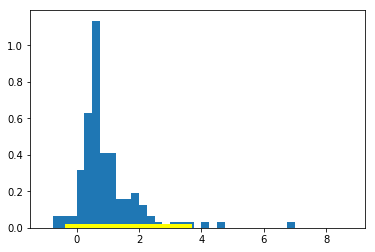

In [60]:
# Histogram with RT vs DA slopes for each day of the year
# for this data set I filled in the empty points for DA

dates_of_year = filled.groupby("Local Date").max().index.values.tolist()

slopes = np.empty(len(dates_of_year))
i = 0
for date in dates_of_year:
    prices_date = filled[filled['Local Date']==date]
    RT_price = prices_date.groupby('Local Time')[['LMP']].first()
    DA_price = prices_date.groupby('Local Time')[['LMP_DA']].first()
    comparison = DA_price.join(RT_price,how='right',lsuffix='_DA',rsuffix='_RT')
    comparison2 = filler(comparison, 'LMP_DA')
    m, b = np.polyfit(comparison2['LMP_DA'], comparison2['LMP'], 1)
    slopes[i] = m
    i += 1

_ = plt.hist(slopes,density=True,bins=np.arange(-1,9,0.25))
mean = slopes.mean()
sem = stats.sem(slopes)
left = np.percentile(slopes, 2.5)
right = np.percentile(slopes, 97.5)
plt.plot([left, right], [0,0], color='yellow', lw=8)
print("mean {} sem = {} {} {}".format(u"\u00B1",round(mean,3),u"\u00B1",round(sem,3)))

In [61]:
# Peaks above 200 for 2019
RT_peak = filled[filled['LMP']>200].groupby('Local Time')[['LMP']].count()
RT_peak.sort_values('LMP',ascending=False).head()

LMP
Local Time     
20:20:00      7
09:50:00      7
15:15:00      5
20:25:00      5
20:30:00      5

In [62]:
# better name
DART = filled

In [63]:
study = DART[DART['Local Date']==dt.date(2019,1,2)]
intervals = study['Local Time'].values.tolist()
i = 0
points = []
for time in intervals:
    mean = study['LMP'][0:i+1].mean()
    if study['LMP'][i] > 2*mean:
        if (study['LMP'][i] - mean) > study['LMP'].mean()/2:
            points.append(time)
    i += 1
points

[datetime.time(10, 10),
 datetime.time(10, 15),
 datetime.time(10, 20),
 datetime.time(10, 35),
 datetime.time(10, 40),
 datetime.time(10, 55),
 datetime.time(12, 15),
 datetime.time(12, 20),
 datetime.time(12, 30),
 datetime.time(12, 35),
 datetime.time(17, 50),
 datetime.time(18, 25),
 datetime.time(18, 45)]

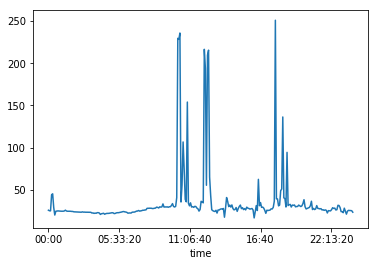

In [64]:
plt.plot(study['Local Time'],study['LMP'])

In [9]:
def crit_pts(df):
    intervals = df['Local Time'].values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP'][0:i+1].mean()
        if df['LMP'][i] > 2*mean:
            if (df['LMP'][i] - mean) > df['LMP'].mean()/2:
                points.append(time)
        i += 1
    return points

In [66]:
study = DART[DART['Local Date']==dt.date(2019,7,10)]
crit_pts(study)

[]

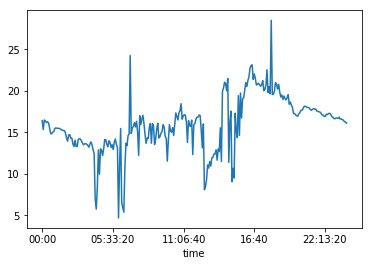

In [67]:
plt.plot(study['Local Time'],study['LMP'])
# there were fluctuations, but this day was particularly "calm" -- no sharp peaks with terrible outliers

In [68]:
study = DART[DART['Local Date']==dt.date(2019,10,11)]
len(crit_pts(study))
# on the other hand, this day was a lot more agitated 

61

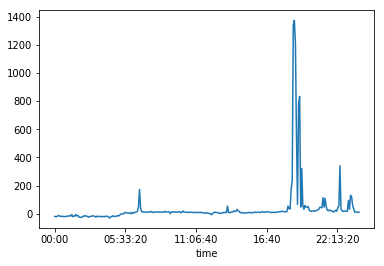

In [69]:
plt.plot(study['Local Time'],study['LMP'])

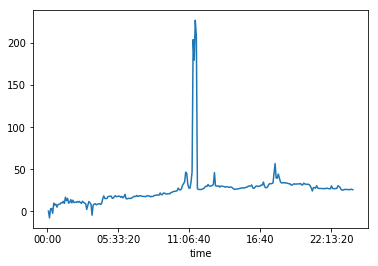

In [70]:
study = DART[DART['Local Date']==dt.date(2019,1,1)]
plt.plot(study['Local Time'],study['LMP'])

In [71]:
crit_pts(study)

[datetime.time(10, 35),
 datetime.time(10, 40),
 datetime.time(10, 45),
 datetime.time(10, 50),
 datetime.time(10, 55),
 datetime.time(11, 0),
 datetime.time(11, 15),
 datetime.time(11, 20),
 datetime.time(11, 25),
 datetime.time(11, 30),
 datetime.time(11, 35),
 datetime.time(11, 40),
 datetime.time(13, 5),
 datetime.time(17, 50)]

In [72]:
DART_days = DART['Local Date'].values.tolist()
days = []
for day in DART_days:
    days.append(day.day)
DART['Day'] = np.array(days)

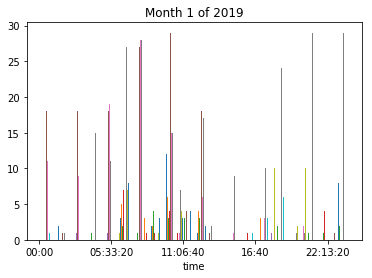

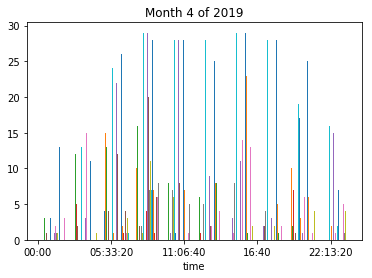

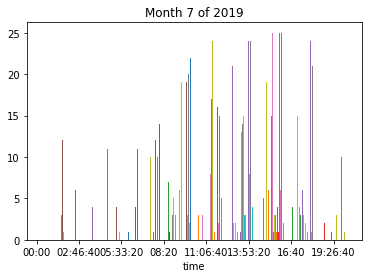

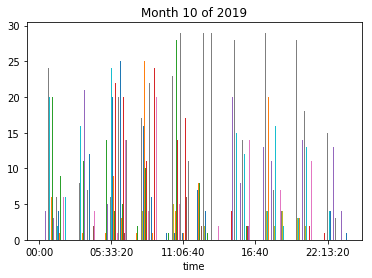

In [73]:
# histogram to visualize most common peak times -- interpretation unclear though
arrays = []
for month in [1,4,7,10]:
    month_df = DART[DART['Month']==month]
    critical = []
    for day in range (1,month_df['Day'][-1]+1):
        day_df = month_df[month_df['Day']==day]
        critical.append(crit_pts(day_df))
    crit_array = np.array(critical)
    arrays.append(crit_array)
    _ = plt.hist(crit_array)
    plt.title("Month {} of 2019".format(month))
    plt.show()
    

In [74]:
# the crit_pts works well for well-defined curves, i.e., positive prices with sharp peaks,
# but not quite well for days with negative prices (Jan 6) and weirder shapes
# for now, use this function for monthly averages

dfs = []
for n in range(1,31):    
    df_day = pd.DataFrame({'hour':arrays[0][n]})
    dfs.append(df_day)

#pd.concat(dfs,axis=1)

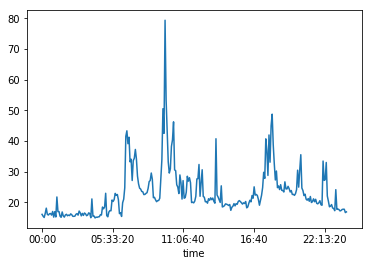

[datetime.time(6, 35), datetime.time(6, 40), datetime.time(6, 45), datetime.time(6, 50), datetime.time(9, 30), datetime.time(9, 35), datetime.time(9, 40), datetime.time(9, 45), datetime.time(10, 20), datetime.time(18, 5)]


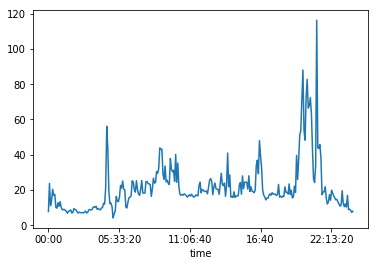

[datetime.time(4, 30), datetime.time(4, 35), datetime.time(4, 40), datetime.time(5, 50), datetime.time(6, 35), datetime.time(8, 30), datetime.time(8, 40), datetime.time(8, 45), datetime.time(8, 50), datetime.time(8, 55), datetime.time(9, 10), datetime.time(9, 35), datetime.time(10, 0), datetime.time(10, 10), datetime.time(14, 5), datetime.time(16, 35), datetime.time(16, 40), datetime.time(19, 30), datetime.time(19, 45), datetime.time(19, 50), datetime.time(19, 55), datetime.time(20, 0), datetime.time(20, 5), datetime.time(20, 10), datetime.time(20, 15), datetime.time(20, 20), datetime.time(20, 25), datetime.time(20, 30), datetime.time(20, 35), datetime.time(20, 40), datetime.time(20, 45), datetime.time(21, 5), datetime.time(21, 20)]


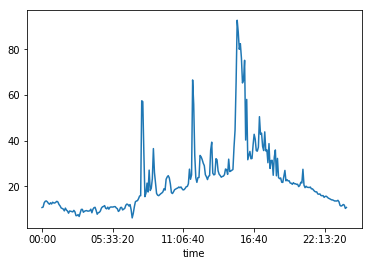

[datetime.time(7, 50), datetime.time(7, 55), datetime.time(8, 0), datetime.time(8, 25), datetime.time(8, 45), datetime.time(8, 50), datetime.time(11, 50), datetime.time(11, 55), datetime.time(12, 0), datetime.time(12, 25), datetime.time(12, 30), datetime.time(12, 35), datetime.time(13, 15), datetime.time(13, 20), datetime.time(15, 5), datetime.time(15, 10), datetime.time(15, 15), datetime.time(15, 20), datetime.time(15, 25), datetime.time(15, 30), datetime.time(15, 35), datetime.time(15, 40), datetime.time(15, 45), datetime.time(15, 50), datetime.time(15, 55), datetime.time(16, 5), datetime.time(17, 5)]


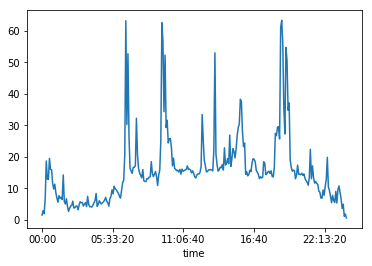

[datetime.time(0, 20), datetime.time(0, 35), datetime.time(6, 30), datetime.time(6, 35), datetime.time(6, 40), datetime.time(6, 45), datetime.time(6, 50), datetime.time(7, 25), datetime.time(7, 30), datetime.time(9, 20), datetime.time(9, 25), datetime.time(9, 30), datetime.time(9, 35), datetime.time(9, 40), datetime.time(9, 45), datetime.time(9, 50), datetime.time(10, 0), datetime.time(10, 5), datetime.time(12, 35), datetime.time(13, 35), datetime.time(15, 30), datetime.time(15, 35), datetime.time(15, 40), datetime.time(18, 45), datetime.time(18, 50), datetime.time(18, 55), datetime.time(19, 0), datetime.time(19, 10), datetime.time(19, 15), datetime.time(19, 20), datetime.time(19, 25)]


In [75]:
monthly_pts = []
for n in [1,4,7,10]:
    by_month = DART[DART['Month']==n]
    data = by_month.groupby('Local Time')[['LMP']].mean()
    data['Local Time'] = data.index
    monthly_pts.append(crit_pts(data))
    plt.plot(data.index, data['LMP'])
    plt.show()
    print(crit_pts(data))


Text(0.5, 1.0, 'peak occurrences in 2019')

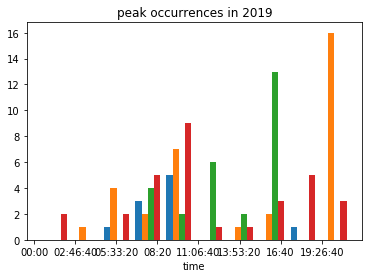

In [76]:
plt.hist(np.array(monthly_pts))
plt.title('peak occurrences in 2019')

##### Let's study 2017

In [78]:
gen_mix_2017 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2017.csv')
list_intervals = gen_mix_2017[gen_mix_2017.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2017['Local Date'] = np.array(local_date)
gen_mix_2017['Local Time'] = np.array(local_time)

In [80]:
RT_2017 = pd.read_csv(SPP_path + '\\RT\\2017\\LMP_SL_2017.csv')
RT_2017

INTERVAL              GMTINTERVALEND  \
0         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
1         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
2         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
3         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
4         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
5         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
6         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
7         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
8         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
9         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
10        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
11        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
12        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
13        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
14        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
15        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
16        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
17        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
18        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
19        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
20        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
21        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
22        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
23        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
24        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
25        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
26        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
27        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
28        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
29        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
...                              ...                         ...   
99363078  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363079  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363080  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363081  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363082  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363083  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363084  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363085  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363086  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363087  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363088  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363089  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363090  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363091  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363092  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363093  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363094  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363095  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363096  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363097  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363098  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363099  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363100  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363101  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363102  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363103  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363104  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363105  2018-0

In [81]:
RT2017_aggloc = RT_2017.groupby('INTERVAL')[['INTERVAL','LMP']].agg({'INTERVAL':'first',
                                                                    'LMP':'mean'})

In [10]:
def add_info(df):
    intervals = df[df.columns[0]].values.tolist()
    dates = []
    times = []
    weekday = []
    months = []
    days = []
    hour = []
    for interval in intervals:
        date = interval.split(' ')[0]
        try:
            date = dt.datetime.strptime(date,'%Y-%m-%d').date()
        except:
            date = dt.datetime.strptime(date,'%m/%d/%Y').date()            
        dates.append(date)
        months.append(date.month)
        days.append(date.day)
        if date.weekday() < 5:
            weekday.append(True)
        else:
            weekday.append(False)
        time = interval.split(' ')[1].split('.')[0]
        time = dt.datetime.strptime(time,'%H:%M:%S').time()
        times.append(time)
        hour.append(dt.time(time.hour))
    df['Local Date'] = np.array(dates)
    df['Local Time'] = np.array(times)
    df['Hour'] = np.array(hour)
    df['Weekday'] = np.array(weekday)
    df['Month'] = np.array(months)
    df['Day'] = np.array(days)
    return df

In [83]:
RT = add_info(RT2017_aggloc)
RT.head()

INTERVAL        LMP  Local Date  \
INTERVAL                                                                        
2017-01-01 00:05:00.000000  2017-01-01 00:05:00.000000  16.911322  2017-01-01   
2017-01-01 00:10:00.000000  2017-01-01 00:10:00.000000  17.264418  2017-01-01   
2017-01-01 00:15:00.000000  2017-01-01 00:15:00.000000  16.422609  2017-01-01   
2017-01-01 00:20:00.000000  2017-01-01 00:20:00.000000  21.653247  2017-01-01   
2017-01-01 00:25:00.000000  2017-01-01 00:25:00.000000  18.293177  2017-01-01   

                           Local Time      Hour  Weekday  Month  Day  
INTERVAL                                                              
2017-01-01 00:05:00.000000   00:05:00  00:00:00    False      1    1  
2017-01-01 00:10:00.000000   00:10:00  00:00:00    False      1    1  
2017-01-01 00:15:00.000000   00:15:00  00:00:00    False      1    1  
2017-01-01 00:20:00.000000   00:20:00  00:00:00    False      1    1  
2017-01-01 00:25:00.000000   00:25:00  00:00:00    False      1    1

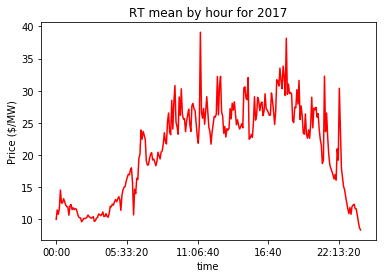

In [84]:
data1 = RT.groupby('Local Time')[['LMP']].mean()

time = data1.index

plt.plot(time,data1['LMP'],'red')

plt.ylabel('Price ($/MW)')
plt.title('RT mean by hour for 2017')
plt.show()

In [14]:
def get_LMP(df, x):
    i = 0
    LMP = []
    for time in df['Local Time']:
        if time in x:
            LMP.append(df['LMP'][i])
        i += 1
    array = np.array(LMP)
    return array

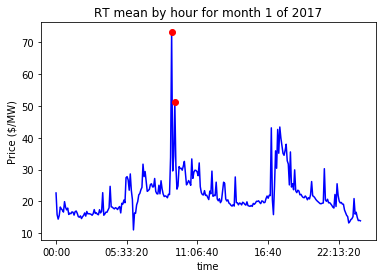

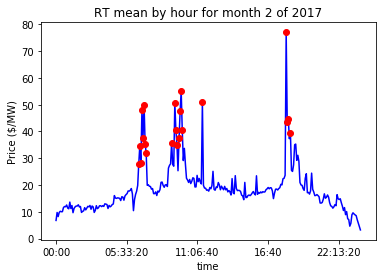

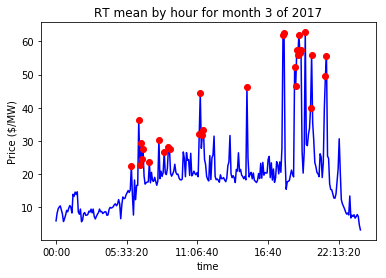

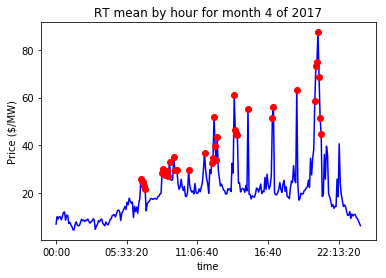

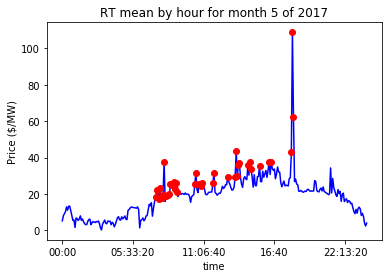

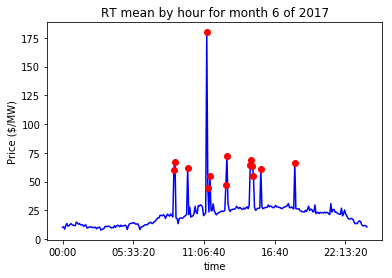

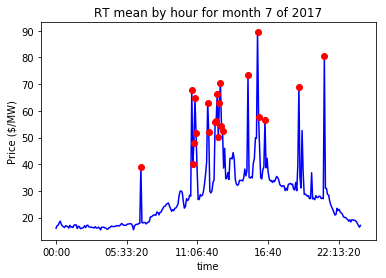

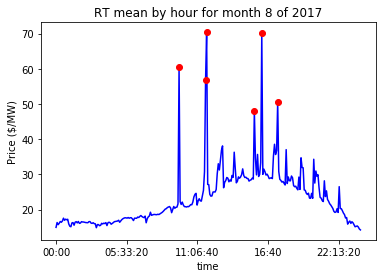

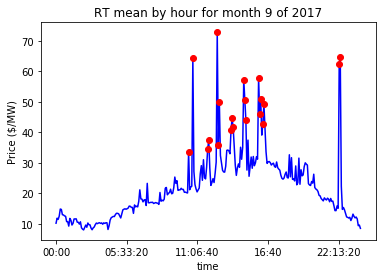

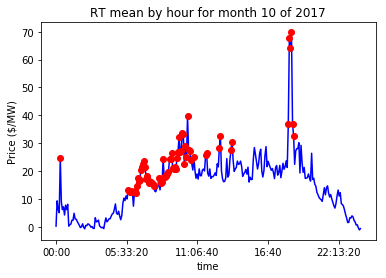

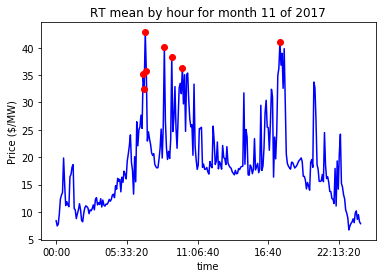

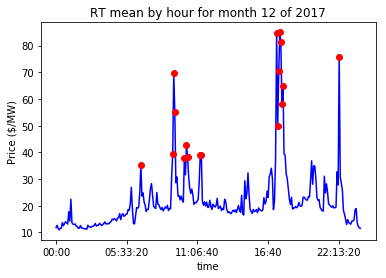

In [86]:

monthly_pts = []
for n in range(1,13):
    by_month = RT[RT['Month']==n]
    data1 = by_month.groupby('Local Time')[['LMP']].mean()
    data1['Local Time'] = data1.index
    
    time = data1.index

    fig, ax1 = plt.subplots()
    
    ax1.plot(time,data1['LMP'],'blue')

    monthly_pts.append(crit_pts(data1))
    
    plt.plot(crit_pts(data1),get_LMP(data1,crit_pts(data1)),'ro')
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2017'.format(n))
    plt.show()

Text(0.5, 1.0, 'peak occurrences in 2017')

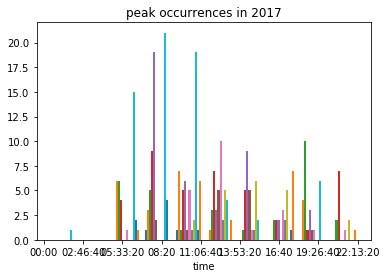

In [87]:
plt.hist(np.array(monthly_pts))
plt.title('peak occurrences in 2017')
# inconclusive

##### 2018

In [11]:
gen_mix_2018 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2018.csv')
list_intervals = gen_mix_2018[gen_mix_2018.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2018['Local Date'] = np.array(local_date)
gen_mix_2018['Local Time'] = np.array(local_time)

In [12]:
days_31 = []
for n in range(1,10):
    days_31.append('0'+str(n))
for n in range(10,32):
    days_31.append(str(n))

In [15]:
# Opening and concatenating RT datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\RT\2018'
RT_path = 'RTBM-LMP-DAILY-SL-2018'
end = '.csv'
dfs = []
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+RT_path+key+value+end))
RT = pd.concat(dfs)
RT.head()

Interval         GMT Interval  Settlement Location Name  \
0  01/01/2018 00:05:00  01/01/2018 06:05:00                       AEC   
1  01/01/2018 00:05:00  01/01/2018 06:05:00                 AECC_CSWS   
2  01/01/2018 00:05:00  01/01/2018 06:05:00               AECC_ELKINS   
3  01/01/2018 00:05:00  01/01/2018 06:05:00             AECC_FITZHUGH   
4  01/01/2018 00:05:00  01/01/2018 06:05:00             AECC_FLTCREEK   

                    PNODE Name       LMP     MLC      MCC       MEC  
0                         SOUC  255.8769  5.4654   0.0000  250.4115  
1                 CSWS_AECC_LA  262.5802  5.0312   7.1375  250.4115  
2        CSWSELKINSUNELKINS_RA  270.2234  3.0020  16.8099  250.4115  
3             CSWSFITZHUGHPLT1  257.2724  6.8609   0.0000  250.4115  
4  CSWSFLINTCRKUN1_JOU_AECC_RA  266.5657 -3.0577  19.2119  250.4115

In [16]:
RT.shape

(101822028, 8)

In [17]:
RT2018_aggloc = RT.groupby('Interval')[['Interval',' LMP']].agg({'Interval':'first',
                                                                    ' LMP':'mean'})

In [18]:
RT2018 = add_info(RT2018_aggloc)
RT2018 = RT2018.rename(columns={' LMP':'LMP'})
RT2018.tail()

Interval       LMP  Local Date Local Time  \
Interval                                                                    
12/31/2018 23:35:00  12/31/2018 23:35:00  4.594098  2018-12-31   23:35:00   
12/31/2018 23:40:00  12/31/2018 23:40:00  5.619686  2018-12-31   23:40:00   
12/31/2018 23:45:00  12/31/2018 23:45:00  6.208854  2018-12-31   23:45:00   
12/31/2018 23:50:00  12/31/2018 23:50:00  6.696047  2018-12-31   23:50:00   
12/31/2018 23:55:00  12/31/2018 23:55:00  3.238793  2018-12-31   23:55:00   

                         Hour  Weekday  Month  Day  
Interval                                            
12/31/2018 23:35:00  23:00:00     True     12   31  
12/31/2018 23:40:00  23:00:00     True     12   31  
12/31/2018 23:45:00  23:00:00     True     12   31  
12/31/2018 23:50:00  23:00:00     True     12   31  
12/31/2018 23:55:00  23:00:00     True     12   31

In [19]:
# Opening and concatenating DA datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2018'
DA_path = 'DA-LMP-SL-2018'
end = '0100.csv'
dfs = []
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+DA_path+key+value+end))
DA2018 = pd.concat(dfs)
DA2018.head()

Interval       GMTIntervalEnd Settlement Location  \
0  01/01/2018 01:00:00  01/01/2018 07:00:00                 AEC   
1  01/01/2018 01:00:00  01/01/2018 07:00:00           AECC_CSWS   
2  01/01/2018 01:00:00  01/01/2018 07:00:00         AECC_ELKINS   
3  01/01/2018 01:00:00  01/01/2018 07:00:00       AECC_FITZHUGH   
4  01/01/2018 01:00:00  01/01/2018 07:00:00       AECC_FLTCREEK   

                         Pnode      LMP     MLC     MCC      MEC  
0                         SOUC  39.6809  0.8665  0.5970  38.2174  
1                 CSWS_AECC_LA  38.3723  0.7331 -0.5781  38.2173  
2        CSWSELKINSUNELKINS_RA  38.4189  0.4093 -0.2077  38.2173  
3             CSWSFITZHUGHPLT1  38.5076  1.0540 -0.7637  38.2173  
4  CSWSFLINTCRKUN1_JOU_AECC_RA  37.8395 -0.4387  0.0609  38.2173

In [20]:
DA2018_aggloc = DA2018.groupby('Interval')[['Interval','LMP']].agg({'Interval':'first',
                                                                    'LMP':'mean'})

In [21]:
DA2018_aggloc = add_info(DA2018_aggloc)
DA2018_aggloc.tail()

Interval        LMP  Local Date Local Time  \
Interval                                                                     
12/31/2018 19:00:00  12/31/2018 19:00:00  16.158349  2018-12-31   19:00:00   
12/31/2018 20:00:00  12/31/2018 20:00:00  15.493713  2018-12-31   20:00:00   
12/31/2018 21:00:00  12/31/2018 21:00:00  14.896968  2018-12-31   21:00:00   
12/31/2018 22:00:00  12/31/2018 22:00:00  13.512476  2018-12-31   22:00:00   
12/31/2018 23:00:00  12/31/2018 23:00:00  14.168643  2018-12-31   23:00:00   

                         Hour  Weekday  Month  Day  
Interval                                            
12/31/2018 19:00:00  19:00:00     True     12   31  
12/31/2018 20:00:00  20:00:00     True     12   31  
12/31/2018 21:00:00  21:00:00     True     12   31  
12/31/2018 22:00:00  22:00:00     True     12   31  
12/31/2018 23:00:00  23:00:00     True     12   31

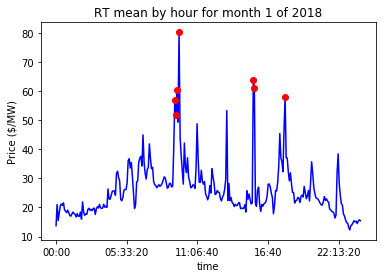

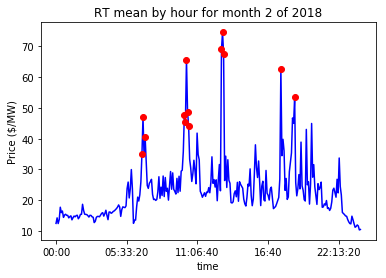

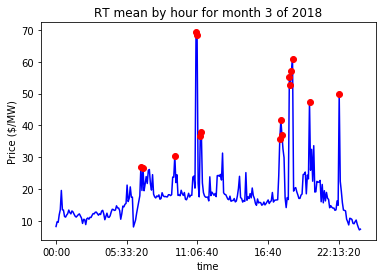

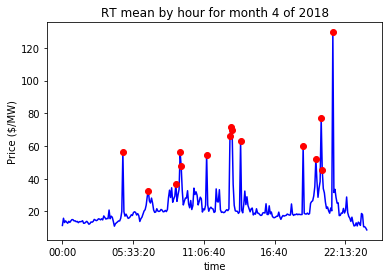

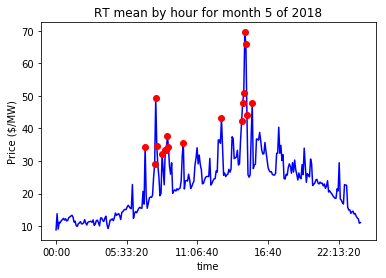

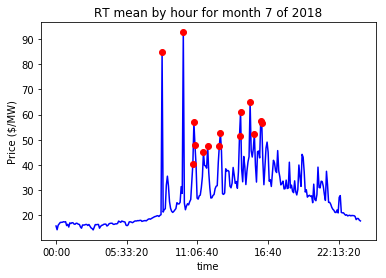

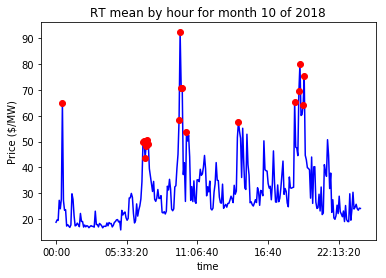

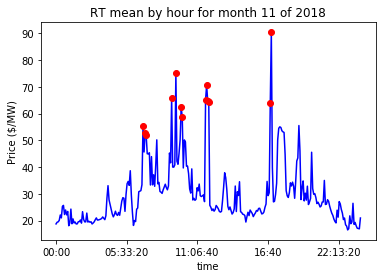

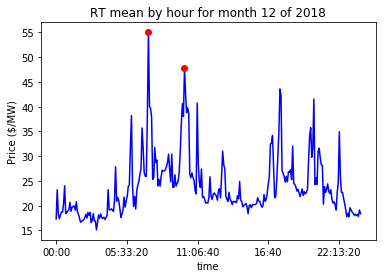

In [22]:
### studying 5-min intervals

monthly_pts = []
for n in range(1,13):
    by_month = RT2018[RT2018['Month']==n]
    data1 = by_month.groupby('Local Time')[['LMP']].mean()
    data1['Local Time'] = data1.index
    
    time = data1.index

    fig, ax1 = plt.subplots()
    
    ax1.plot(time,data1['LMP'],'blue')

    monthly_pts.append(crit_pts(data1))
    
    plt.plot(crit_pts(data1),get_LMP(data1,crit_pts(data1)),'ro')
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [23]:
def crit_hours(df):
    intervals = df['Local Hour'].values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP'][0:i+1].mean()
        if df['LMP'][i] > 1.5*mean:
            if (df['LMP'][i] - mean) > df['LMP'].mean()/3:
                points.append(time)
        i += 1
    return points
def LMP_hour(df, x):
    i = 0
    LMP = []
    for time in df['Local Hour']:
        if time in x:
            LMP.append(df['LMP_RT'][i])
        i += 1
    array = np.array(LMP)
    return array

monthly_pts = []

for n in range(1,13):
    by_month = RT2018[RT2018['Month']==n]
    data1 = by_month.groupby('Hour')[['LMP']].mean()
    data1['sem'] = by_month.groupby('Hour')[['LMP']].sem()
    data1['Local Hour'] = data1.index

    time = data1.index

    monthly_pts.append(crit_hours(data1))   
    
    fig, ax1 = plt.subplots()
    ax1.plot(time,data1['LMP'],'blue')
    plt.plot(crit_hours(data1),LMP_hour(data1,crit_hours(data1)),'ro')
    ax1.errorbar(time,data1['LMP'], data1['sem'],
                 fmt='none')
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [24]:
RT_dfs = []
days_31 = []
for n in range(1,32):
    days_31.append(n)
cal_dict = {1:days_31,
            2:days_31[0:28],
            3:days_31,
            4:days_31[0:-1],
            5:days_31,
            6:days_31[0:-1],
            7:days_31,
            8:days_31,
            9:days_31[0:-1],
            10:days_31,
            11:days_31[0:-1],
            12:days_31}
for key in cal_dict.keys():
    for value in cal_dict[key]:
        day_df = RT2018[(RT2018['Month']==key)&(RT2018['Day']==value)]
        RT_dfs.append(day_df.groupby('Hour')[['Interval','LMP']].agg({'Interval':'first',
                                                                    'LMP':'mean'}))
RT2018_hour = pd.concat(RT_dfs)
RT2018_hour.head()

Interval         LMP
Hour                                     
00:00:00  01/01/2018 00:05:00  116.701657
01:00:00  01/01/2018 01:00:00   28.641704
02:00:00  01/01/2018 02:00:00   50.201946
03:00:00  01/01/2018 03:00:00   28.285259
04:00:00  01/01/2018 04:00:00  122.022561

In [25]:
RT2018_hour.index = RT2018_hour['Interval']
RT2018_hour.head()

Interval         LMP
Interval                                            
01/01/2018 00:05:00  01/01/2018 00:05:00  116.701657
01/01/2018 01:00:00  01/01/2018 01:00:00   28.641704
01/01/2018 02:00:00  01/01/2018 02:00:00   50.201946
01/01/2018 03:00:00  01/01/2018 03:00:00   28.285259
01/01/2018 04:00:00  01/01/2018 04:00:00  122.022561

In [26]:
DART2018 = DA2018_aggloc.join(RT2018_hour,how='right',lsuffix='_DA',rsuffix='_RT')
DART2018.head()

Interval_DA     LMP_DA  Local Date Local Time  \
Interval                                                                     
01/01/2018 00:05:00                  NaN        NaN         NaN        NaN   
01/01/2018 01:00:00  01/01/2018 01:00:00  37.390157  2018-01-01   01:00:00   
01/01/2018 02:00:00  01/01/2018 02:00:00  37.249877  2018-01-01   02:00:00   
01/01/2018 03:00:00  01/01/2018 03:00:00  37.998882  2018-01-01   03:00:00   
01/01/2018 04:00:00  01/01/2018 04:00:00  40.778408  2018-01-01   04:00:00   

                         Hour Weekday  Month  Day          Interval_RT  \
Interval                                                                 
01/01/2018 00:05:00       NaN     NaN    NaN  NaN  01/01/2018 00:05:00   
01/01/2018 01:00:00  01:00:00    True    1.0  1.0  01/01/2018 01:00:00   
01/01/2018 02:00:00  02:00:00    True    1.0  1.0  01/01/2018 02:00:00   
01/01/2018 03:00:00  03:00:00    True    1.0  1.0  01/01/2018 03:00:00   
01/01/2018 04:00:00  04:00:00    True    1.0  1.0  01/01/2018 04:00:00   

                         LMP_RT  
Interval                         
01/01/2018 00:05:00  116.701657  
01/01/2018 01:00:00   28.641704  
01/01/2018 02:00:00   50.201946  
01/01/2018 03:00:00   28.285259  
01/01/2018 04:00:00  122.022561

In [27]:
def critical(df):
    intervals = df['Local Hour'].values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP_RT'][0:i+1].mean()
        if df['LMP_RT'][i] > 1.5*mean:
            if (df['LMP_RT'][i] - mean) > df['LMP_RT'].mean()/3:
                points.append(time)
        i += 1
    x = np.array(points)
    
    i = 0
    LMP = []
    for time in df['Local Hour']:
        if time in x:
            LMP.append(df['LMP_RT'][i])
        i += 1
    y = np.array(LMP)
    
    return [x,y]


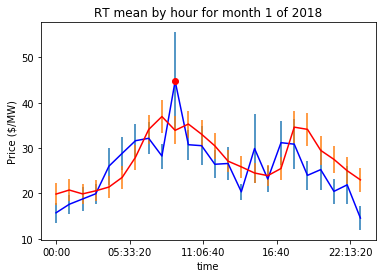

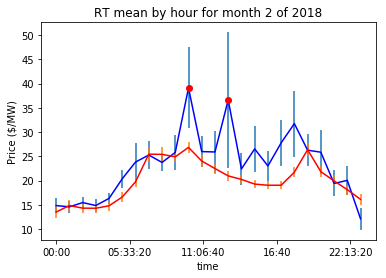

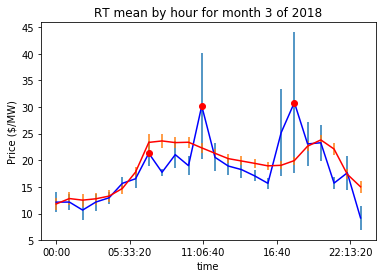

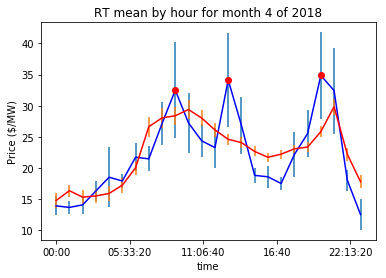

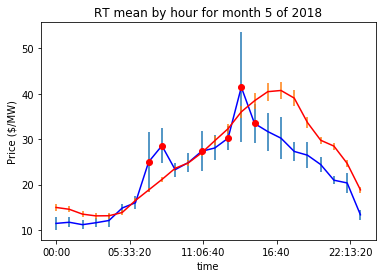

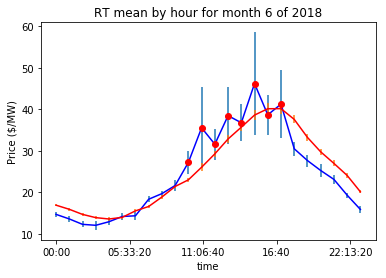

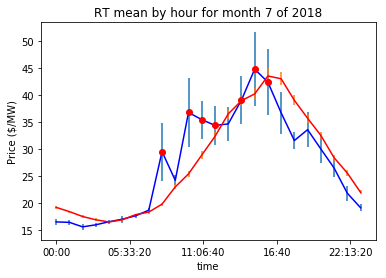

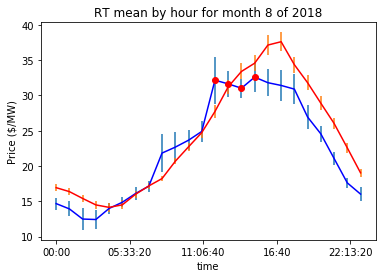

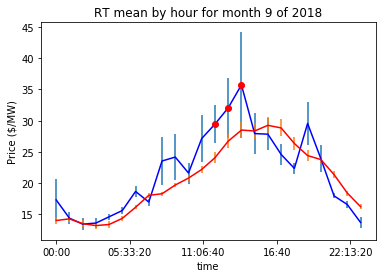

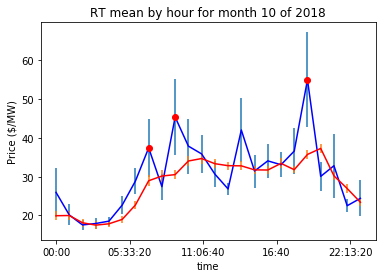

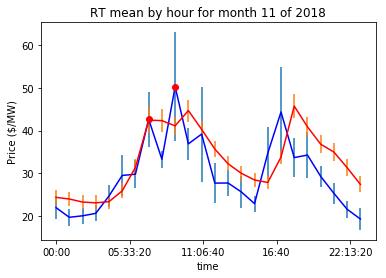

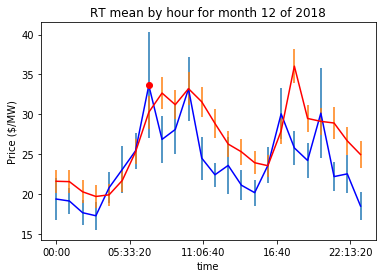

In [28]:
for n in range(1,13):
    by_month = DART2018[DART2018['Month']==float(n)]
    data1 = by_month.groupby('Hour')[['LMP_RT']].mean()
    data1['sem'] = by_month.groupby('Hour')[['LMP_RT']].sem()
    data1['Local Hour'] = data1.index
    time = data1.index
    
    fig, ax1 = plt.subplots()
    ax1.plot(time,data1['LMP_RT'],'blue')
    ax1.errorbar(time,data1['LMP_RT'], data1['sem'],
                 fmt='none')
    
    data2 = by_month.groupby('Hour')[['LMP_DA']].mean()
    data2['sem'] = by_month.groupby('Hour')[['LMP_DA']].sem()
    data2['Local Hour'] = data2.index
    time = data2.index
    
    ax1.plot(time,data2['LMP_DA'],'red')
    ax1.errorbar(time,data2['LMP_DA'], data2['sem'],
                 fmt='none')
    
    plt.plot(critical(data1)[0],critical(data1)[1],'ro')

    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [29]:
def critical2(df):
    intervals = df['Local Hour'].values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP_RT'][0:i+1].mean()
        if df['LMP_RT'][i] > 1.5*mean:
            if (df['LMP_RT'][i] - mean) > df['LMP_RT'].mean()/3:
                if df['LMP_RT'][i] > 1.1*df['LMP_DA'][i]:
                    points.append(time)
        elif df['LMP_RT'][i] > 1.3*df['LMP_DA'][i]:
            points.append(time)
        i += 1
    x = np.array(points)
    
    i = 0
    LMP = []
    for time in df['Local Hour']:
        if time in x:
            LMP.append(df['LMP_RT'][i])
        i += 1
    y = np.array(LMP)
    
    return [x,y]

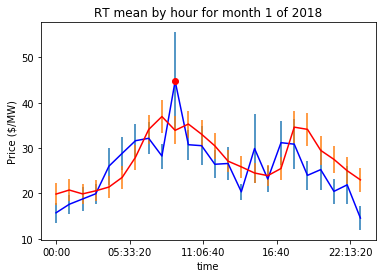

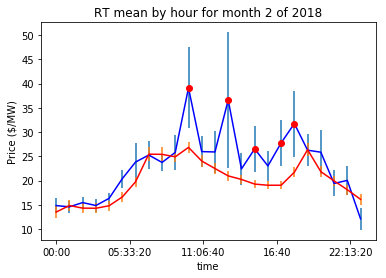

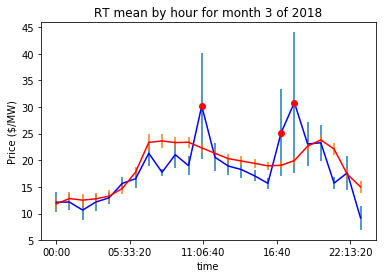

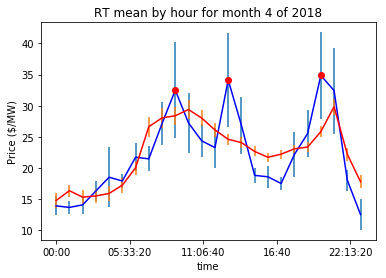

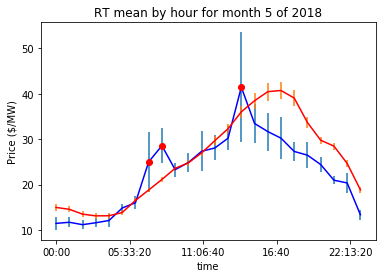

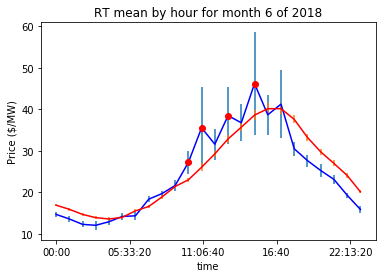

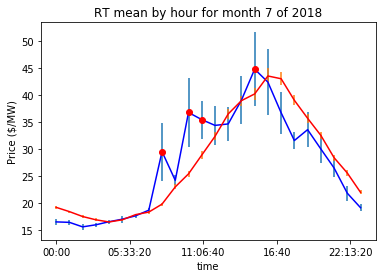

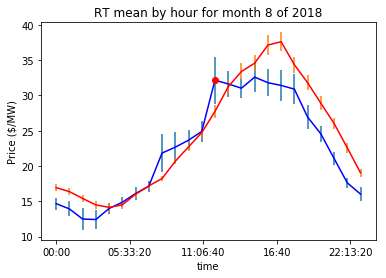

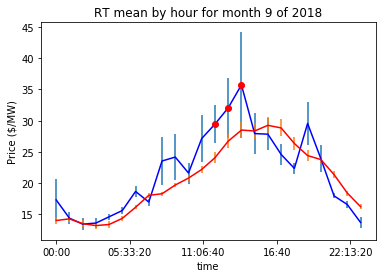

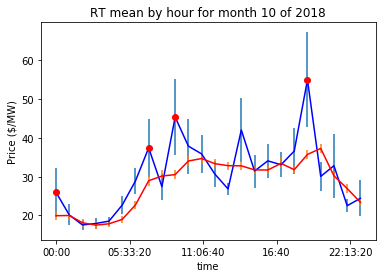

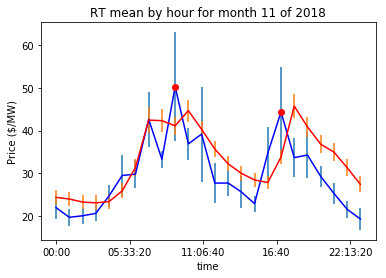

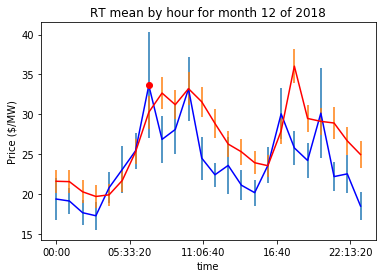

In [30]:
crit_hours = []

for n in range(1,13):
    by_month = DART2018[DART2018['Month']==float(n)]
    
    data = by_month.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    data['sem_RT'] = by_month.groupby('Hour')[['LMP_RT']].sem()
    data['sem_DA'] = by_month.groupby('Hour')[['LMP_DA']].sem()    
    data['Local Hour'] = data.index
    time = data1.index
    
    fig, ax1 = plt.subplots()
    ax1.plot(time, data['LMP_RT'], 'blue')
    ax1.errorbar(time, data['LMP_RT'], data['sem_RT'], fmt='none')
    
    ax1.plot(time, data['LMP_DA'], 'red')
    ax1.errorbar(time, data['LMP_DA'], data['sem_DA'], fmt='none')
    
    plt.plot(critical2(data)[0],critical2(data)[1],'ro')

    crit_hours.append(critical2(data)[0])
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [31]:
hours_list = []
for list_of_hours in crit_hours:
    for hour in list_of_hours:
        hours_list.append(hour)
hours_array = np.array(hours_list)
hours_df = pd.DataFrame({'Hour':hours_array})
hours_df.groupby('Hour')[['Hour']].count().sort_values('Hour',ascending=False).head()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 'Hour' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  import sys


Hour
Hour          
09:00:00     4
13:00:00     4
07:00:00     3
10:00:00     3
11:00:00     3

In [32]:
def ssr_split2(df, s):
    if df.shape[0]>8:
        smallest_y = 0
        smallest_x = 0
        for i in range(0, df.shape[0]):
            try:
                y_avg1 = df[s][0:i+1].values.mean()
                y_avg2 = df[s][i:df.shape[0]].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum() + ((df[s][i:df.shape[0]].values - y_avg2)**2).sum()
                if i == 0:
                    smallest_y = ssr
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
            except:
                y_avg1 = df[s].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum()
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
        smallest = df.iloc[0:smallest_x+1]
        largest = df.iloc[smallest_x+1:]
        if smallest.shape[0] > largest.shape[0]:
            temp = smallest
            smallest = largest
            largest = temp
        return [smallest] + [ssr_split2(largest, s)]
    else:
        return [df]

In [33]:
n = 2.0
split = ssr_split2(DART2018[DART2018['Month']==n].groupby('Hour')[['LMP_RT','LMP_DA']].mean(),'LMP_RT')

In [34]:
def clusters(nested):
    concat = []
    dfs = [nested[0],nested[1][0],nested[1][1][0],nested[1][1][1][0]]
    for df in dfs:
        means = np.empty(df.shape[0])
        means.fill(df['LMP_RT'].mean())
        df['Means'] = means
        concat.append(df)

    unnested = pd.concat(concat)
    unnested['Time'] = unnested.index
    unnested = unnested.sort_values('Time')
    return unnested

cl = clusters(split)
plt.plot(cl.index,cl['Means'])
jan = DART2018[DART2018['Month']==n]
data = jan.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
plt.plot(data.index,data['LMP_RT'])

for n in range(1,13):
    by_month = DART2018[DART2018['Month']==float(n)]
    
    data = by_month.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    data['sem_RT'] = by_month.groupby('Hour')[['LMP_RT']].sem()
    data['sem_DA'] = by_month.groupby('Hour')[['LMP_DA']].sem()    
    data['Local Hour'] = data.index
    time = data1.index
    
    fig, ax1 = plt.subplots()
    ax1.plot(time, data['LMP_RT'], 'blue')
    ax1.errorbar(time, data['LMP_RT'], data['sem_RT'], fmt='none')
    
    ax1.plot(time, data['LMP_DA'], 'red')
    ax1.errorbar(time, data['LMP_DA'], data['sem_DA'], fmt='none')
    
    plt.plot(critical2(data)[0],critical2(data)[1],'ro')

    cl = clusters(ssr_split2(data, 'LMP_RT'))
    plt.plot(cl.index,cl['Means'])
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [35]:
def ssr_split3(df, s):
    if df.shape[0]>8:
        smallest_y = 0
        smallest_x = 0
        for i in range(0, df.shape[0]):
            try:
                y_avg1 = df[s][0:i+1].values.mean()
                y_avg2 = df[s][i:df.shape[0]].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum() + ((df[s][i:df.shape[0]].values - y_avg2)**2).sum()
                if i == 0:
                    smallest_y = ssr
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
            except:
                y_avg1 = df[s].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum()
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
        smallest = df.iloc[0:smallest_x+1]
        largest = df.iloc[smallest_x+1:]
        if smallest.shape[0] > largest.shape[0]:
            temp = smallest
            smallest = largest
            largest = temp
        concat = [smallest] + [ssr_split2(largest, s)]
        return concat
    else:
        return df

In [36]:
def clusters2(nested):
    concat = []
    try:
        dfs = [nested[0],nested[1][0],nested[1][1][0],nested[1][1][1][0],nested[1][1][1][1][0],nested[1][1][1][1][1][0]]
    except:
        try:
            dfs = [nested[0],nested[1][0],nested[1][1][0],nested[1][1][1][0],nested[1][1][1][1][0]]
        except:
            try:
                dfs = [nested[0],nested[1][0],nested[1][1][0],nested[1][1][1][0]]
            except:
                try:
                    dfs = [nested[0],nested[1][0],nested[1][1][0]]
                except:
                    print('oops')
                    return None
    for df in dfs:
        means = np.empty(df.shape[0])
        means.fill(df['LMP_RT'].mean())
        df['Means'] = means
        concat.append(df)

    unnested = pd.concat(concat)
    unnested['Time'] = unnested.index
    unnested = unnested.sort_values('Time')
    return unnested

2

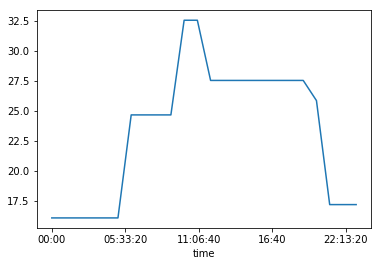

In [37]:
n = 2.0
split = ssr_split2(DART2018[DART2018['Month']==n].groupby('Hour')[['LMP_RT','LMP_DA']].mean(),'LMP_RT')
cl = clusters2(split)
plt.plot(cl.index,cl['Means'])
len(split[1])

In [38]:
def ssr(prediction, test):
    return ((prediction - test)**2).sum()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


421.3545063913462


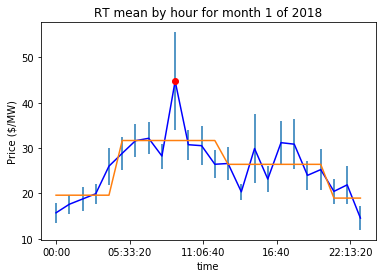

304.3583592029963


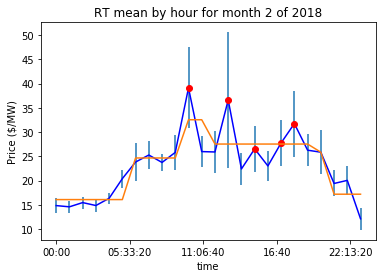

327.25117583763927


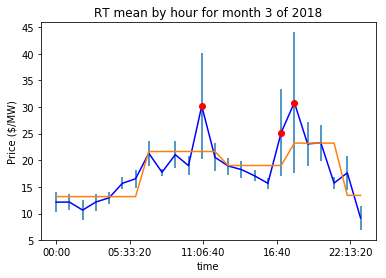

513.2456481924607


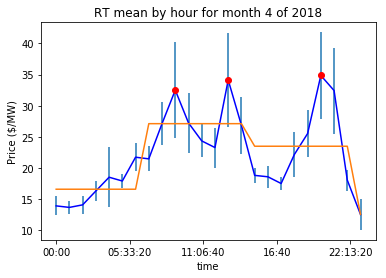

273.02525177377083


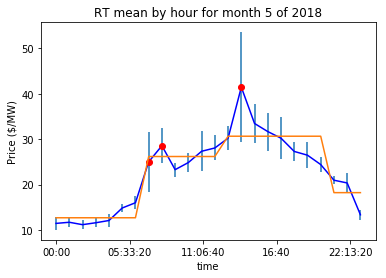

394.19210541611704


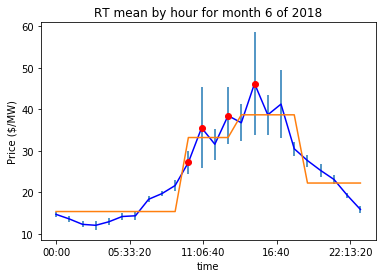

362.6383434823858


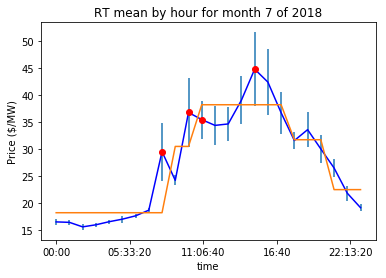

87.99999523833307


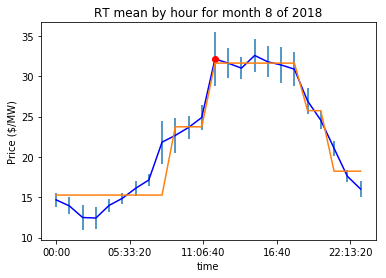

176.85808251972193


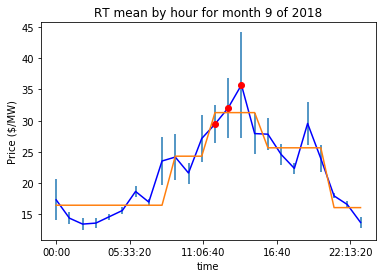

791.1134896833852


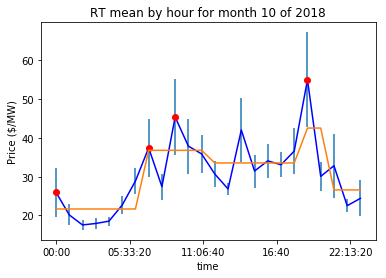

565.8784627750489


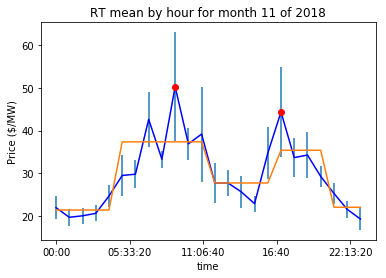

167.4839255513077


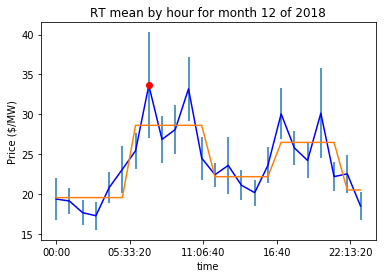

In [39]:
for n in range(1,13):
    by_month = DART2018[DART2018['Month']==float(n)]
    
    data = by_month.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    data['sem_RT'] = by_month.groupby('Hour')[['LMP_RT']].sem()
    data['sem_DA'] = by_month.groupby('Hour')[['LMP_DA']].sem()    
    data['Local Hour'] = data.index
    time = data.index
    
    fig, ax1 = plt.subplots()
    ax1.plot(time, data['LMP_RT'], 'blue')
    ax1.errorbar(time, data['LMP_RT'], data['sem_RT'], fmt='none')
    
    #ax1.plot(time, data['LMP_DA'], 'red')
    #ax1.errorbar(time, data['LMP_DA'], data['sem_DA'], fmt='none')
    
    plt.plot(critical2(data)[0],critical2(data)[1],'ro')

    cl = clusters2(ssr_split3(data, 'LMP_RT'))
    plt.plot(cl.index,cl['Means'])
    
    print(ssr(cl['Means'],data['LMP_RT']))
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [40]:
data = DART2018[DART2018['Month']==1.0]

In [41]:
train, test = train_test_split(data, test_size=0.33)

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


6.749472060833055


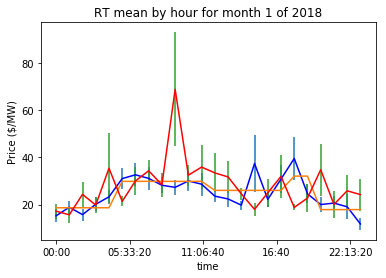

5.256874470324957


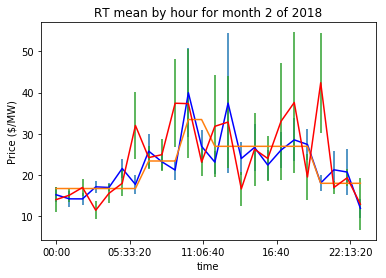

1.635969962880656


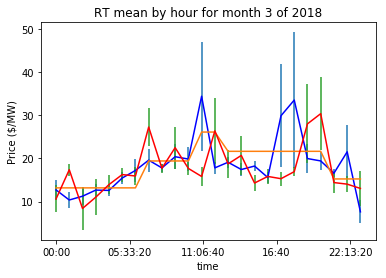

1.4943557711632045


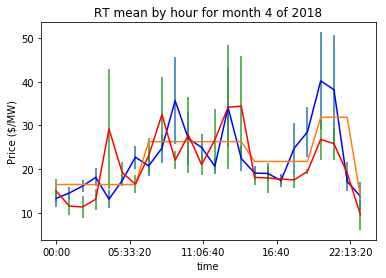

3.704656033163045


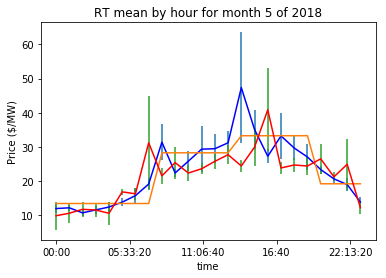

3.355910011067392


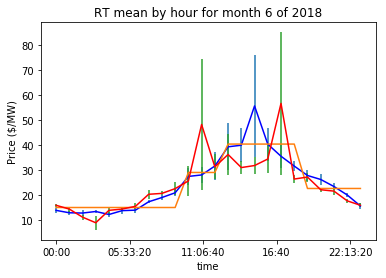

3.2320608346585993


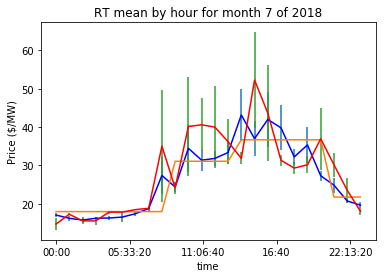

5.100283928427158


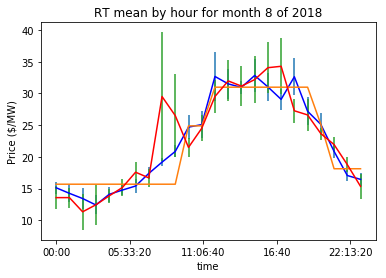

3.3280252255985956


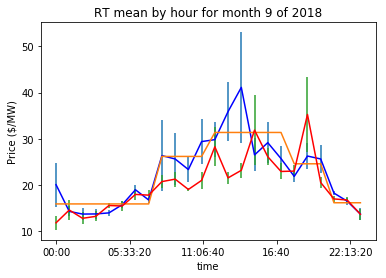

9.92843593225784


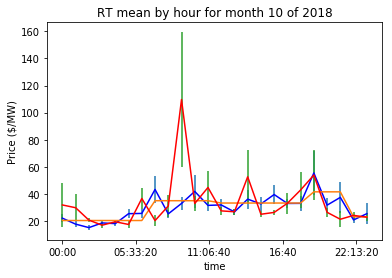

4.306703743696666


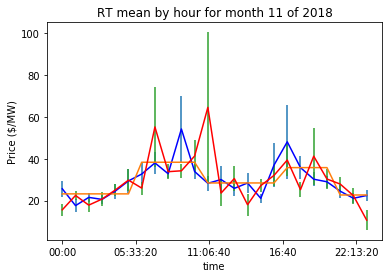

3.273081400961856


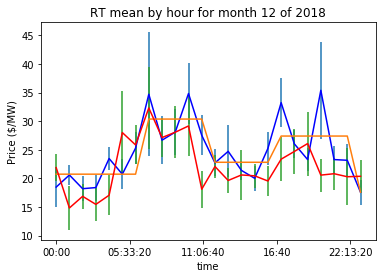

In [42]:
for n in range(1,13):
    by_month = DART2018[DART2018['Month']==float(n)]

    total_data = by_month.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    total_cl = clusters2(ssr_split3(total_data, 'LMP_RT'))
    
    train, test = train_test_split(by_month, test_size=0.33)
    
    train_data = train.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    train_data['sem_RT'] = train.groupby('Hour')[['LMP_RT']].sem()
    train_data['sem_DA'] = train.groupby('Hour')[['LMP_DA']].sem()    
    train_data['Local Hour'] = train_data.index
    time = train_data.index
    
    fig, ax1 = plt.subplots()
    ax1.plot(time, train_data['LMP_RT'], 'blue')
    ax1.errorbar(time, train_data['LMP_RT'], train_data['sem_RT'], fmt='none')
    
    #plt.plot(critical2(data)[0],critical2(data)[1],'ro')

    cl = clusters2(ssr_split3(train_data, 'LMP_RT'))
    plt.plot(cl.index,cl['Means'])
    
    test_data = test.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    test_data['sem_RT'] = test.groupby('Hour')[['LMP_RT']].sem()
    test_data['Local Hour'] = test_data.index
    time = test_data.index
    
    ax1.plot(time, test_data['LMP_RT'], 'red')
    ax1.errorbar(time, test_data['LMP_RT'], test_data['sem_RT'], fmt='none')
    
    print(ssr(cl['Means'],test_data['LMP_RT'])/ssr(total_cl['Means'],total_data['LMP_RT']))
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [119]:
def experiment(n):
    exp_array = np.empty(n)
    for i in range(n):
        year_ssr = []
        for j in range(1,13):
            by_month = DART2018[DART2018['Month']==float(j)]

            total_data = by_month.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
            total_cl = clusters2(ssr_split3(total_data, 'LMP_RT'))

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Hour')[['LMP_RT','LMP_DA']].mean() 

            cl = clusters2(ssr_split3(train_data, 'LMP_RT'))

            test_data = test.groupby('Hour')[['LMP_RT','LMP_DA']].mean()

            year_ssr.append(ssr(cl['Means'],test_data['LMP_RT'])/ssr(total_cl['Means'],total_data['LMP_RT']))
        exp_array[i] = sum(year_ssr)/len(year_ssr)
    return exp_array

In [120]:
#array = experiment(10)
#array.mean()

In [40]:
# RT prediction based only on DA (grouping by hour)

jan = DART2018[DART2018['Month']==1.0].groupby('Hour')[['LMP_RT','LMP_DA']].mean()
result = smf.ols(formula="LMP_RT ~ LMP_DA", data=jan).fit()
jan['fitted'] = result.predict()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LMP_RT   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     15.95
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           0.000613
Time:                        15:16:42   Log-Likelihood:                -72.638
No. Observations:                  24   AIC:                             149.3
Df Residuals:                      22   BIC:                             151.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0854      5.543      0.737      0.469      -7.410      15.581
LMP_DA         0.7921      0.198      3.993      0.001       0.381       1.203
==============================================================================
Omnibus:                        4.526   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                2.866
Skew:                           0.813   Prob(JB):                        0.239
Kurtosis:                       3.471   Cond. No.                         146.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# RT prediction based only on DA (NOT grouping by hour)

jan = DART2018[DART2018['Month']==1.0]
result = smf.ols(formula="LMP_RT ~ LMP_DA", data=jan).fit()
jan['fitted'] = result.predict()
result.params

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Intercept    2.378595
LMP_DA       0.854514
dtype: float64

In [42]:
# RT prediction based only on DA, but with training and testing split

jan = DART2018[DART2018['Month']==1.0].groupby('Hour')[['LMP_RT','LMP_DA']].mean()
train, test = train_test_split(jan, test_size=0.33)

corr, _ = stats.pearsonr(train['LMP_RT'], train['LMP_DA'])
DA_std = np.std(train['LMP_DA'], ddof=1)
RT_std = np.std(train['LMP_RT'], ddof=1)
DA_mean = np.mean(train['LMP_DA'])
RT_mean = np.mean(train['LMP_RT'])

slope = corr*RT_std/DA_std  
intercept = RT_mean - slope * DA_mean

test['fitted RT'] = test['LMP_DA']*slope + intercept
test

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


LMP_RT     LMP_DA  fitted RT
Hour                                     
05:00:00  28.840849  23.531309  21.868604
08:00:00  28.239776  36.945731  34.710977
07:00:00  32.149545  34.084355  31.971622
04:00:00  26.010714  21.403589  19.831619
06:00:00  31.613055  27.952063  26.100838
01:00:00  17.599159  20.740219  19.196538
11:00:00  30.518858  33.040974  30.972735
21:00:00  20.447666  27.500340  25.668378

In [43]:
ssr(test['fitted RT'],test['LMP_RT'])

189.09951906606284

In [47]:
clusters_ssr = []
linear_ssr = []
for j in range(1,13):
    by_month = DART2018[DART2018['Month']==float(j)]

    train, test = train_test_split(by_month, test_size=0.33)

    train_data = train.groupby('Hour')[['LMP_RT','LMP_DA']].mean() 

    cl = clusters2(ssr_split3(train_data, 'LMP_RT'))

    test_data = test.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    
    clusters_ssr.append(ssr(cl['Means'],test_data['LMP_RT']))
    
    result = smf.ols(formula="LMP_RT ~ LMP_DA", data=train_data).fit()
    test_data['fitted RT'] = test_data['LMP_DA']*result.params[1] + result.params[0]
    
    linear_ssr.append(ssr(test_data['fitted RT'], test_data['LMP_RT']))
    


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [126]:
np.array(linear_ssr).mean()

1175.624012249986

In [127]:
np.array(clusters_ssr).mean()

1558.027454962091

In [128]:
clusters_array = np.empty(10)
linear_array = np.empty(10)
for i in range(10):
    clusters_ssr = []
    linear_ssr = []
    for j in range(1,13):
        by_month = DART2018[DART2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA']].mean() 

        cl = clusters2(ssr_split3(train_data, 'LMP_RT'))

        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA']].mean()

        clusters_ssr.append(ssr(cl['Means'],test_data['LMP_RT']))

        result = smf.ols(formula="LMP_RT ~ LMP_DA", data=train_data).fit()
        test_data['fitted RT'] = test_data['LMP_DA']*result.params[1] + result.params[0]

        linear_ssr.append(ssr(test_data['fitted RT'], test_data['LMP_RT']))
    clusters_array[i] = np.array(clusters_ssr).mean()
    linear_array[i] = np.array(linear_ssr).mean()
    

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [129]:
clusters_array.mean()

1621.0079194247317

In [130]:
linear_array.mean()

1401.6805760938382

In [131]:
# linear fit smf.ols seems to perform better

###### Editing 2018 load dataframe

In [132]:
gen_mix_2018.head()

GMT MKT Interval   Coal Market   Coal Self   Diesel Fuel Oil Market  \
0  2018-01-01T06:00:00Z        2948.5     18203.9                      0.0   
1  2018-01-01T06:05:00Z        2917.3     18191.4                      0.0   
2  2018-01-01T06:10:00Z        2916.5     18181.4                      0.0   
3  2018-01-01T06:15:00Z        2913.0     18159.0                      0.0   
4  2018-01-01T06:20:00Z        2911.5     18154.1                      0.0   

    Diesel Fuel Oil Self   Hydro Market   Hydro Self   Natural Gas Market  \
0                    4.4           43.1        759.6               5903.9   
1                    4.4           43.3        775.3               5842.2   
2                    0.0           43.8        802.2               5983.2   
3                    0.0           43.8        776.5               6116.0   
4                    0.0           43.3        713.7               6182.6   

    Gas Self   Nuclear Market     ...       Waste Disposal Services Self  \
0     3447.6              0.0     ...                               10.8   
1     3468.0              0.0     ...                               10.9   
2     3479.6              0.0     ...                               11.0   
3     3385.1              0.0     ...                               10.9   
4     3438.3              0.0     ...                               10.9   

    Wind Market   Wind Self   Waste Heat Market   Waste Heat Self  \
0           0.0      3643.1                 0.0               0.0   
1           0.0      3619.8                 0.0               0.0   
2           0.0      3578.9                 0.0               0.0   
3           0.0      3539.2                 0.0               0.0   
4           0.0      3515.1                 0.0               0.0   

    Other Market   Other Self   Average Actual Load  Local Date  Local Time  
0            0.0         27.1             36439.754  2018-01-01    00:00:00  
1            0.0         27.3             36389.511  2018-01-01    00:05:00  
2            0.0         27.0             36386.829  2018-01-01    00:10:00  
3            0.0         26.9             36290.426  2018-01-01    00:15:00  
4            0.0         27.3             36225.646  2018-01-01    00:20:00  

[5 rows x 24 columns]

In [44]:
load_2018 = gen_mix_2018.iloc[:,21:24]
load_2018.head()

Average Actual Load  Local Date Local Time
0             36439.754  2018-01-01   00:00:00
1             36389.511  2018-01-01   00:05:00
2             36386.829  2018-01-01   00:10:00
3             36290.426  2018-01-01   00:15:00
4             36225.646  2018-01-01   00:20:00

In [45]:
hour = []
month = []
day = []
intervals = load_2018['Local Time'].values.tolist()
for time in intervals:
    hour.append(time.hour)    
intervals = load_2018['Local Date'].values.tolist()
for date in intervals:
    month.append(date.month)
    day.append(date.day)
load_2018['Hour'] = np.array(hour)
load_2018['Day'] = np.array(day)
load_2018['Month'] = np.array(month)
load_2018.tail()

Average Actual Load  Local Date Local Time  Hour  Day  Month
104869             30400.052  2018-12-31   23:35:00    23   31     12
104870             30401.893  2018-12-31   23:40:00    23   31     12
104871             30246.725  2018-12-31   23:45:00    23   31     12
104872             30222.304  2018-12-31   23:50:00    23   31     12
104873             30130.697  2018-12-31   23:55:00    23   31     12

In [46]:
load_dfs = []
days_31 = []
for n in range(1,32):
    days_31.append(n)
cal_dict = {1:days_31,
            2:days_31[0:28],
            3:days_31,
            4:days_31[0:-1],
            5:days_31,
            6:days_31[0:-1],
            7:days_31,
            8:days_31,
            9:days_31[0:-1],
            10:days_31,
            11:days_31[0:-1],
            12:days_31}
for key in cal_dict.keys():
    for value in cal_dict[key]:
        day_df = load_2018[(load_2018['Month']==key)&(load_2018['Day']==value)]
        load_dfs.append(day_df.groupby('Hour')[['Local Date','Local Time',' Average Actual Load']].agg({
                                                                                                'Local Date':'first',
                                                                                                'Local Time':'first',
                                                                                                ' Average Actual Load':'mean'}))
load2018_hour = pd.concat(load_dfs)

In [47]:
new_index = []
hour = []
for i in range(load2018_hour.shape[0]):
    hour.append(load2018_hour['Local Time'].iloc[i].hour)
    new_index.append(load2018_hour['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + load2018_hour['Local Time'].iloc[i].strftime("%H:%M:%S"))
load2018_hour.index = np.array(new_index)
load2018_hour['Hour'] = np.array(hour)
load2018_hour.head()

Local Date Local Time   Average Actual Load  Hour
01/01/2018 00:00:00  2018-01-01   00:00:00          36264.617167     0
01/01/2018 01:00:00  2018-01-01   01:00:00          36094.722000     1
01/01/2018 02:00:00  2018-01-01   02:00:00          36045.346000     2
01/01/2018 03:00:00  2018-01-01   03:00:00          36047.534667     3
01/01/2018 04:00:00  2018-01-01   04:00:00          36350.962167     4

In [48]:
DART2018.index[1]==load2018_hour.index[1]

True

In [49]:
DART_load_2018 = DART2018.join(load2018_hour,how='right',lsuffix='_price',rsuffix='_load')

In [50]:
DART_load_2018 = DART2018.join(load2018_hour,how='right',lsuffix='_price',rsuffix='_load')
DART_load_2018 = DART_load_2018.drop(DART_load_2018.columns[[0,2,3,4,8]],axis=1)
DART_load_2018 = DART_load_2018.rename(columns={'Local Date_load':'Local Date',
                                                'Local Time_load':'Local Time',
                                                ' Average Actual Load':'Load',
                                                'Hour_load':'Hour'})
DART_load_2018.head()

LMP_DA Weekday  Month  Day      LMP_RT  Local Date  \
01/01/2018 00:00:00        NaN     NaN    NaN  NaN         NaN  2018-01-01   
01/01/2018 01:00:00  37.390157    True    1.0  1.0   28.641704  2018-01-01   
01/01/2018 02:00:00  37.249877    True    1.0  1.0   50.201946  2018-01-01   
01/01/2018 03:00:00  37.998882    True    1.0  1.0   28.285259  2018-01-01   
01/01/2018 04:00:00  40.778408    True    1.0  1.0  122.022561  2018-01-01   

                    Local Time          Load  Hour  
01/01/2018 00:00:00   00:00:00  36264.617167     0  
01/01/2018 01:00:00   01:00:00  36094.722000     1  
01/01/2018 02:00:00   02:00:00  36045.346000     2  
01/01/2018 03:00:00   03:00:00  36047.534667     3  
01/01/2018 04:00:00   04:00:00  36350.962167     4

In [51]:
jan = DART_load_2018[DART_load_2018['Month']==1.0].groupby('Hour')[['LMP_RT','LMP_DA', 'Load']].mean()
train, test = train_test_split(jan, test_size=0.33)

result2 = smf.ols(formula="LMP_RT ~ LMP_DA + Load", data=train).fit()

test['fitted RT'] = test['Load']*result2.params[2] + test['LMP_DA']*result2.params[1] + result2.params[0]

test

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


LMP_RT     LMP_DA          Load  fitted RT
Hour                                               
5     28.840849  23.531309  31919.725366  24.336823
12    26.424536  30.480820  32277.634070  25.912862
0     15.722089  19.849852  30218.196298  19.996713
11    30.518858  33.040974  33048.757182  27.975534
17    31.182332  25.488573  32427.254419  25.723645
1     17.707140  20.618330  30022.106392  19.624627
14    20.348134  25.850283  31127.994108  22.750319
13    26.591573  27.102917  31664.747392  24.129227

In [52]:
ssr(test['fitted RT'], test['LMP_RT'])

90.59662775523552

In [53]:
n = 20
clusters_array = np.empty(n)
linear_array = np.empty(n)
multiple_array = np.empty(n)
for i in range(n):
    clusters_ssr = []
    linear_ssr = []
    multiple_ssr = []
    for j in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        
        cl = clusters2(ssr_split3(train_data, 'LMP_RT'))
        clusters_ssr.append(ssr(cl['Means'],test_data['LMP_RT']))

        result = smf.ols(formula="LMP_RT ~ LMP_DA", data=train_data).fit()
        test_data['fitted RT'] = test_data['LMP_DA']*result.params[1] + result.params[0]
        linear_ssr.append(ssr(test_data['fitted RT'], test_data['LMP_RT']))
        
        result2 = smf.ols(formula="LMP_RT ~ LMP_DA + Load", data=train_data).fit()

        test_data['fitted RT (2)'] = test_data['Load']*result2.params[2] + test_data['LMP_DA']*result2.params[1] + result2.params[0]
        multiple_ssr.append(ssr(test_data['fitted RT (2)'], test_data['LMP_RT']))

        
        
    clusters_array[i] = np.array(clusters_ssr).mean()
    linear_array[i] = np.array(linear_ssr).mean()
    multiple_array[i] = np.array(multiple_ssr).mean()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [54]:
clusters_array.mean(), linear_array.mean(), multiple_array.mean()

(1542.8446988573478, 1297.2797604252912, 1257.1046409888781)

In [55]:
result.rsquared, result.rsquared_adj

(0.695511878942919, 0.6816715098039607)

In [125]:
def offset(prediction, test):
    return (abs((prediction - test)/test))*100

In [145]:
n = 20
off = np.empty(n)
for i in range(n):
    multiple_offset = []
    for j in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        
        result2 = smf.ols(formula="LMP_RT ~ LMP_DA + Load", data=train_data).fit()

        test_data['fitted RT (2)'] = test_data['Load']*result2.params[2] + test_data['LMP_DA']*result2.params[1] + result2.params[0]
        multiple_offset.append(offset(test_data['fitted RT (2)'], test_data['LMP_RT']))
    off[i] = np.array(multiple_offset).mean()


In [146]:
off.mean()

17.991014844804607

In [147]:
n = 20
clusters_array = np.empty(n)
linear_array = np.empty(n)
multiple_array = np.empty(n)
for i in range(n):
    clusters_offset = []
    linear_offset = []
    multiple_offset = []
    for j in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        
        cl = clusters2(ssr_split3(train_data, 'LMP_RT'))
        clusters_offset.append(offset(cl['Means'],test_data['LMP_RT']))

        result = smf.ols(formula="LMP_RT ~ LMP_DA", data=train_data).fit()
        test_data['fitted RT'] = test_data['LMP_DA']*result.params[1] + result.params[0]
        linear_offset.append(offset(test_data['fitted RT'], test_data['LMP_RT']))
        
        result2 = smf.ols(formula="LMP_RT ~ LMP_DA + Load", data=train_data).fit()

        test_data['fitted RT (2)'] = test_data['Load']*result2.params[2] + test_data['LMP_DA']*result2.params[1] + result2.params[0]
        multiple_offset.append(offset(test_data['fitted RT (2)'], test_data['LMP_RT']))

        
    clusters_array[i] = np.array(clusters_offset).mean()
    linear_array[i] = np.array(linear_offset).mean()
    multiple_array[i] = np.array(multiple_offset).mean()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [148]:
np.nanmean(clusters_array), linear_array.mean(), multiple_array.mean()

(21.196873511195605, 17.911601979441226, 17.79724536897997)

In [149]:
#### try adding std as predictors

In [150]:
multiple_offset = []
for j in range(1,13):
    by_month = DART_load_2018[DART_load_2018['Month']==float(j)]

    train, test = train_test_split(by_month, test_size=0.33)
    train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
    train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
    test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
    test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()
    
    result3 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem", data=train_data).fit()

    test_data['fitted RT (3)'] = test_data['RT_sem']*result3.params[3] + test_data['Load']*result3.params[2] + test_data['LMP_DA']*result3.params[1] + result3.params[0]
    multiple_offset.append(offset(test_data['fitted RT (3)'], test_data['LMP_RT']))
np.array(multiple_offset).mean()

12.642378818377331

In [151]:
n = 30
predict3 = np.empty(n)
for i in range(n):
    multiple_offset = list()
    for j in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        result3 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem", data=train_data).fit()

        test_data['fitted RT (3)'] = test_data['RT_sem']*result3.params[3] + test_data['Load']*result3.params[2] + test_data['LMP_DA']*result3.params[1] + result3.params[0]
        multiple_offset.append(offset(test_data['fitted RT (3)'], test_data['LMP_RT']))
    predict3[i] = np.array(multiple_offset).mean()
predict3.mean()

nan

In [152]:
predict3.std()

nan

In [53]:
# 3 predictors, comparing by hour

d = {}
for n in range(24):
    d[n] = []

for rep in range(20):
    for i in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(i)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        result3 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem", data=train_data).fit()

        test_data['fitted RT (3)'] = test_data['RT_sem']*result3.params[3] + test_data['Load']*result3.params[2] + test_data['LMP_DA']*result3.params[1] + result3.params[0]
        hour_offset = offset(test_data['fitted RT (3)'], test_data['LMP_RT'])
        for hour in hour_offset.index:
            d[hour].append(hour_offset.iloc[hour])

means_d = {}
for key in d.keys():
    means_d[key] = np.array(d[key]).mean()
m = []
for value in means_d.values():
    m.append(value)
#np.array(m).mean()
means_d

{0: 18.942149736460074,
 1: 13.72604890194212,
 2: 22.850309089310734,
 3: 16.918346678463404,
 4: 14.768311395626572,
 5: 9.771138935470294,
 6: 9.777305846235148,
 7: 10.700172316344865,
 8: 10.309159761735888,
 9: 9.734487366864292,
 10: 11.390930216516335,
 11: 10.761526691207786,
 12: 11.655468251358354,
 13: 10.321620231624118,
 14: 10.635863641823244,
 15: 11.83984821089401,
 16: 8.182384607779758,
 17: 9.44311084823348,
 18: 10.93911513245919,
 19: 11.840247563997838,
 20: 11.415615271602713,
 21: 13.467118969073104,
 22: 13.120238693459191,
 23: 36.05434997838719}

In [54]:
np.array(m).mean()


13.273536180702905

In [155]:
n = 100
clusters_array = np.empty(n)
linear_array = np.empty(n)
multiple_array = np.empty(n)
multiple3_array = np.empty(n)
for i in range(n):
    clusters_offset = []
    linear_offset = []
    multiple_offset = []
    multiple3_offset = []
    for j in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()
        
        cl = clusters2(ssr_split3(train_data, 'LMP_RT'))
        clusters_offset.append(offset(cl['Means'],test_data['LMP_RT']))

        result = smf.ols(formula="LMP_RT ~ LMP_DA", data=train_data).fit()
        test_data['fitted RT'] = test_data['LMP_DA']*result.params[1] + result.params[0]
        linear_offset.append(offset(test_data['fitted RT'], test_data['LMP_RT']))
        
        result2 = smf.ols(formula="LMP_RT ~ LMP_DA + Load", data=train_data).fit()

        test_data['fitted RT (2)'] = test_data['Load']*result2.params[2] + test_data['LMP_DA']*result2.params[1] + result2.params[0]
        multiple_offset.append(offset(test_data['fitted RT (2)'], test_data['LMP_RT']))

        result3 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem", data=train_data).fit()
        test_data['fitted RT (3)'] = test_data['RT_sem']*result3.params[3] + test_data['Load']*result3.params[2] + test_data['LMP_DA']*result3.params[1] + result3.params[0]
        multiple3_offset.append(offset(test_data['fitted RT (3)'], test_data['LMP_RT']))
        
        
    clusters_array[i] = np.array(clusters_offset).mean()
    linear_array[i] = np.array(linear_offset).mean()
    multiple_array[i] = np.array(multiple_offset).mean()
    multiple3_array[i] = np.array(multiple3_offset).mean()
    if i%10 == 0:
        print('{}%'.format(i))

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


In [156]:
np.nanmean(clusters_array), linear_array.mean(), multiple_array.mean(), np.nanmean(multiple3_array)

(21.649669578926463, 18.56587479714838, 18.457047257852125, 13.326082959899503)

In [157]:
#100 tests, pretty confident result

In [158]:
# 3 predictors, comparing by hour

d = {}
for n in range(24):
    d[n] = []

for rep in range(1000):
    for i in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(i)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        result3 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem", data=train_data).fit()

        test_data['fitted RT (3)'] = test_data['RT_sem']*result3.params[3] + test_data['Load']*result3.params[2] + test_data['LMP_DA']*result3.params[1] + result3.params[0]
        hour_offset = offset(test_data['fitted RT (3)'], test_data['LMP_RT'])
        for hour in hour_offset.index:
            d[hour].append(hour_offset.loc[hour])
    if rep%100 == 0:
        print('{}%...'.format(rep/10))

means_d = {}
for key in d.keys():
    means_d[key] = np.nanmean(np.array(d[key]))
m = []
for value in means_d.values():
    m.append(value)
means_d

0.0%...
10.0%...
20.0%...
30.0%...
40.0%...
50.0%...
60.0%...
70.0%...
80.0%...
90.0%...


{0: 19.446545786294635,
 1: 13.965075737268577,
 2: 16.55175209383281,
 3: 16.37944728902191,
 4: 13.489114390550798,
 5: 10.541674274869777,
 6: 10.669270139557607,
 7: 9.430755124012324,
 8: 10.352702119926494,
 9: 10.06000197119836,
 10: 10.440107502227104,
 11: 10.89645582215499,
 12: 10.228872235986039,
 13: 10.394066862481386,
 14: 10.888916459041557,
 15: 10.861334600964103,
 16: 9.140873373549324,
 17: 8.481708382518491,
 18: 10.477821571964423,
 19: 11.602648136969217,
 20: 11.785606683241884,
 21: 14.274745910205224,
 22: 13.363832229531722,
 23: 77.63626764670398}

In [159]:
np.array(m).mean()


14.639983181003032

In [160]:
# 4 predictors, comparing by hour

d = {}
for n in range(24):
    d[n] = []

for rep in range(20):
    for i in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(i)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        train_data['Load_sem'] = train.groupby('Hour')[['Load']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()
        test_data['Load_sem'] = test.groupby('Hour')[['Load']].sem()
        
        result4 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Load_sem", data=train_data).fit()

        test_data['fitted RT (4)'] = test_data['Load_sem']*result4.params[4] + test_data['RT_sem']*result4.params[3] + test_data['Load']*result4.params[2] + test_data['LMP_DA']*result4.params[1] + result4.params[0]
        hour_offset = offset(test_data['fitted RT (4)'], test_data['LMP_RT'])
        for hour in hour_offset.index:
            d[hour].append(hour_offset.iloc[hour])

means_d = {}
for key in d.keys():
    means_d[key] = np.array(d[key]).mean()
m = []
for value in means_d.values():
    m.append(value)
#np.array(m).mean()
means_d

{0: 19.767902727531713,
 1: 17.018428315214162,
 2: 19.101651979615667,
 3: 17.78111964598298,
 4: 14.780243395052333,
 5: 10.931468253910221,
 6: 13.519884256637575,
 7: 13.040364494324017,
 8: 12.274129243220793,
 9: 11.82597295841595,
 10: 11.66584382733236,
 11: 11.893461506109691,
 12: 12.232082922395541,
 13: 12.044926233721931,
 14: 12.904202990183576,
 15: 12.229615485469598,
 16: 10.078924692728462,
 17: 9.6540033049322,
 18: 12.128978876257952,
 19: 12.55068683095905,
 20: 12.847723603974494,
 21: 15.909130232973068,
 22: 15.000419086188003,
 23: 43.20748708866865}

In [161]:
np.array(m).mean()


14.766193831325

In [162]:
d = {}
for n in range(24):
    d[n] = []

for rep in range(20):
    for i in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(i)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        train_data['Load_sem'] = train.groupby('Hour')[['Load']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()
        test_data['Load_sem'] = test.groupby('Hour')[['Load']].sem()
        
        result4 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + I(Load**2)", data=train_data).fit()

        test_data['fitted RT (4)'] = (test_data['Load']**2)*result4.params[4] + test_data['RT_sem']*result4.params[3] + test_data['Load']*result4.params[2] + test_data['LMP_DA']*result4.params[1] + result4.params[0]
        hour_offset = offset(test_data['fitted RT (4)'], test_data['LMP_RT'])
        for hour in hour_offset.index:
            d[hour].append(hour_offset.iloc[hour])

means_d = {}
for key in d.keys():
    means_d[key] = np.array(d[key]).mean()
m = []
for value in means_d.values():
    m.append(value)
#np.array(m).mean()
means_d

{0: 18.120650097389913,
 1: 16.764700758655334,
 2: 18.120504099138966,
 3: 15.513753313817668,
 4: 13.016715104455297,
 5: 10.594806687739394,
 6: 10.178297503882185,
 7: 10.101624022050117,
 8: 10.662178413657978,
 9: 10.219620689989984,
 10: 10.216265643925437,
 11: 9.968860142212396,
 12: 11.437745753132292,
 13: 11.732598350723077,
 14: 11.434000850321471,
 15: 11.302535253074295,
 16: 9.406295198540233,
 17: 8.432660193911095,
 18: 10.413255683870796,
 19: 12.290920810978577,
 20: 11.726416320049841,
 21: 13.662648178579678,
 22: 12.486080840158847,
 23: 46.362011714612464}

In [163]:
np.nanmean(m)

13.506881067702807

In [164]:
d = {}
for n in range(24):
    d[n] = []

for rep in range(100):
    for i in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(i)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        result4 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + I(Load**2)", data=train_data).fit()

        test_data['fitted RT (4)'] = (test_data['Load']**2)*result4.params[4] + test_data['RT_sem']*result4.params[3] + test_data['Load']*result4.params[2] + test_data['LMP_DA']*result4.params[1] + result4.params[0]
        hour_offset = offset(test_data['fitted RT (4)'], test_data['LMP_RT'])
        for hour in hour_offset.index:
            d[hour].append(hour_offset.iloc[hour])
    if rep%10 == 0:
        print('{}%...'.format(rep))

means_d = {}
for key in d.keys():
    means_d[key] = np.nanmean(np.array(d[key]))
m = []
for value in means_d.values():
    m.append(value)
means_d

0%...
10%...
20%...
30%...
40%...
50%...
60%...
70%...
80%...
90%...


{0: 20.672590435447546,
 1: 14.10789320473954,
 2: 18.649247555533094,
 3: 16.73609440196005,
 4: 13.60937876350796,
 5: 10.688789177429827,
 6: 11.316016754248745,
 7: 10.351174230880138,
 8: 10.183642183684784,
 9: 10.563323250435545,
 10: 10.385934438484206,
 11: 10.96861701695424,
 12: 10.729953084142933,
 13: 10.128275766634149,
 14: 11.361403041324932,
 15: 11.29294180735913,
 16: 9.910637688774175,
 17: 9.086025880483323,
 18: 10.777921501745407,
 19: 12.223719095743197,
 20: 12.17622308947253,
 21: 14.418834677038097,
 22: 13.20843568259212,
 23: 42.537795632382064}

In [165]:
np.array(m).mean()

13.58686951504157

Adding predictors seems to have diminishing returns. We can try several different combinations of adding predictors with different orders, but so far method (3) seems to be the best one (DA, Load and RT_sem)

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


109.806018816855
57.3532838374256


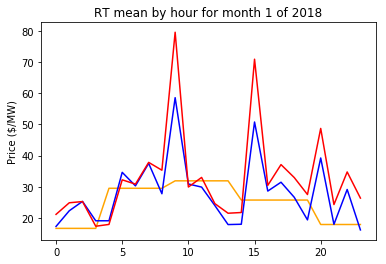

111.19818902948963
11.140841932229963


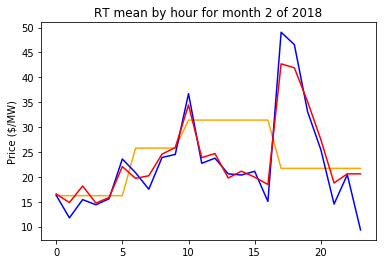

106.81072869409756
21.38876364905849


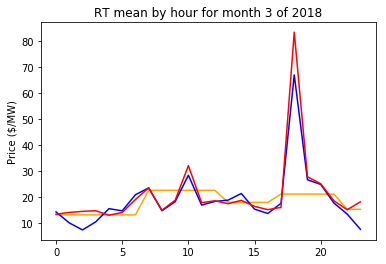

60.3288588087459
30.058283301079516


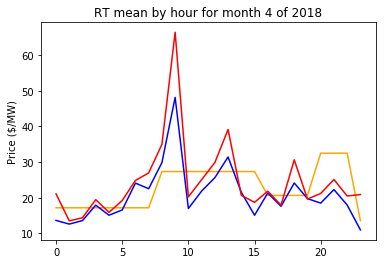

121.04924967340412
20.982110161870022


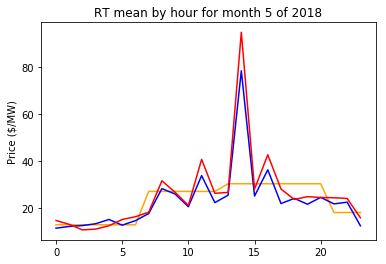

45.12317676623022
6.870527348912166


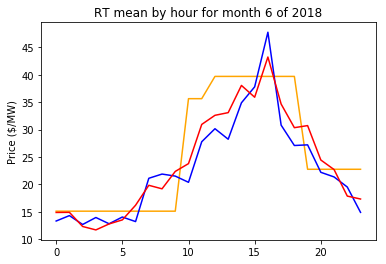

80.90122535062041
32.86177922461483


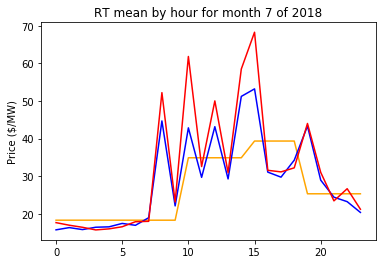

11.261107841572255
4.299059846553991


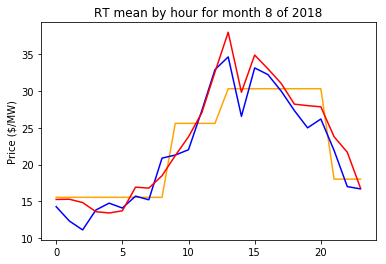

10.343408878100712
2.7794340524869536


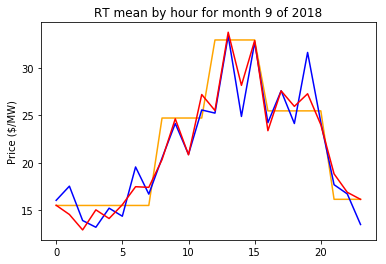

33.74416850912829
67.7827677250934


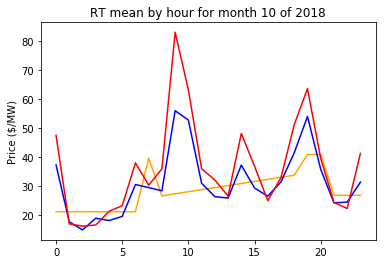

139.55760862207285
26.356527917293544


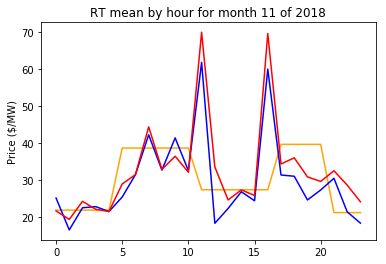

30.34668712922027
37.99907417750363


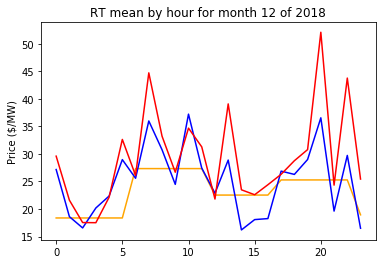

In [166]:
for n in range(1,13):
    by_month = DART_load_2018[DART_load_2018['Month']==float(n)]
    
    train, test = train_test_split(by_month, test_size=0.33)
    
    train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
    train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
    train_data['Local Hour'] = train_data.index
    time = train_data.index
    
    fig, ax1 = plt.subplots()

    cl = clusters2(ssr_split3(train_data, 'LMP_RT'))
    ax1.plot(cl.index,cl['Means'], 'orange')
    
    test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
    test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()
    test_data['Local Hour'] = test_data.index
    time = test_data.index
    
    ax1.plot(time, test_data['LMP_RT'], 'blue')
    #ax1.errorbar(time, test_data['LMP_RT'], test_data['RT_sem'], fmt='none')
    
    print(ssr(cl['Means'],test_data['LMP_RT'])/test_data.shape[0])
    
    result3 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem", data=train_data).fit()
    test_data['fitted RT (3)'] = test_data['RT_sem']*result3.params[3] + test_data['Load']*result3.params[2] + test_data['LMP_DA']*result3.params[1] + result3.params[0]
    ax1.plot(time, test_data['fitted RT (3)'], 'red')

    print(ssr(test_data['fitted RT (3)'],test_data['LMP_RT'])/test_data.shape[0])
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [167]:
# End of the day simulation: best fit from sklearn vs own method
# measuring offset and ssr

n = 20
clusters_array = np.empty(n)
multiple_array = np.empty(n)
clusters_array2 = np.empty(n)
multiple_array2 = np.empty(n)
for i in range(n):
    clusters_offset = []
    multiple_offset = []
    clusters_ssr = []
    multiple_ssr = []
    for j in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem() 
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem() 
        
        cl = clusters2(ssr_split3(train_data, 'LMP_RT'))
        clusters_offset.append(offset(cl['Means'],test_data['LMP_RT']))
        clusters_ssr.append(ssr(cl['Means'],test_data['LMP_RT']))

        
        result3 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem", data=train_data).fit()
        test_data['fitted RT (3)'] = test_data['RT_sem']*result3.params[3] + test_data['Load']*result3.params[2] + test_data['LMP_DA']*result3.params[1] + result3.params[0]
        multiple_offset.append(offset(test_data['fitted RT (3)'],test_data['LMP_RT']))
        multiple_ssr.append(ssr(test_data['fitted RT (3)'],test_data['LMP_RT']))
        
    clusters_array[i] = np.array(clusters_offset).mean()
    multiple_array[i] = np.array(multiple_offset).mean()
    multiple_array2[i] = np.array(multiple_ssr).mean()
    clusters_array2[i] = np.array(clusters_ssr).mean()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [168]:
np.nanmean(clusters_array), np.nanmean(multiple_array), clusters_array2.mean(), multiple_array2.mean()

(21.956123338999284, 13.22086926121909, 1499.0406233015065, 410.02404889304324)

In [169]:
# End of the day simulation: best fit from sklearn vs own method
# measuring ssr and mse

n = 100
clusters_array = np.empty(n)
multiple_array = np.empty(n)
clusters_array2 = np.empty(n)
multiple_array2 = np.empty(n)
for i in range(n):
    clusters_mse = []
    multiple_mse = []
    clusters_ssr = []
    multiple_ssr = []
    for j in range(1,13):
        by_month = DART_load_2018[DART_load_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem() 
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem() 
        
        cl = clusters2(ssr_split3(train_data, 'LMP_RT'))
        clusters_mse.append(ssr(cl['Means'],test_data['LMP_RT'])/test_data.shape[0])
        clusters_ssr.append(ssr(cl['Means'],test_data['LMP_RT']))

        result3 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem", data=train_data).fit()
        test_data['fitted RT (3)'] = test_data['RT_sem']*result3.params[3] + test_data['Load']*result3.params[2] + test_data['LMP_DA']*result3.params[1] + result3.params[0]
        multiple_mse.append(ssr(test_data['fitted RT (3)'],test_data['LMP_RT'])/test_data.shape[0])
        multiple_ssr.append(ssr(test_data['fitted RT (3)'],test_data['LMP_RT']))
        
    clusters_array[i] = np.array(clusters_mse).mean()
    multiple_array[i] = np.array(multiple_mse).mean()
    multiple_array2[i] = np.array(multiple_ssr).mean()
    clusters_array2[i] = np.array(clusters_ssr).mean()
    if i%10==0:
        print("{}%".format(i))


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


In [170]:
clusters_array.mean(), multiple_array.mean(), clusters_array2.mean(), multiple_array2.mean()

(67.52589137048918, 18.811841360656594, 1620.6213928917402, 451.4841926557583)

In [171]:
stats.sem(clusters_array), stats.sem(multiple_array)

(1.3223045599942975, 0.5673803478660324)

In [172]:
# experiment repeated on the following day, results agreed within uncertainties

##### Adding Wind (hourly)

In [57]:
load2018 = gen_mix_2018.iloc[:,16:17].join(gen_mix_2018.iloc[:,21:24])
load2018.head()

Wind Self   Average Actual Load  Local Date Local Time
0      3643.1             36439.754  2018-01-01   00:00:00
1      3619.8             36389.511  2018-01-01   00:05:00
2      3578.9             36386.829  2018-01-01   00:10:00
3      3539.2             36290.426  2018-01-01   00:15:00
4      3515.1             36225.646  2018-01-01   00:20:00

In [58]:
gen_mix_2018.iloc[:,15:16].sum()

 Wind Market    0.0
dtype: float64

In [59]:
hour = []
month = []
day = []
intervals = load2018['Local Time'].values.tolist()
for time in intervals:
    hour.append(time.hour)    
intervals = load2018['Local Date'].values.tolist()
for date in intervals:
    month.append(date.month)
    day.append(date.day)
load2018['Hour'] = np.array(hour)
load2018['Day'] = np.array(day)
load2018['Month'] = np.array(month)
load2018.tail()

Wind Self   Average Actual Load  Local Date Local Time  Hour  Day  \
104869     14643.2             30400.052  2018-12-31   23:35:00    23   31   
104870     14679.9             30401.893  2018-12-31   23:40:00    23   31   
104871     14666.1             30246.725  2018-12-31   23:45:00    23   31   
104872     14690.3             30222.304  2018-12-31   23:50:00    23   31   
104873     14618.3             30130.697  2018-12-31   23:55:00    23   31   

        Month  
104869     12  
104870     12  
104871     12  
104872     12  
104873     12

In [60]:
load_dfs = []
days_31 = []
for n in range(1,32):
    days_31.append(n)
cal_dict = {1:days_31,
            2:days_31[0:28],
            3:days_31,
            4:days_31[0:-1],
            5:days_31,
            6:days_31[0:-1],
            7:days_31,
            8:days_31,
            9:days_31[0:-1],
            10:days_31,
            11:days_31[0:-1],
            12:days_31}
for key in cal_dict.keys():
    for value in cal_dict[key]:
        day_df = load2018[(load2018['Month']==key)&(load2018['Day']==value)]
        load_dfs.append(day_df.groupby('Hour')[[' Wind Self','Local Date','Local Time',' Average Actual Load']].agg({
                                                                                                ' Wind Self':'mean',
                                                                                                'Local Date':'first',
                                                                                                'Local Time':'first',
                                                                                                ' Average Actual Load':'mean'}))
load2018_hour = pd.concat(load_dfs)

In [61]:
new_index = []
hour = []
for i in range(load2018_hour.shape[0]):
    hour.append(load2018_hour['Local Time'].iloc[i].hour)
    new_index.append(load2018_hour['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + load2018_hour['Local Time'].iloc[i].strftime("%H:%M:%S"))
load2018_hour.index = np.array(new_index)
load2018_hour['Hour'] = np.array(hour)
load2018_hour.tail()

Wind Self  Local Date Local Time  \
12/31/2018 19:00:00  14967.700000  2018-12-31   19:00:00   
12/31/2018 20:00:00  15053.991667  2018-12-31   20:00:00   
12/31/2018 21:00:00  15021.316667  2018-12-31   21:00:00   
12/31/2018 22:00:00  14883.658333  2018-12-31   22:00:00   
12/31/2018 23:00:00  14707.325000  2018-12-31   23:00:00   

                      Average Actual Load  Hour  
12/31/2018 19:00:00          32166.124083    19  
12/31/2018 20:00:00          31813.288333    20  
12/31/2018 21:00:00          31398.683833    21  
12/31/2018 22:00:00          30916.204833    22  
12/31/2018 23:00:00          30434.278833    23

In [62]:
DART2018.index[1]==load2018_hour.index[1]

True

In [63]:
DART_wind_2018 = DART2018.join(load2018_hour,how='right',lsuffix='_price',rsuffix='_load')
DART_wind_2018.tail()

Interval_DA     LMP_DA Local Date_price  \
12/31/2018 19:00:00  12/31/2018 19:00:00  16.158349       2018-12-31   
12/31/2018 20:00:00  12/31/2018 20:00:00  15.493713       2018-12-31   
12/31/2018 21:00:00  12/31/2018 21:00:00  14.896968       2018-12-31   
12/31/2018 22:00:00  12/31/2018 22:00:00  13.512476       2018-12-31   
12/31/2018 23:00:00  12/31/2018 23:00:00  14.168643       2018-12-31   

                    Local Time_price Hour_price Weekday  Month   Day  \
12/31/2018 19:00:00         19:00:00   19:00:00    True   12.0  31.0   
12/31/2018 20:00:00         20:00:00   20:00:00    True   12.0  31.0   
12/31/2018 21:00:00         21:00:00   21:00:00    True   12.0  31.0   
12/31/2018 22:00:00         22:00:00   22:00:00    True   12.0  31.0   
12/31/2018 23:00:00         23:00:00   23:00:00    True   12.0  31.0   

                             Interval_RT     LMP_RT     Wind Self  \
12/31/2018 19:00:00  12/31/2018 19:00:00   3.267804  14967.700000   
12/31/2018 20:00:00  12/31/2018 20:00:00   5.007977  15053.991667   
12/31/2018 21:00:00  12/31/2018 21:00:00   5.571569  15021.316667   
12/31/2018 22:00:00  12/31/2018 22:00:00  10.284999  14883.658333   
12/31/2018 23:00:00  12/31/2018 23:00:00  10.821824  14707.325000   

                    Local Date_load Local Time_load   Average Actual Load  \
12/31/2018 19:00:00      2018-12-31        19:00:00          32166.124083   
12/31/2018 20:00:00      2018-12-31        20:00:00          31813.288333   
12/31/2018 21:00:00      2018-12-31        21:00:00          31398.683833   
12/31/2018 22:00:00      2018-12-31        22:00:00          30916.204833   
12/31/2018 23:00:00      2018-12-31        23:00:00          30434.278833   

                     Hour_load  
12/31/2018 19:00:00         19  
12/31/2018 20:00:00         20  
12/31/2018 21:00:00         21  
12/31/2018 22:00:00         22  
12/31/2018 23:00:00         23

In [64]:
DART_wind_2018 = DART2018.join(load2018_hour,how='right',lsuffix='_price',rsuffix='_load')
DART_wind_2018 = DART_wind_2018.drop(DART_wind_2018.columns[[0,2,3,4,8]],axis=1)
DART_wind_2018 = DART_wind_2018.rename(columns={' Wind Self':'Wind',
                                                'Local Date_load':'Local Date',
                                                'Local Time_load':'Local Time',
                                                ' Average Actual Load':'Load',
                                                'Hour_load':'Hour'})
DART_wind_2018.head()

LMP_DA Weekday  Month  Day      LMP_RT         Wind  \
01/01/2018 00:00:00        NaN     NaN    NaN  NaN         NaN  3484.991667   
01/01/2018 01:00:00  37.390157    True    1.0  1.0   28.641704  3199.791667   
01/01/2018 02:00:00  37.249877    True    1.0  1.0   50.201946  3174.883333   
01/01/2018 03:00:00  37.998882    True    1.0  1.0   28.285259  3149.233333   
01/01/2018 04:00:00  40.778408    True    1.0  1.0  122.022561  2917.175000   

                     Local Date Local Time          Load  Hour  
01/01/2018 00:00:00  2018-01-01   00:00:00  36264.617167     0  
01/01/2018 01:00:00  2018-01-01   01:00:00  36094.722000     1  
01/01/2018 02:00:00  2018-01-01   02:00:00  36045.346000     2  
01/01/2018 03:00:00  2018-01-01   03:00:00  36047.534667     3  
01/01/2018 04:00:00  2018-01-01   04:00:00  36350.962167     4

In [57]:
# let's add wind as a predictor

n = 100
predict = np.empty(n)
for i in range(n):
    wind_offset = list()
    for j in range(1,13):
        by_month = DART_wind_2018[DART_wind_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind", data=train_data).fit()

        test_data['fitted RT (4)'] = test_data['Wind']*result.params[4] + test_data['RT_sem']*result.params[3] + test_data['Load']*result.params[2] + test_data['LMP_DA']*result.params[1] + result.params[0]
        wind_offset.append(offset(test_data['fitted RT (4)'], test_data['LMP_RT']))
    try:
        predict[i] = np.array(wind_offset).mean()
    except:
        continue
    if i%10==0:
        print('{}%'.format(i))
    
np.nanmean(predict)

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


12.207725455253739

In [58]:
np.where(np.isnan(predict)==True,1,0).sum()

4

In [183]:
# slight improvement, now let's investigate the difference between forecast and actual wind gen

##### Adding Forecast (hourly)

In [65]:
days_31 = []
for n in range(1,10):
    days_31.append('0'+str(n))
for n in range(10,32):
    days_31.append(str(n))

In [66]:
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\Resource Forecast (48h)\2018'
RZ_path = 'RF_RESERVE_ZONE-2018'
end = '0000.csv'
dfs = []
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}
for key in cal_dict.keys():
    for value in cal_dict[key]:
        day_df = pd.read_csv(path+'\\'+key+'\\'+value+'\\'+RZ_path+key+value+end)
        day_df = day_df.groupby(' GMTIntervalEnd')[['IntervalEnd',' WindForecastMW']].agg({'IntervalEnd':'first',
                                                                                         ' WindForecastMW':'sum'})
        dfs.append(day_df)
RZ = pd.concat(dfs,ignore_index=True)
RZ.tail()

IntervalEnd   WindForecastMW
26640  12/31/2018 13:00:00         10180.38
26641  12/31/2018 14:00:00         10878.00
26642  12/31/2018 15:00:00         11623.22
26643  12/31/2018 16:00:00         12407.60
26644  12/31/2018 17:00:00         13230.32

In [66]:
# trouble concatenating correct info

In [67]:
pd.set_option('display.max_rows', 120)
RZ.head(120)

IntervalEnd   WindForecastMW
0    12/31/2017 18:00:00          7327.47
1    12/31/2017 19:00:00          6315.55
2    12/31/2017 20:00:00          6081.80
3    12/31/2017 21:00:00          6041.19
4    12/31/2017 22:00:00          5661.14
5    12/31/2017 23:00:00          4996.86
6    01/01/2018 00:00:00          4135.18
7    01/01/2018 01:00:00          3374.40
8    01/01/2018 02:00:00          3057.15
9    01/01/2018 03:00:00          2788.18
10   01/01/2018 04:00:00          2575.36
11   01/01/2018 05:00:00          2365.33
12   01/01/2018 06:00:00          2150.53
13   01/01/2018 07:00:00          1911.84
14   01/01/2018 08:00:00          1653.54
15   01/01/2018 09:00:00          1376.43
16   01/01/2018 10:00:00          1132.55
17   01/01/2018 11:00:00           949.22
18   01/01/2018 12:00:00           811.06
19   01/01/2018 13:00:00           841.34
20   01/01/2018 14:00:00          1042.33
21   01/01/2018 15:00:00          1249.96
22   01/01/2018 16:00:00          1674.02
23   01/01/2018 17:00:00          2286.67
24   01/01/2018 18:00:00          2984.32
25   01/01/2018 19:00:00          3729.77
26   01/01/2018 20:00:00          4417.69
27   01/01/2018 21:00:00          4996.58
28   01/01/2018 22:00:00          5240.96
29   01/01/2018 23:00:00          5192.92
30   01/02/2018 00:00:00          5095.24
31   01/02/2018 01:00:00          4928.89
32   01/02/2018 02:00:00          4727.73
33   01/02/2018 03:00:00          4541.34
34   01/02/2018 04:00:00          4306.94
35   01/02/2018 05:00:00          3997.04
36   01/02/2018 06:00:00          3661.28
37   01/02/2018 07:00:00          3399.04
38   01/02/2018 08:00:00          3221.97
39   01/02/2018 09:00:00          3069.58
40   01/02/2018 10:00:00          2955.15
41   01/02/2018 11:00:00          2919.36
42   01/02/2018 12:00:00          2950.51
43   01/02/2018 13:00:00          3057.82
44   01/02/2018 14:00:00          3203.08
45   01/02/2018 15:00:00          3346.05
46   01/02/2018 16:00:00          3589.51
47   01/02/2018 17:00:00          3933.07
48   01/02/2018 18:00:00          4331.09
49   01/02/2018 19:00:00          4965.89
50   01/02/2018 20:00:00          6041.92
51   01/02/2018 21:00:00          7219.66
52   01/02/2018 22:00:00          8449.79
53   01/02/2018 23:00:00          9602.20
54   01/03/2018 00:00:00         10572.77
55   01/03/2018 01:00:00             0.00
56   12/31/2017 01:00:00          6761.31
57   12/31/2017 02:00:00          7487.42
58   12/31/2017 03:00:00          7760.09
59   12/31/2017 04:00:00          7762.98
60   12/31/2017 05:00:00          7632.00
61   12/31/2017 06:00:00          7868.31
62   12/31/2017 07:00:00          8222.61
63   12/31/2017 08:00:00          8447.73
64   12/31/2017 09:00:00          8667.23
65   12/31/2017 10:00:00          8666.04
66   12/31/2017 11:00:00          8490.09
67   12/31/2017 12:00:00          8306.08
68   12/31/2017 13:00:00          7877.27
69   12/31/2017 14:00:00          7599.38
70   12/31/2017 15:00:00          7251.99
71   12/31/2017 16:00:00          7251.56
72   12/31/2017 17:00:00          7504.01
73   01/01/2018 01:00:00          3374.40
74   01/01/2018 02:00:00          3007.34
75   01/01/2018 03:00:00          2898.79
76   01/01/2018 04:00:00          2938.10
77   01/01/2018 05:00:00          2824.11
78   01/01/2018 06:00:00          2578.05
79   01/01/2018 07:00:00          2159.64
80   01/01/2018 08:00:00          1800.15
81   01/01/2018 09:00:00          1410.60
82   01/01/2018 10:00:00          1220.42
83   01/01/2018 11:00:00           892.92
84   01/01/2018 12:00:00           667.62
85   01/01/2018 13:00:00           706.82
86   01/01/2018 14:00:00           839.33
87   01/01/2018 15:00:00           946.18
88   01/01/2018 16:00:00          1206.55
89   01/01/2018 17:00:00          1533.67
90   01/01/2018 18:00:00          1965.87
91   01/01/2018 19:00:00          2775.28
92   01/01/2018 20:00:00          3812.73
93   01/01/2018 21:00:00          4349.85
94   01/01/2018 22:00:0

In [61]:
RZ.groupby('IntervalEnd')[[' WindForecastMW']].sem().head()

WindForecastMW
IntervalEnd                         
01/01/2018 00:00:00              NaN
01/01/2018 01:00:00            0.000
01/01/2018 02:00:00           24.905
01/01/2018 03:00:00           55.305
01/01/2018 04:00:00          181.370

In [69]:
# so, actually, forecast is updated -- that's why we see an error

In [67]:
RZ_group = RZ.groupby('IntervalEnd')[[' WindForecastMW']].mean()
RZ_group['forecast_sem'] = RZ.groupby('IntervalEnd')[[' WindForecastMW']].sem()
RZ_group = RZ_group.rename(columns={' WindForecastMW':'Wind Forecast'})
RZ_group.head()

Wind Forecast  forecast_sem
IntervalEnd                                     
01/01/2018 00:00:00       4135.180           NaN
01/01/2018 01:00:00       3374.400         0.000
01/01/2018 02:00:00       3032.245        24.905
01/01/2018 03:00:00       2843.485        55.305
01/01/2018 04:00:00       2756.730       181.370

In [68]:
DART_forecast_2018 = DART_wind_2018.join(RZ_group,how='right')
DART_forecast_2018['Wind_Diff'] = DART_forecast_2018['Wind'] - DART_forecast_2018['Wind Forecast']
DART_forecast_2018

LMP_DA Weekday  Month   Day      LMP_RT          Wind  \
IntervalEnd                                                                     
01/01/2018 00:00:00        NaN     NaN    NaN   NaN         NaN   3484.991667   
01/01/2018 01:00:00  37.390157    True    1.0   1.0   28.641704   3199.791667   
01/01/2018 02:00:00  37.249877    True    1.0   1.0   50.201946   3174.883333   
01/01/2018 03:00:00  37.998882    True    1.0   1.0   28.285259   3149.233333   
01/01/2018 04:00:00  40.778408    True    1.0   1.0  122.022561   2917.175000   
01/01/2018 05:00:00  42.051515    True    1.0   1.0   42.715787   2664.925000   
01/01/2018 06:00:00  49.949231    True    1.0   1.0   53.720104   2232.183333   
01/01/2018 07:00:00  48.854207    True    1.0   1.0   38.864728   1847.175000   
01/01/2018 08:00:00  53.461509    True    1.0   1.0   46.270144   1539.866667   
01/01/2018 09:00:00  53.113317    True    1.0   1.0   44.453128   1238.891667   
01/01/2018 10:00:00  68.643730    True    1.0   1.0   53.956129    916.458333   
01/01/2018 11:00:00  68.354912    True    1.0   1.0   47.625024    722.291667   
01/01/2018 12:00:00  56.108153    True    1.0   1.0   46.876415    691.408333   
01/01/2018 13:00:00  49.593428    True    1.0   1.0   35.117529    716.975000   
01/01/2018 14:00:00  46.023599    True    1.0   1.0   32.109126    791.016667   
01/01/2018 15:00:00  42.822982    True    1.0   1.0   30.620881    915.475000   
01/01/2018 16:00:00  42.170391    True    1.0   1.0   39.665111   1258.266667   
01/01/2018 17:00:00  47.107753    True    1.0   1.0  108.872881   1753.133333   
01/01/2018 18:00:00  72.929333    True    1.0   1.0   51.105196   2797.625000   
01/01/2018 19:00:00  67.617622    True    1.0   1.0   50.755996   3714.208333   
01/01/2018 20:00:00  59.762961    True    1.0   1.0   49.910925   3931.816667   
01/01/2018 21:00:00  54.490323    True    1.0   1.0   47.335066   4049.991667   
01/01/2018 22:00:00  49.918938    True    1.0   1.0   46.496288   4099.216667   
01/01/2018 23:00:00  46.744499    True    1.0   1.0   51.581883   4047.491667   
01/01/2019 00:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
01/01/2019 01:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
01/01/2019 02:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
01/01/2019 03:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
01/01/2019 04:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
01/01/2019 05:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
...                        ...     ...    ...   ...         ...           ...   
12/31/2017 18:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
12/31/2017 19:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
12/31/2017 20:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
12/31/2017 21:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
12/31/2017 22:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
12/31/2017 23:00:00        NaN     NaN    NaN   NaN         NaN           NaN   
12/31/2018 00:00:00  16.426107    True   12.0  31.0   13.537456  11790.991667   
12/31/2018 01:00:00  16.462157    True   12.0  31.0   15.594906  10968.058333   
12/31/2018 02:00:00  16.950942    True   12.0  31.0   17.973851   9810.816667   
12/31/2018 03:00:00  17.402148    True   12.0  31.0   17.753142   9096.708333   
12/31/2018 04:00:00  17.638409    True   12.0  31.0   20.182169   8495.500000   
12/31/2018 05:00:00  18.857168    True   12.0  31.0   18.793434   7900.933333   
12/31/2018 06:00:00  19.211779    True   12.0  31.0   18.043029   8504.908333   
12/31/2018 07:00:00  20.088038    True   12.0  31.0   19.672712   9033.683333   
12/31/2018 08:00:00  22.943925    True   12.0  31.0   19.057142   8826.908333   
12/31/2018 09:00:00  22.732714    True   12.0  31.0   23.343963   8397.550000   
12/31/2018 10:00:00  24.335205    True   12.0  31.0   1

In [64]:
# now, adding forecast components as predictors

n = 100
predict = np.empty(n)
for i in range(n):
    wind_offset = list()
    for j in range(1,13):
        by_month = DART_forecast_2018[DART_forecast_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','Wind_Diff','forecast_sem']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','Wind_Diff','forecast_sem']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind + Wind_Diff + forecast_sem", data=train_data).fit()

        test_data['fitted RT (6)'] = test_data['forecast_sem']*result.params[6] + test_data['Wind_Diff']*result.params[5] + test_data['Wind']*result.params[4] + test_data['RT_sem']*result.params[3] + test_data['Load']*result.params[2] + test_data['LMP_DA']*result.params[1] + result.params[0]
        wind_offset.append(offset(test_data['fitted RT (6)'], test_data['LMP_RT']))
    try:
        predict[i] = np.nanmean(np.array(wind_offset))
    except:
        continue
    if i%10==0:
        print('{}%'.format(i))
    
np.nanmean(predict)

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


12.858980500719303

In [73]:
# not better than with 4 predictors, try different combination

In [69]:
DART_forecast_2018['Wind_Diff'] = abs(DART_forecast_2018['Wind'] - DART_forecast_2018['Wind Forecast'])

In [195]:
# now, using the absolute value of the difference in wind gen

n = 1000
predict = np.empty(n)
errors = list()
for i in range(n):
    wind_offset = list()
    for j in range(1,13):
        by_month = DART_forecast_2018[DART_forecast_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','Wind_Diff','forecast_sem']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','Wind_Diff','forecast_sem']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind + Wind_Diff + forecast_sem", data=train_data).fit()

        test_data['fitted RT (6)'] = test_data['forecast_sem']*result.params[6] + test_data['Wind_Diff']*result.params[5] + test_data['Wind']*result.params[4] + test_data['RT_sem']*result.params[3] + test_data['Load']*result.params[2] + test_data['LMP_DA']*result.params[1] + result.params[0]
        wind_offset.append(offset(test_data['fitted RT (6)'], test_data['LMP_RT']))
    try:
        predict[i] = np.nanmean(np.array(wind_offset))
    except:
        errors.append(wind_offset)
        continue
    if i%100==0:
        print('{}%'.format(i/10))
    
np.nanmean(predict)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


12.52982001188496

In [196]:
# still no improvement, let's compare side by side

n = 1000
predict1 = np.empty(n)
predict2 = np.empty(n)
errors = list()
for i in range(n):
    forecast_offset = list()
    wind_offset = list()
    for j in range(1,13):
        by_month = DART_forecast_2018[DART_forecast_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','Wind_Diff','forecast_sem']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','Wind_Diff','forecast_sem']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind + Wind_Diff + forecast_sem", data=train_data).fit()
        test_data['fitted RT (6)'] = test_data['forecast_sem']*result.params[6] + test_data['Wind_Diff']*result.params[5] + test_data['Wind']*result.params[4] + test_data['RT_sem']*result.params[3] + test_data['Load']*result.params[2] + test_data['LMP_DA']*result.params[1] + result.params[0]
        forecast_offset.append(offset(test_data['fitted RT (6)'], test_data['LMP_RT']))
        
        result2 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind", data=train_data).fit()
        test_data['fitted RT (4)'] = test_data['Wind']*result2.params[4] + test_data['RT_sem']*result2.params[3] + test_data['Load']*result2.params[2] + test_data['LMP_DA']*result2.params[1] + result2.params[0]
        wind_offset.append(offset(test_data['fitted RT (4)'], test_data['LMP_RT']))
        
    try:
        predict1[i] = np.nanmean(np.array(forecast_offset))
        predict2[i] = np.nanmean(np.array(wind_offset))
    except:
        errors.append(i)
        continue
    if i%100==0:
        print('{}%'.format(i/10))
    
predict1.mean(), stats.sem(predict1), predict2.mean(), stats.sem(predict2)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


(12.539089200946862,
 0.14340735869141474,
 12.0563006997576,
 0.14228279281103806)

In [197]:
predict1.mean(), stats.sem(predict1), predict2.mean(), stats.sem(predict2)

(12.539089200946862,
 0.14340735869141474,
 12.0563006997576,
 0.14228279281103806)

In [198]:
len(errors)

0

In [199]:
# adding the two forecast components seems to make the prediction worse

In [70]:
DART_forecast_2018['P_Diff'] = abs(DART_forecast_2018['Wind'] - DART_forecast_2018['Wind Forecast'])/DART_forecast_2018['Wind']

In [201]:
# still no improvement, let's compare percentage diff

n = 1000
predict1 = np.empty(n)
predict2 = np.empty(n)
errors = list()
for i in range(n):
    forecast_offset = list()
    wind_offset = list()
    for j in range(1,13):
        by_month = DART_forecast_2018[DART_forecast_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','P_Diff']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','P_Diff']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind + P_Diff", data=train_data).fit()
        test_data['fitted RT (5)'] = test_data['P_Diff']*result.params[5] + test_data['Wind']*result.params[4] + test_data['RT_sem']*result.params[3] + test_data['Load']*result.params[2] + test_data['LMP_DA']*result.params[1] + result.params[0]
        forecast_offset.append(offset(test_data['fitted RT (5)'], test_data['LMP_RT']))
        
        result2 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind", data=train_data).fit()
        test_data['fitted RT (4)'] = test_data['Wind']*result2.params[4] + test_data['RT_sem']*result2.params[3] + test_data['Load']*result2.params[2] + test_data['LMP_DA']*result2.params[1] + result2.params[0]
        wind_offset.append(offset(test_data['fitted RT (4)'], test_data['LMP_RT']))
        
    try:
        predict1[i] = np.nanmean(np.array(forecast_offset))
        predict2[i] = np.nanmean(np.array(wind_offset))
    except:
        errors.append(i)
        continue
    if i%100==0:
        print('{}%'.format(i/10))
    
predict1.mean(), stats.sem(predict1), predict2.mean(), stats.sem(predict2)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


(12.748584348787531,
 0.36838400981402897,
 12.515292466497172,
 0.3662841762535069)

In [202]:
# still no improvement, let's compare wind nominal diff

n = 1000
predict1 = np.empty(n)
predict2 = np.empty(n)
errors = list()
for i in range(n):
    forecast_offset = list()
    wind_offset = list()
    for j in range(1,13):
        by_month = DART_forecast_2018[DART_forecast_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','Wind_Diff']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','Wind_Diff']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind + Wind_Diff", data=train_data).fit()
        test_data['fitted RT (5)'] = test_data['Wind_Diff']*result.params[5] + test_data['Wind']*result.params[4] + test_data['RT_sem']*result.params[3] + test_data['Load']*result.params[2] + test_data['LMP_DA']*result.params[1] + result.params[0]
        forecast_offset.append(offset(test_data['fitted RT (5)'], test_data['LMP_RT']))
        
        result2 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind", data=train_data).fit()
        test_data['fitted RT (4)'] = test_data['Wind']*result2.params[4] + test_data['RT_sem']*result2.params[3] + test_data['Load']*result2.params[2] + test_data['LMP_DA']*result2.params[1] + result2.params[0]
        wind_offset.append(offset(test_data['fitted RT (4)'], test_data['LMP_RT']))
        
    try:
        predict1[i] = np.nanmean(np.array(forecast_offset))
        predict2[i] = np.nanmean(np.array(wind_offset))
    except:
        errors.append(i)
        continue
    if i%100==0:
        print('{}%'.format(i/10))
    
predict1.mean(), stats.sem(predict1), predict2.mean(), stats.sem(predict2)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


(12.163004006036415,
 0.10257554927074386,
 11.958191249942894,
 0.1035219825296036)

 still no improvement, let's compare forecast sem

n = 1000
predict1 = np.empty(n)
predict2 = np.empty(n)
errors = list()
for i in range(n):
    forecast_offset = list()
    wind_offset = list()
    for j in range(1,13):
        by_month = DART_forecast_2018[DART_forecast_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','forecast_sem']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','forecast_sem']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind + forecast_sem", data=train_data).fit()
        test_data['fitted RT (5)'] = test_data['forecast_sem']*result.params[5] + test_data['Wind']*result.params[4] + test_data['RT_sem']*result.params[3] + test_data['Load']*result.params[2] + test_data['LMP_DA']*result.params[1] + result.params[0]
        forecast_offset.append(offset(test_data['fitted RT (5)'], test_data['LMP_RT']))
        
        result2 = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind", data=train_data).fit()
        test_data['fitted RT (4)'] = test_data['Wind']*result2.params[4] + test_data['RT_sem']*result2.params[3] + test_data['Load']*result2.params[2] + test_data['LMP_DA']*result2.params[1] + result2.params[0]
        wind_offset.append(offset(test_data['fitted RT (4)'], test_data['LMP_RT']))
        
    try:
        predict1[i] = np.nanmean(np.array(forecast_offset))
        predict2[i] = np.nanmean(np.array(wind_offset))
    except:
        errors.append(i)
        continue
    if i%100==0:
        print('{}%'.format(i/10))
    
predict1.mean(), stats.sem(predict1), predict2.mean(), stats.sem(predict2)

In [204]:
# meeting discussion: fit data for each cluster

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


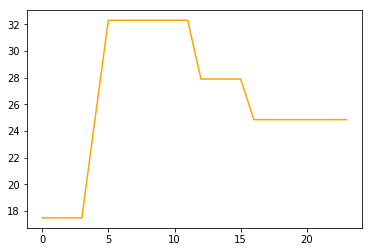

In [76]:
by_month = DART_forecast_2018[DART_forecast_2018['Month']==float(1)]

train, test = train_test_split(by_month, test_size=0.33)
train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','forecast_sem']].mean() 
train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','forecast_sem']].mean()
test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

cl = clusters2(ssr_split3(train_data, 'LMP_RT'))
plt.plot(cl.index,cl['Means'], 'orange')

In [77]:
cl.head()

LMP_RT     LMP_DA          Load          Wind  forecast_sem  \
Hour                                                                   
0.0   14.365597  19.152998  29368.419819  10004.628375    334.341000   
1.0   16.589008  19.458125  29313.699431   9949.600490   2542.640695   
2.0   19.146388  21.906183  30828.347386   8812.365351    257.731275   
3.0   19.807698  19.684134  30034.425356   9239.693981    213.466889   
4.0   24.946333  19.597925  30603.162024   9574.140625    253.824802   

        RT_sem      Means  Time  
Hour                             
0.0   2.023870  17.477173   0.0  
1.0   3.354979  17.477173   1.0  
2.0   3.772810  17.477173   2.0  
3.0   2.216114  17.477173   3.0  
4.0   4.860647  24.946333   4.0

In [71]:
def clusters_dfs(nested):
    try:
        dfs = [nested[0],nested[1][0],nested[1][1][0],nested[1][1][1][0],nested[1][1][1][1][0],nested[1][1][1][1][1][0]]
    except:
        try:
            dfs = [nested[0],nested[1][0],nested[1][1][0],nested[1][1][1][0],nested[1][1][1][1][0]]
        except:
            try:
                dfs = [nested[0],nested[1][0],nested[1][1][0],nested[1][1][1][0]]
            except:
                try:
                    dfs = [nested[0],nested[1][0],nested[1][1][0]]
                except:
                    print('oops')
                    return None
    for df in dfs:
        means = np.empty(df.shape[0])
        means.fill(df['LMP_RT'].mean())
        df['Means'] = means

    return dfs

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


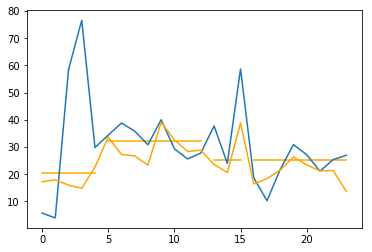

In [79]:
by_month = DART_forecast_2018[DART_forecast_2018['Month']==float(1)]

train, test = train_test_split(by_month, test_size=0.33)
train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','forecast_sem']].mean() 
train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','forecast_sem']].mean()
test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

test_data['fitted RT (4)'] = np.empty(24)
cl = clusters_dfs(ssr_split3(train_data, 'LMP_RT'))

results = list()

for cluster in cl:
    result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind", data=cluster).fit()
    results.append(result)
    for hour in cluster.index:
        test_data['fitted RT (4)'].loc[hour] = (test_data['Wind'].loc[hour]*result.params[4] + 
                                                test_data['RT_sem'].loc[hour]*result.params[3] + 
                                                test_data['Load'].loc[hour]*result.params[2] + 
                                                test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                result.params[0])
    plt.plot(cluster.index,cluster['Means'], 'orange')
plt.plot(test_data.index, test_data['fitted RT (4)'])
plt.plot(test_data.index, test_data['LMP_RT'], 'orange')

In [80]:
offset(test_data['fitted RT (4)'], test_data['LMP_RT']).mean()

55.53532052042568

In [210]:
n = 100
MAPE = np.empty(n)
for rep in range(n):
    wind_offset = list()
    for j in range(1,13):
        by_month = DART_forecast_2018[DART_forecast_2018['Month']==float(j)]

        train, test = train_test_split(by_month, test_size=0.33)
        train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','forecast_sem']].mean() 
        train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
        test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind','forecast_sem']].mean()
        test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()

        test_data['fitted RT (4)'] = np.empty(24)
        cl = clusters_dfs(ssr_split3(train_data, 'LMP_RT'))

        results = list()

        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind", data=cluster).fit()
            results.append(result)
            for hour in cluster.index:
                test_data['fitted RT (4)'].loc[hour] = (test_data['Wind'].loc[hour]*result.params[4] + 
                                                        test_data['RT_sem'].loc[hour]*result.params[3] + 
                                                        test_data['Load'].loc[hour]*result.params[2] + 
                                                        test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                        result.params[0])
        wind_offset.append(offset(test_data['fitted RT (4)'], test_data['LMP_RT']).mean())
        
    MAPE[rep] = np.array(wind_offset).mean()
    
    if rep%10==0:
        print('{}%'.format(rep))

MAPE.mean(), MAPE.std()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


(37.55746919132122, 14.204366098594047)

In [72]:
# Fills DA blanks

def filler(df, DA):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    df[DA] = np.array(new_list)
    return df

In [82]:
DA2018_aggloc.iloc[:,0:2].head()

Interval        LMP
Interval                                           
01/01/2018 01:00:00  01/01/2018 01:00:00  37.390157
01/01/2018 02:00:00  01/01/2018 02:00:00  37.249877
01/01/2018 03:00:00  01/01/2018 03:00:00  37.998882
01/01/2018 04:00:00  01/01/2018 04:00:00  40.778408
01/01/2018 05:00:00  01/01/2018 05:00:00  42.051515

In [83]:
RT2018.head()

Interval         LMP  Local Date Local Time  \
Interval                                                                      
01/01/2018 00:05:00  01/01/2018 00:05:00  246.567610  2018-01-01   00:05:00   
01/01/2018 00:10:00  01/01/2018 00:10:00   64.864068  2018-01-01   00:10:00   
01/01/2018 00:15:00  01/01/2018 00:15:00  164.686048  2018-01-01   00:15:00   
01/01/2018 00:20:00  01/01/2018 00:20:00  173.867912  2018-01-01   00:20:00   
01/01/2018 00:25:00  01/01/2018 00:25:00  163.353003  2018-01-01   00:25:00   

                         Hour  Weekday  Month  Day  
Interval                                            
01/01/2018 00:05:00  00:00:00     True      1    1  
01/01/2018 00:10:00  00:00:00     True      1    1  
01/01/2018 00:15:00  00:00:00     True      1    1  
01/01/2018 00:20:00  00:00:00     True      1    1  
01/01/2018 00:25:00  00:00:00     True      1    1

###### Editing 2018 DA-RT for 5-min intervals

In [73]:
comparison = DA2018_aggloc.iloc[:,0:2].join(RT2018,how='right',lsuffix='_DA',rsuffix='_RT')
comparison.head()

Interval_DA  LMP_DA          Interval_RT      LMP_RT  \
Interval                                                                   
01/01/2018 00:05:00         NaN     NaN  01/01/2018 00:05:00  246.567610   
01/01/2018 00:10:00         NaN     NaN  01/01/2018 00:10:00   64.864068   
01/01/2018 00:15:00         NaN     NaN  01/01/2018 00:15:00  164.686048   
01/01/2018 00:20:00         NaN     NaN  01/01/2018 00:20:00  173.867912   
01/01/2018 00:25:00         NaN     NaN  01/01/2018 00:25:00  163.353003   

                     Local Date Local Time      Hour  Weekday  Month  Day  
Interval                                                                   
01/01/2018 00:05:00  2018-01-01   00:05:00  00:00:00     True      1    1  
01/01/2018 00:10:00  2018-01-01   00:10:00  00:00:00     True      1    1  
01/01/2018 00:15:00  2018-01-01   00:15:00  00:00:00     True      1    1  
01/01/2018 00:20:00  2018-01-01   00:20:00  00:00:00     True      1    1  
01/01/2018 00:25:00  2018-01-01   00:25:00  00:00:00     True      1    1

In [74]:
DART2018_5min = filler(comparison, 'LMP_DA')
DART2018_5min.tail()

Interval_DA     LMP_DA          Interval_RT    LMP_RT  \
Interval                                                                    
12/31/2018 23:35:00         NaN  14.168643  12/31/2018 23:35:00  4.594098   
12/31/2018 23:40:00         NaN  14.168643  12/31/2018 23:40:00  5.619686   
12/31/2018 23:45:00         NaN  14.168643  12/31/2018 23:45:00  6.208854   
12/31/2018 23:50:00         NaN  14.168643  12/31/2018 23:50:00  6.696047   
12/31/2018 23:55:00         NaN  14.168643  12/31/2018 23:55:00  3.238793   

                     Local Date Local Time      Hour  Weekday  Month  Day  
Interval                                                                   
12/31/2018 23:35:00  2018-12-31   23:35:00  23:00:00     True     12   31  
12/31/2018 23:40:00  2018-12-31   23:40:00  23:00:00     True     12   31  
12/31/2018 23:45:00  2018-12-31   23:45:00  23:00:00     True     12   31  
12/31/2018 23:50:00  2018-12-31   23:50:00  23:00:00     True     12   31  
12/31/2018 23:55:00  2018-12-31   23:55:00  23:00:00     True     12   31

In [75]:
gen_mix_2018.tail()

GMT MKT Interval   Coal Market   Coal Self  \
104869  2019-01-01T05:35:00Z         414.7      9700.0   
104870  2019-01-01T05:40:00Z         406.2      9741.4   
104871  2019-01-01T05:45:00Z         402.1      9703.6   
104872  2019-01-01T05:50:00Z         399.8      9618.2   
104873  2019-01-01T05:55:00Z         401.0      9558.8   

         Diesel Fuel Oil Market   Diesel Fuel Oil Self   Hydro Market  \
104869                      0.0                    0.0          141.3   
104870                      0.0                    0.0          141.3   
104871                      0.0                    0.0          141.2   
104872                      0.0                    0.0          141.7   
104873                      0.0                    0.0          141.2   

         Hydro Self   Natural Gas Market   Gas Self   Nuclear Market  \
104869        501.9               2966.9     1088.1              0.0   
104870        503.4               2865.2     1062.5              0.0   
104871        501.5               2885.0     1011.8              0.0   
104872        501.9               2916.7     1014.9              0.0   
104873        503.2               2885.8      964.9              0.0   

           ...       Waste Disposal Services Self   Wind Market   Wind Self  \
104869     ...                               12.6           0.0     14643.2   
104870     ...                               12.7           0.0     14679.9   
104871     ...                               12.6           0.0     14666.1   
104872     ...                               12.7           0.0     14690.3   
104873     ...                               12.7           0.0     14618.3   

         Waste Heat Market   Waste Heat Self   Other Market   Other Self  \
104869                 0.0               0.0            0.0         33.1   
104870                 0.0               0.0            0.0         32.6   
104871                 0.0               0.0            0.0         33.2   
104872                 0.0               0.0            0.0         33.1   
104873                 0.0               0.0            0.0         33.2   

         Average Actual Load  Local Date  Local Time  
104869             30400.052  2018-12-31    23:35:00  
104870             30401.893  2018-12-31    23:40:00  
104871             30246.725  2018-12-31    23:45:00  
104872             30222.304  2018-12-31    23:50:00  
104873             30130.697  2018-12-31    23:55:00  

[5 rows x 24 columns]

In [76]:
gen_2018 = gen_mix_2018
new_index = []
for i in range(gen_2018.shape[0]):
    new_index.append(gen_2018['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + gen_2018['Local Time'].iloc[i].strftime("%H:%M:%S"))
gen_2018.index = np.array(new_index)
gen_2018.head()

GMT MKT Interval   Coal Market   Coal Self  \
01/01/2018 00:00:00  2018-01-01T06:00:00Z        2948.5     18203.9   
01/01/2018 00:05:00  2018-01-01T06:05:00Z        2917.3     18191.4   
01/01/2018 00:10:00  2018-01-01T06:10:00Z        2916.5     18181.4   
01/01/2018 00:15:00  2018-01-01T06:15:00Z        2913.0     18159.0   
01/01/2018 00:20:00  2018-01-01T06:20:00Z        2911.5     18154.1   

                      Diesel Fuel Oil Market   Diesel Fuel Oil Self  \
01/01/2018 00:00:00                      0.0                    4.4   
01/01/2018 00:05:00                      0.0                    4.4   
01/01/2018 00:10:00                      0.0                    0.0   
01/01/2018 00:15:00                      0.0                    0.0   
01/01/2018 00:20:00                      0.0                    0.0   

                      Hydro Market   Hydro Self   Natural Gas Market  \
01/01/2018 00:00:00           43.1        759.6               5903.9   
01/01/2018 00:05:00           43.3        775.3               5842.2   
01/01/2018 00:10:00           43.8        802.2               5983.2   
01/01/2018 00:15:00           43.8        776.5               6116.0   
01/01/2018 00:20:00           43.3        713.7               6182.6   

                      Gas Self   Nuclear Market     ...      \
01/01/2018 00:00:00     3447.6              0.0     ...       
01/01/2018 00:05:00     3468.0              0.0     ...       
01/01/2018 00:10:00     3479.6              0.0     ...       
01/01/2018 00:15:00     3385.1              0.0     ...       
01/01/2018 00:20:00     3438.3              0.0     ...       

                      Waste Disposal Services Self   Wind Market   Wind Self  \
01/01/2018 00:00:00                           10.8           0.0      3643.1   
01/01/2018 00:05:00                           10.9           0.0      3619.8   
01/01/2018 00:10:00                           11.0           0.0      3578.9   
01/01/2018 00:15:00                           10.9           0.0      3539.2   
01/01/2018 00:20:00                           10.9           0.0      3515.1   

                      Waste Heat Market   Waste Heat Self   Other Market  \
01/01/2018 00:00:00                 0.0               0.0            0.0   
01/01/2018 00:05:00                 0.0               0.0            0.0   
01/01/2018 00:10:00                 0.0               0.0            0.0   
01/01/2018 00:15:00                 0.0               0.0            0.0   
01/01/2018 00:20:00                 0.0               0.0            0.0   

                      Other Self   Average Actual Load  Local Date  Local Time  
01/01/2018 00:00:00         27.1             36439.754  2018-01-01    00:00:00  
01/01/2018 00:05:00         27.3             36389.511  2018-01-01    00:05:00  
01/01/2018 00:10:00         27.0             36386.829  2018-01-01    00:10:00  
01/01/2018 00:15:00         26.9             36290.426  2018-01-01    00:15:00  
01/01/2018 00:20:00         27.3             36225.646  2018-01-01    00:20:00  

[5 rows x 24 columns]

In [77]:
DART_gen_2018 = gen_2018.join(DART2018_5min,how='right',lsuffix='_gen',rsuffix='_price')
DART_gen_2018

GMT MKT Interval   Coal Market   Coal Self  \
Interval                                                              
01/01/2018 00:05:00  2018-01-01T06:05:00Z        2917.3     18191.4   
01/01/2018 00:10:00  2018-01-01T06:10:00Z        2916.5     18181.4   
01/01/2018 00:15:00  2018-01-01T06:15:00Z        2913.0     18159.0   
01/01/2018 00:20:00  2018-01-01T06:20:00Z        2911.5     18154.1   
01/01/2018 00:25:00  2018-01-01T06:25:00Z        2895.3     18181.1   
01/01/2018 00:30:00  2018-01-01T06:30:00Z        2896.4     18189.0   
01/01/2018 00:35:00  2018-01-01T06:35:00Z        2894.9     18226.5   
01/01/2018 00:40:00  2018-01-01T06:40:00Z        2883.9     18149.6   
01/01/2018 00:45:00  2018-01-01T06:45:00Z        2883.9     18151.5   
01/01/2018 00:50:00  2018-01-01T06:50:00Z        2893.2     18155.3   
01/01/2018 00:55:00  2018-01-01T06:55:00Z        2903.0     18179.4   
01/01/2018 01:00:00  2018-01-01T07:00:00Z        2899.9     18159.6   
01/01/2018 01:05:00  2018-01-01T07:05:00Z        2934.9     18164.9   
01/01/2018 01:10:00  2018-01-01T07:10:00Z        2967.7     18101.7   
01/01/2018 01:15:00  2018-01-01T07:15:00Z        2987.8     18118.5   
01/01/2018 01:20:00  2018-01-01T07:20:00Z        2991.5     18157.5   
01/01/2018 01:25:00  2018-01-01T07:25:00Z        3000.8     18190.0   
01/01/2018 01:30:00  2018-01-01T07:30:00Z        3003.2     18246.4   
01/01/2018 01:35:00  2018-01-01T07:35:00Z        3004.7     18273.8   
01/01/2018 01:40:00  2018-01-01T07:40:00Z        3008.3     18229.0   
01/01/2018 01:45:00  2018-01-01T07:45:00Z        3010.2     18228.1   
01/01/2018 01:50:00  2018-01-01T07:50:00Z        3012.6     18201.3   
01/01/2018 01:55:00  2018-01-01T07:55:00Z        3015.6     18266.5   
01/01/2018 02:00:00  2018-01-01T08:00:00Z        3020.0     18207.6   
01/01/2018 02:05:00  2018-01-01T08:05:00Z        3012.3     18168.0   
01/01/2018 02:10:00  2018-01-01T08:10:00Z        3007.7     18185.0   
01/01/2018 02:15:00  2018-01-01T08:15:00Z        3015.1     18213.5   
01/01/2018 02:20:00  2018-01-01T08:20:00Z        3001.5     18168.0   
01/01/2018 02:25:00  2018-01-01T08:25:00Z        3012.6     18188.9   
01/01/2018 02:30:00  2018-01-01T08:30:00Z        3016.3     18143.4   
...                                   ...           ...         ...   
12/31/2018 21:30:00  2019-01-01T03:30:00Z         422.5      9437.3   
12/31/2018 21:35:00  2019-01-01T03:35:00Z         415.7      9459.2   
12/31/2018 21:40:00  2019-01-01T03:40:00Z         422.9      9461.6   
12/31/2018 21:45:00  2019-01-01T03:45:00Z         417.5      9410.9   
12/31/2018 21:50:00  2019-01-01T03:50:00Z         415.2      9469.2   
12/31/2018 21:55:00  2019-01-01T03:55:00Z         408.4      9380.8   
12/31/2018 22:00:00  2019-01-01T04:00:00Z         402.3      9412.2   
12/31/2018 22:05:00  2019-01-01T04:05:00Z         410.5      9559.4   
12/31/2018 22:10:00  2019-01-01T04:10:00Z         417.2      9754.8   
12/31/2018 22:15:00  2019-01-01T04:15:00Z         422.7      9859.4   
12/31/2018 22:20:00  2019-01-01T04:20:00Z         418.1      9864.4   
12/31/2018 22:25:00  2019-01-01T04:25:00Z         416.4      9839.1   
12/31/2018 22:30:00  2019-01-01T04:30:00Z         424.9      9943.3   
12/31/2018 22:35:00  2019-01-01T04:35:00Z         416.3      9898.2   
12/31/2018 22:40:00  2019-01-01T04:40:00Z         423.0      9880.8   
12/31/2018 22:45:00  2019-01-01T04:45:00Z         414.7      9839.0   
12/31/2018 22:50:00  2019-01-01T04:50:00Z         412.4      9898.8   
12/31/2018 22:55:00  2019-01-01T04:55:00Z         403.8      9958.1   
12/31/2018 23:00:00  2019-01-01T05:00:00Z         414.6      9957.3   
12/31/2018 23:05:00  2019-01-01T05:05:00Z         409.6      9999.2   
12/31/2018 23:10:00  2019-01-01T05:10:00Z         406.0     10009.2   
12/31/2018 23:15:00  2019-01-01T05:15:00Z         398.6      9873.7   
12/31/2018 23:20:00  2019-01-01T05:20:00Z         396.0      9839.0   
12/31/2018 23:25:00  2019-01-01T05:25:00Z        

In [78]:
DART_gen_2018 = DART_gen_2018.rename(columns={' Average Actual Load':'Load',
                                             ' Wind Self':'Wind',
                                             ' Coal Market':'Coal_Mkt',
                                             ' Coal Self':'Coal_Self'})
DART_gen_2018.columns

Index(['GMT MKT Interval', 'Coal_Mkt', 'Coal_Self', ' Diesel Fuel Oil Market',
       ' Diesel Fuel Oil Self', ' Hydro Market', ' Hydro Self',
       ' Natural Gas Market', ' Gas Self', ' Nuclear Market', ' Nuclear Self',
       ' Solar Market', ' Solar Self', ' Waste Disposal Services Market',
       ' Waste Disposal Services Self', ' Wind Market', 'Wind',
       ' Waste Heat Market', ' Waste Heat Self', ' Other Market',
       ' Other Self', 'Load', 'Local Date_gen', 'Local Time_gen',
       'Interval_DA', 'LMP_DA', 'Interval_RT', 'LMP_RT', 'Local Date_price',
       'Local Time_price', 'Hour', 'Weekday', 'Month', 'Day'],
      dtype='object')

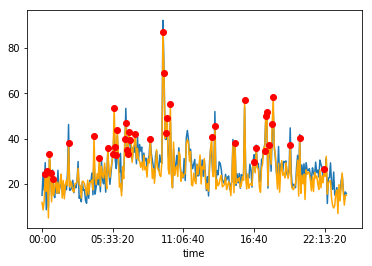

In [79]:
by_month = DART_gen_2018[DART_gen_2018['Month']==1]

train, test = train_test_split(by_month, test_size=0.33)
train_data = train.groupby('Local Time_price')[['LMP_RT','LMP_DA','Load','Wind']].mean() 
train_data['RT_sem'] = train.groupby('Local Time_price')[['LMP_RT']].sem()
test_data = test.groupby('Local Time_price')[['LMP_RT','LMP_DA','Load','Wind']].mean()
test_data['RT_sem'] = test.groupby('Local Time_price')[['LMP_RT']].sem()
test_data['Local Hour'] = test_data.index

result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind", data=train_data).fit()
test_data['fitted RT (4)'] = (test_data['Wind']*result.params[4] + 
                                test_data['RT_sem']*result.params[3] + 
                                test_data['Load']*result.params[2] + 
                                test_data['LMP_DA']*result.params[1] + 
                                result.params[0])

plt.plot(test_data.index, test_data['fitted RT (4)'])
plt.plot(test_data.index, test_data['LMP_RT'], 'orange')
plt.plot(critical2(test_data)[0],critical2(test_data)[1],'ro')


In [80]:
(offset(test_data['fitted RT (4)'], test_data['LMP_RT'])).mean()

15.677310627861589

In [221]:
# having 5-min intervals doesn't help at all with spikes

In [222]:
RT.columns

Index(['Interval', ' GMT Interval', ' Settlement Location Name', ' PNODE Name',
       ' LMP', ' MLC', ' MCC', ' MEC'],
      dtype='object')

In [223]:
RT.groupby(' Settlement Location Name')[[' Settlement Location Name']].count().shape[0]

1009

In [224]:
RT.groupby(' PNODE Name').count().shape[0]

976

In [232]:
AEC = RT[RT[RT.columns[2]]=='AEC'][['Interval',' LMP']]
AEC = AEC.rename(columns={' LMP':'LMP'})
AEC.head()

Interval       LMP
0     01/01/2018 00:05:00  255.8769
955   01/01/2018 00:10:00   75.1384
1910  01/01/2018 00:15:00  196.7086
2865  01/01/2018 00:20:00  202.9008
3820  01/01/2018 00:25:00  189.5415

In [236]:
AEC_DA = DA2018[DA2018[DA2018.columns[2]]=='AEC'][['Interval','LMP']]
AEC_DA.head()

Interval      LMP
0     01/01/2018 01:00:00  39.6809
955   01/01/2018 02:00:00  39.8236
1910  01/01/2018 03:00:00  40.1811
2865  01/01/2018 04:00:00  43.0544
3820  01/01/2018 05:00:00  44.0145

In [237]:
# change indexes

AEC.index = AEC['Interval']
AEC_DA.index = AEC_DA['Interval']

In [242]:
DART_AEC = AEC_DA.join(AEC,how='right',lsuffix='_DA',rsuffix='_RT')
DART_AEC.head()

Interval_DA  LMP_DA          Interval_RT    LMP_RT
Interval                                                              
01/01/2018 00:05:00         NaN     NaN  01/01/2018 00:05:00  255.8769
01/01/2018 00:10:00         NaN     NaN  01/01/2018 00:10:00   75.1384
01/01/2018 00:15:00         NaN     NaN  01/01/2018 00:15:00  196.7086
01/01/2018 00:20:00         NaN     NaN  01/01/2018 00:20:00  202.9008
01/01/2018 00:25:00         NaN     NaN  01/01/2018 00:25:00  189.5415

In [243]:
DART_AEC = filler(DART_AEC, 'LMP_DA')
DART_AEC[' LMP_DA'] = DART_AEC['LMP_DA']
DART_AEC = DART_AEC.drop(columns=DART_AEC.columns[0:2])
DART_AEC = add_info(DART_AEC)
DART_AEC = DART_AEC.rename(columns={' LMP_DA':'LMP_DA'})
DART_AEC.tail()

Interval_RT   LMP_RT  LMP_DA  Local Date  \
Interval                                                                
12/31/2018 23:35:00  12/31/2018 23:35:00  36.4485   19.51  2018-12-31   
12/31/2018 23:40:00  12/31/2018 23:40:00  19.1593   19.51  2018-12-31   
12/31/2018 23:45:00  12/31/2018 23:45:00  19.8984   19.51  2018-12-31   
12/31/2018 23:50:00  12/31/2018 23:50:00  17.0037   19.51  2018-12-31   
12/31/2018 23:55:00  12/31/2018 23:55:00  17.1376   19.51  2018-12-31   

                    Local Time      Hour  Weekday  Month  Day  
Interval                                                       
12/31/2018 23:35:00   23:35:00  23:00:00     True     12   31  
12/31/2018 23:40:00   23:40:00  23:00:00     True     12   31  
12/31/2018 23:45:00   23:45:00  23:00:00     True     12   31  
12/31/2018 23:50:00   23:50:00  23:00:00     True     12   31  
12/31/2018 23:55:00   23:55:00  23:00:00     True     12   31

type 'y' to run: y


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


14.082310925287876 12.323912632445783


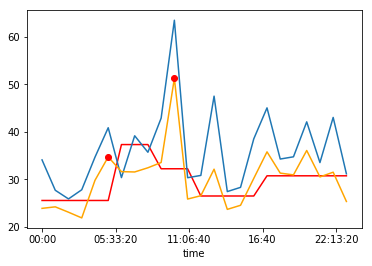

In [270]:
# just clusters vs linear for AEC

if(input('type \'y\' to run: ')=='y'):
    n = 10
    clusters_array = np.empty(n)
    linear_array = np.empty(n)
    for i in range(n):
        clusters_pe = []
        linear_pe = []
        for j in range(1,13):
            by_month = DART_AEC[DART_AEC['Month']==j]

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
            train_data['RT_sem'] = train.groupby('Hour')['LMP_RT'].sem()
            train_data['DA_sem'] = train.groupby('Hour')['LMP_DA'].sem()        

            cl = clusters2(ssr_split3(train_data, 'LMP_RT'))

            test_data = test.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
            test_data['RT_sem'] = test.groupby('Hour')['LMP_RT'].sem()
            test_data['DA_sem'] = test.groupby('Hour')['LMP_DA'].sem() 

            clusters_pe.append(offset(cl['Means'],test_data['LMP_RT']))

            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
            test_data['fitted RT'] = (test_data['DA_sem']*result.params[3] +
                                    test_data['RT_sem']*result.params[2] +
                                    test_data['LMP_DA']*result.params[1] +
                                    result.params[0])

            linear_pe.append(offset(test_data['fitted RT'], test_data['LMP_RT']))
        
        if i==1:
            plt.plot(cl.index, cl['Means'], 'red')
            plt.plot(test_data.index, test_data['fitted RT'])
            plt.plot(test_data.index, test_data['LMP_RT'], 'orange')
            test_data['Local Hour'] = test_data.index
            plt.plot(critical2(test_data)[0],critical2(test_data)[1],'ro')

        clusters_array[i] = np.nanmean(np.array(clusters_pe))
        linear_array[i] = np.nanmean(np.array(linear_pe))

    print(np.nanmean(clusters_array), np.nanmean(linear_array))

type 'y' to run: y


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
10.181328188546866 11.931449429807309


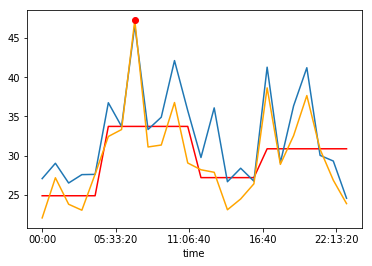

In [271]:
# combined clusters and linear for AEC

if(input('type \'y\' to run: ')=='y'):
    n = 100
    clusters_array = np.empty(n)
    linear_array = np.empty(n)
    for i in range(n):
        clusters_pe = []
        linear_pe = []
        for j in range(1,13):
            by_month = DART_AEC[DART_AEC['Month']==j]

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
            train_data['RT_sem'] = train.groupby('Hour')['LMP_RT'].sem()
            train_data['DA_sem'] = train.groupby('Hour')['LMP_DA'].sem()        

            test_data = test.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
            test_data['RT_sem'] = test.groupby('Hour')['LMP_RT'].sem()
            test_data['DA_sem'] = test.groupby('Hour')['LMP_DA'].sem() 

            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
            test_data['fitted RT (1)'] = (test_data['DA_sem']*result.params[3] +
                                    test_data['RT_sem']*result.params[2] +
                                    test_data['LMP_DA']*result.params[1] +
                                    result.params[0])

            linear_pe.append(offset(test_data['fitted RT (1)'], test_data['LMP_RT']))
            
            test_data['fitted RT'] = np.empty(24)
            test_data['fitted RT (2)'] = np.empty(24)            
            
            cl = clusters_dfs(ssr_split3(train_data, 'LMP_RT'))
            cl_plot = clusters2(ssr_split3(train_data, 'LMP_RT'))

            for cluster in cl:
                result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=cluster).fit()
                for hour in cluster.index:
                    test_data['fitted RT (2)'].loc[hour] = (test_data['DA_sem'].loc[hour]*result.params[3] + 
                                                test_data['RT_sem'].loc[hour]*result.params[2] + 
                                                test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                result.params[0])
                    if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                        abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                        test_data['fitted RT'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                    else:
                        test_data['fitted RT'].loc[hour] = test_data['fitted RT (1)'].loc[hour]                        
            
            clusters_pe.append(offset(test_data['fitted RT'],test_data['LMP_RT']))

        if i==1:
            plt.plot(cl_plot.index, cl_plot['Means'], 'red')
            plt.plot(test_data.index, test_data['fitted RT'])
            plt.plot(test_data.index, test_data['LMP_RT'], 'orange')
            test_data['Local Hour'] = test_data.index
            plt.plot(critical2(test_data)[0],critical2(test_data)[1],'ro')

        if i%10==0:
            print('{}%'.format(i))
            
        clusters_array[i] = np.nanmean(np.array(clusters_pe))
        linear_array[i] = np.nanmean(np.array(linear_pe))

    print(np.nanmean(clusters_array), np.nanmean(linear_array))

In [283]:
# good result for aggregate locations, wind predictor, cluster+linear
if(input('type \'y\' to run: ')=='y'):
    n = 100
    MAPE = np.empty(n)
    for rep in range(n):
        wind_offset = list()
        for j in range(1,13):
            by_month = DART_wind_2018[DART_wind_2018['Month']==float(j)]

            train, test = train_test_split(by_month, test_size=0.33)
            train_data = train.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind']].mean() 
            train_data['RT_sem'] = train.groupby('Hour')[['LMP_RT']].sem()
            test_data = test.groupby('Hour')[['LMP_RT','LMP_DA','Load','Wind']].mean()
            test_data['RT_sem'] = test.groupby('Hour')[['LMP_RT']].sem()
            
            result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind", data=train_data).fit()
            test_data['fitted RT (1)'] = (test_data['Wind']*result.params[4] + 
                                        test_data['RT_sem']*result.params[3] + 
                                        test_data['Load']*result.params[2] + 
                                        test_data['LMP_DA']*result.params[1] + 
                                        result.params[0])
                
            cl = clusters_dfs(ssr_split3(train_data, 'LMP_RT'))
            test_data['fitted RT'] = np.empty(24)
            test_data['fitted RT (2)'] = np.empty(24)
            for cluster in cl:
                result = smf.ols(formula="LMP_RT ~ LMP_DA + Load + RT_sem + Wind", data=cluster).fit()
                for hour in cluster.index:
                    test_data['fitted RT (2)'].loc[hour] = (test_data['Wind'].loc[hour]*result.params[4] + 
                                                            test_data['RT_sem'].loc[hour]*result.params[3] + 
                                                            test_data['Load'].loc[hour]*result.params[2] + 
                                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                            result.params[0])
                    if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                        abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                        test_data['fitted RT'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                    else:
                        test_data['fitted RT'].loc[hour] = test_data['fitted RT (1)'].loc[hour]  

            wind_offset.append(offset(test_data['fitted RT'], test_data['LMP_RT']))

        MAPE[rep] = np.nanmean(np.array(wind_offset))

        if rep%10==0:
            print('{}%'.format(rep))

    print(MAPE.mean(), MAPE.std())

type 'y' to run: y


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
9.533247672862819 1.1275653732636794


In [94]:
# grouping by hour, using separate locations, applied combined clustered fit

for name in RT[RT.columns[2]].iloc[0:5]:
    AEC = RT[RT[RT.columns[2]]==name][['Interval',' LMP']]
    AEC = AEC.rename(columns={' LMP':'LMP'})
    AEC_DA = DA2018[DA2018[DA2018.columns[2]]==name][['Interval','LMP']]
    AEC.index = AEC['Interval']
    AEC_DA.index = AEC_DA['Interval']
    DART_AEC = AEC_DA.join(AEC,how='right',lsuffix='_DA',rsuffix='_RT')
    DART_AEC = filler(DART_AEC, 'LMP_DA')
    DART_AEC[' LMP_DA'] = DART_AEC['LMP_DA']
    DART_AEC = DART_AEC.drop(columns=DART_AEC.columns[0:2])
    DART_AEC = add_info(DART_AEC)
    DART_AEC = DART_AEC.rename(columns={' LMP_DA':'LMP_DA'})
    
    n = 20
    clusters_array = np.empty(n)
    linear_array = np.empty(n)
    for i in range(n):
        clusters_pe = []
        linear_pe = []
        for j in range(1,13):
            by_month = DART_AEC[DART_AEC['Month']==j]

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
            train_data['RT_sem'] = train.groupby('Hour')['LMP_RT'].sem()
            train_data['DA_sem'] = train.groupby('Hour')['LMP_DA'].sem()        

            test_data = test.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
            test_data['RT_sem'] = test.groupby('Hour')['LMP_RT'].sem()
            test_data['DA_sem'] = test.groupby('Hour')['LMP_DA'].sem() 

            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
            test_data['fitted RT (1)'] = (test_data['DA_sem']*result.params[3] +
                                    test_data['RT_sem']*result.params[2] +
                                    test_data['LMP_DA']*result.params[1] +
                                    result.params[0])

            linear_pe.append(offset(test_data['fitted RT (1)'], test_data['LMP_RT']))
            
            test_data['fitted RT'] = np.empty(24)
            test_data['fitted RT (2)'] = np.empty(24)            
            
            cl = clusters_dfs(ssr_split3(train_data, 'LMP_RT'))
            cl_plot = clusters2(ssr_split3(train_data, 'LMP_RT'))

            for cluster in cl:
                result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=cluster).fit()
                for hour in cluster.index:
                    test_data['fitted RT (2)'].loc[hour] = (test_data['DA_sem'].loc[hour]*result.params[3] + 
                                                test_data['RT_sem'].loc[hour]*result.params[2] + 
                                                test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                result.params[0])
                    if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                        abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                        test_data['fitted RT'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                    else:
                        test_data['fitted RT'].loc[hour] = test_data['fitted RT (1)'].loc[hour]                        
            
            clusters_pe.append(offset(test_data['fitted RT'],test_data['LMP_RT']))
            
        clusters_array[i] = np.nanmean(np.array(clusters_pe))
        linear_array[i] = np.nanmean(np.array(linear_pe))

    print(np.nanmean(clusters_array), np.nanmean(linear_array))

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


10.500424847485863 12.188337095987597
10.395877892581012 12.967192046335963
11.621084061442913 12.410634251193546
11.024662820918781 14.944916014932264
10.846817501905395 12.374737535576282


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7.538676596085191 0.4374131944444445


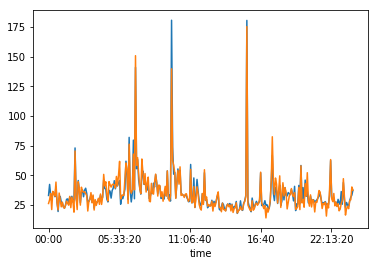

In [81]:
# grouping by 5-min interval, using 1 separate location, applied combined clustered fit

for name in RT[RT.columns[2]].iloc[0:1]:
    AEC = RT[RT[RT.columns[2]]==name][['Interval',' LMP']]
    AEC = AEC.rename(columns={' LMP':'LMP'})
    AEC_DA = DA2018[DA2018[DA2018.columns[2]]==name][['Interval','LMP']]
    AEC.index = AEC['Interval']
    AEC_DA.index = AEC_DA['Interval']
    DART_AEC = AEC_DA.join(AEC,how='right',lsuffix='_DA',rsuffix='_RT')
    DART_AEC = filler(DART_AEC, 'LMP_DA')
    DART_AEC[' LMP_DA'] = DART_AEC['LMP_DA']
    DART_AEC = DART_AEC.drop(columns=DART_AEC.columns[0:2])
    DART_AEC = add_info(DART_AEC)
    DART_AEC = DART_AEC.rename(columns={' LMP_DA':'LMP_DA'})
    
    n = 10
    clusters_array = np.empty(n)
    changes_array = np.empty(n)
    for i in range(n):
        clusters_pe = []
        changes_list = []
        for j in range(1,13):
            by_month = DART_AEC[DART_AEC['Month']==j]

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
            train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

            test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
            test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
            test_data['fitted RT (1)'] = (test_data['DA_sem']*result.params[3] +
                                    test_data['RT_sem']*result.params[2] +
                                    test_data['LMP_DA']*result.params[1] +
                                    result.params[0])
            
            size = test_data.index.shape[0]
            k = 0
            
            test_data['fitted RT'] = test_data['fitted RT (1)']
            test_data['fitted RT (2)'] = np.empty(size)            
            
            cl = clusters_dfs(ssr_split3(train_data, 'LMP_RT'))
            cl_plot = clusters2(ssr_split3(train_data, 'LMP_RT'))

            for cluster in cl:
                result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=cluster).fit()
                for hour in cluster.index:
                    test_data['fitted RT (2)'].loc[hour] = (test_data['DA_sem'].loc[hour]*result.params[3] + 
                                                test_data['RT_sem'].loc[hour]*result.params[2] + 
                                                test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                result.params[0])
                    if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                        abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                        test_data['fitted RT'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                        k += 1
                    else:
                        continue
            clusters_pe.append(offset(test_data['fitted RT'],test_data['LMP_RT']))
            
            if i==1 and j==1:
                plt.plot(test_data.index, test_data['fitted RT'])
                plt.plot(test_data.index, test_data['LMP_RT'])
            
            changes_list.append(k/size)
        
        changes_array[i] = np.nanmean(np.array(changes_list))
        clusters_array[i] = np.nanmean(np.array(clusters_pe))

    print(np.nanmean(clusters_array), np.nanmean(changes_array))

In [ ]:
# 9% not a bad result for 5-min intervals

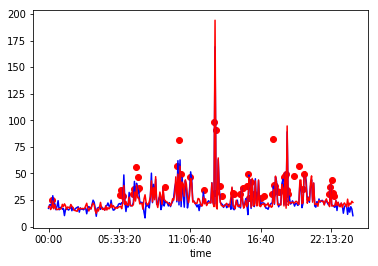

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


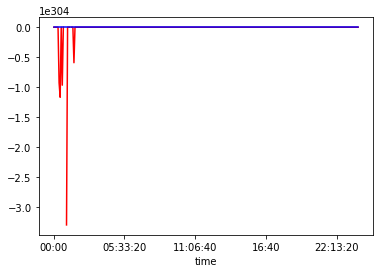

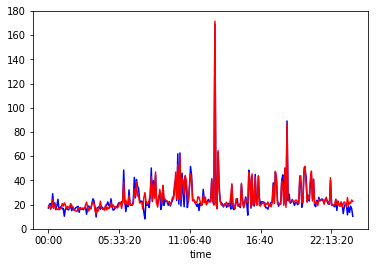

In [82]:
# training peaks separately

by_month = DART_AEC[DART_AEC['Month']==2]

train, test = train_test_split(by_month, test_size=0.33)

train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

time = test_data.index

train_data['Local Hour'] = time
test_data['Local Hour'] = time
plt.plot(critical2(train_data)[0],critical2(train_data)[1],'ro')

result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
test_data['fitted RT (1)'] = (test_data['DA_sem']*result.params[3] +
                        test_data['RT_sem']*result.params[2] +
                        test_data['LMP_DA']*result.params[1] +
                        result.params[0])
plt.plot(time, test_data['LMP_RT'], 'blue')
plt.plot(time, test_data['fitted RT (1)'], 'red')
plt.show()

size = test_data.index.shape[0]
test_data['fitted RT'] = test_data['fitted RT (1)']
test_data['fitted RT (2)'] = np.empty(size)            
            
critical = critical2(train_data)[0]
peaks = train_data.loc[critical]
result2 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=peaks).fit()
for hour in peaks.index:
    test_data['fitted RT (2)'].loc[hour] = (test_data['DA_sem'].loc[hour]*result2.params[3] + 
                                test_data['RT_sem'].loc[hour]*result2.params[2] + 
                                test_data['LMP_DA'].loc[hour]*result2.params[1] + 
                                result2.params[0])
    if abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour]):
        test_data['fitted RT'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
    else:
        continue
        
plt.plot(time, test_data['fitted RT (2)'], 'red')
plt.plot(time, test_data['LMP_RT'], 'blue')        
plt.show()

plt.plot(time, test_data['LMP_RT'], 'blue')
plt.plot(time, test_data['fitted RT'], 'red')        
plt.show()

In [83]:
offset(test_data['fitted RT'],test_data['LMP_RT']).mean()

13.326226656339308

In [81]:
# really odd peak -- investigate later

##### 5-min interval forecasting
###### using outdated (flawed) clustering and decision-making

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
9.36137494224592


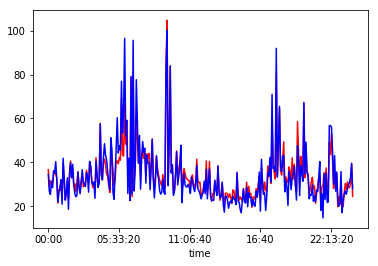

In [87]:
# grouping by 5-min interval, using 1 separate location, applied combined clustered fit

for name in RT[RT.columns[2]].iloc[0:1]:
    AEC = RT[RT[RT.columns[2]]==name][['Interval',' LMP']]
    AEC = AEC.rename(columns={' LMP':'LMP'})
    AEC_DA = DA2018[DA2018[DA2018.columns[2]]==name][['Interval','LMP']]
    AEC.index = AEC['Interval']
    AEC_DA.index = AEC_DA['Interval']
    DART_AEC = AEC_DA.join(AEC,how='right',lsuffix='_DA',rsuffix='_RT')
    DART_AEC = filler(DART_AEC, 'LMP_DA')
    DART_AEC[' LMP_DA'] = DART_AEC['LMP_DA']
    DART_AEC = DART_AEC.drop(columns=DART_AEC.columns[0:2])
    DART_AEC = add_info(DART_AEC)
    DART_AEC = DART_AEC.rename(columns={' LMP_DA':'LMP_DA'})
    
    n = 10
    clusters_array = np.empty(n)
    for i in range(n):
        clusters_pe = []
        for j in range(1,13):
            by_month = DART_AEC[DART_AEC['Month']==j]

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
            train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

            test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
            test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
            test_data['fitted RT (1)'] = (test_data['DA_sem']*result.params[3] +
                                    test_data['RT_sem']*result.params[2] +
                                    test_data['LMP_DA']*result.params[1] +
                                    result.params[0])
            
            size = test_data.index.shape[0]
            
            test_data['fitted RT'] = test_data['fitted RT (1)']
            test_data['fitted RT (2)'] = np.empty(size)            
            
            cl = clusters_dfs(ssr_split3(train_data, 'LMP_RT'))
            cl_plot = clusters2(ssr_split3(train_data, 'LMP_RT'))

            for cluster in cl:
                result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=cluster).fit()
                for hour in cluster.index:
                    test_data['fitted RT (2)'].loc[hour] = (test_data['DA_sem'].loc[hour]*result.params[3] + 
                                                test_data['RT_sem'].loc[hour]*result.params[2] + 
                                                test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                result.params[0])
                    if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                        abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                        test_data['fitted RT'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                    else:
                        continue                        
            
            clusters_pe.append(offset(test_data['fitted RT'],test_data['LMP_RT']).mean())
            
            if i==1 and j==1:
                plt.plot(test_data.index, test_data['fitted RT'],'red')
                plt.plot(test_data.index, test_data['LMP_RT'],'blue')
 
        print('{}%'.format(10*i))

        clusters_array[i] = np.array(clusters_pe).mean()

    print(clusters_array.mean())

In [83]:
#test_data.sort_values('RT_sem',ascending=False) to get RT that varied the most
# likely the ones with worst forecast

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
9.142128379733725


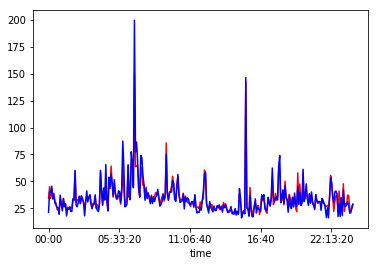

In [84]:
# grouping by 5-min interval, using 1 separate location, applied combined clustered fit - histogram of residuals

for name in RT[RT.columns[2]].iloc[0:1]:
    AEC = RT[RT[RT.columns[2]]==name][['Interval',' LMP']]
    AEC = AEC.rename(columns={' LMP':'LMP'})
    AEC_DA = DA2018[DA2018[DA2018.columns[2]]==name][['Interval','LMP']]
    AEC.index = AEC['Interval']
    AEC_DA.index = AEC_DA['Interval']
    DART_AEC = AEC_DA.join(AEC,how='right',lsuffix='_DA',rsuffix='_RT')
    DART_AEC = filler(DART_AEC, 'LMP_DA')
    DART_AEC[' LMP_DA'] = DART_AEC['LMP_DA']
    DART_AEC = DART_AEC.drop(columns=DART_AEC.columns[0:2])
    DART_AEC = add_info(DART_AEC)
    DART_AEC = DART_AEC.rename(columns={' LMP_DA':'LMP_DA'})
    
    n = 10
    clusters_array = np.empty(n)
    residuals = []
    for i in range(n):
        clusters_pe = []
        for j in range(1,13):
            by_month = DART_AEC[DART_AEC['Month']==j]

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
            train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

            test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
            test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
            test_data['fitted RT (1)'] = (test_data['DA_sem']*result.params[3] +
                                    test_data['RT_sem']*result.params[2] +
                                    test_data['LMP_DA']*result.params[1] +
                                    result.params[0])
            
            size = test_data.index.shape[0]
            
            test_data['fitted RT'] = test_data['fitted RT (1)']
            test_data['fitted RT (2)'] = np.empty(size)            
            
            cl = clusters_dfs(ssr_split3(train_data, 'LMP_RT'))
            cl_plot = clusters2(ssr_split3(train_data, 'LMP_RT'))

            for cluster in cl:
                result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=cluster).fit()
                for hour in cluster.index:
                    test_data['fitted RT (2)'].loc[hour] = (test_data['DA_sem'].loc[hour]*result.params[3] + 
                                                test_data['RT_sem'].loc[hour]*result.params[2] + 
                                                test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                result.params[0])
                    if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                        abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                        test_data['fitted RT'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                    else:
                        continue                        
            
            clusters_pe.append(offset(test_data['fitted RT'],test_data['LMP_RT']).mean())
            
            test_data['residuals'] = test_data['LMP_RT'] - test_data['fitted RT']
            for value in test_data['residuals'].values:
                residuals.append(value)
            
            if i==1 and j==1:
                plt.plot(test_data.index, test_data['fitted RT'],'red')
                plt.plot(test_data.index, test_data['LMP_RT'],'blue')
 
        print('{}%'.format(10*i))

        clusters_array[i] = np.array(clusters_pe).mean()

    print(clusters_array.mean())

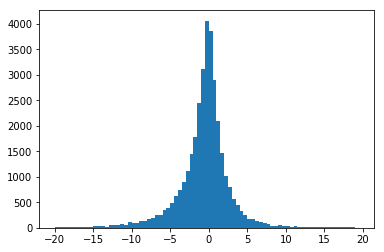

In [85]:
_ = plt.hist(np.array(residuals),bins=np.arange(-20,20,0.5))

In [87]:
# investigate hub dataset and assess forecast for hubs

In [88]:
# IMPORTANT: figure out how to choose between total fit and clustered fit
# as of now, test mean

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
clustered: 26.036132344243914;
 averaged: 17.28396831477513;
 total: 12.263613871880239
how many wrong zeros? 33


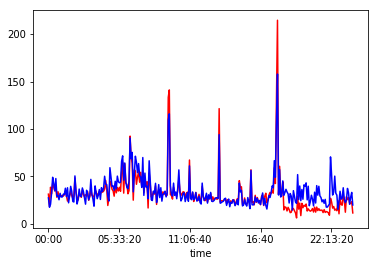

In [89]:
# fit1 + fit2 / 2

for name in RT[RT.columns[2]].iloc[0:1]:
    AEC = RT[RT[RT.columns[2]]==name][['Interval',' LMP']]
    AEC = AEC.rename(columns={' LMP':'LMP'})
    AEC_DA = DA2018[DA2018[DA2018.columns[2]]==name][['Interval','LMP']]
    AEC.index = AEC['Interval']
    AEC_DA.index = AEC_DA['Interval']
    DART_AEC = AEC_DA.join(AEC,how='right',lsuffix='_DA',rsuffix='_RT')
    DART_AEC = filler(DART_AEC, 'LMP_DA')
    DART_AEC[' LMP_DA'] = DART_AEC['LMP_DA']
    DART_AEC = DART_AEC.drop(columns=DART_AEC.columns[0:2])
    DART_AEC = add_info(DART_AEC)
    DART_AEC = DART_AEC.rename(columns={' LMP_DA':'LMP_DA'})
    
    n = 10
    clusters_array = np.empty(n)
    average_array = np.empty(n)
    total_array = np.empty(n)
    errors = 0
    check = 0
    check_list = []
    for i in range(n):
        clusters_pe = []
        average_pe = []
        total_pe = []
        for j in range(1,13):
            by_month = DART_AEC[DART_AEC['Month']==j]

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
            train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

            test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
            test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
            test_data['fitted RT (1)'] = (test_data['DA_sem']*result.params[3] +
                                    test_data['RT_sem']*result.params[2] +
                                    test_data['LMP_DA']*result.params[1] +
                                    result.params[0])
            
            size = test_data.index.shape[0]
            test_data['fitted RT (2)'] = np.zeros(size)            
            
            cl = clusters_dfs(ssr_split3(train_data, 'LMP_RT'))
            cl_plot = clusters2(ssr_split3(train_data, 'LMP_RT'))

            for cluster in cl:
                result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=cluster).fit()
                for hour in cluster.index:
                    try:
                        test_data['fitted RT (2)'].loc[hour] = (test_data['DA_sem'].loc[hour]*result.params[3] + 
                                                    test_data['RT_sem'].loc[hour]*result.params[2] + 
                                                    test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                    result.params[0])
                    except:
                        errors += 1
                        continue

            check = np.where(test_data['fitted RT (2)']==0.0,1,0).sum()
            if check > 0:
                check_list.append(check)
                        
            test_data['fitted RT'] = (test_data['fitted RT (1)'] + test_data['fitted RT (2)'])/2
            
            clusters_pe.append(offset(test_data['fitted RT (2)'], test_data['LMP_RT']).mean())
            average_pe.append(offset(test_data['fitted RT'], test_data['LMP_RT']).mean())
            total_pe.append(offset(test_data['fitted RT (1)'], test_data['LMP_RT']).mean())

            
            if i==1 and j==1:
                plt.plot(test_data.index, test_data['fitted RT'],'red')
                plt.plot(test_data.index, test_data['LMP_RT'],'blue')
 
        print('{}%'.format(10*i))

        clusters_array[i] = np.array(clusters_pe).mean()
        average_array[i] = np.array(average_pe).mean()
        total_array[i] = np.array(total_pe).mean()

    print('clustered: {};\n averaged: {};\n total: {}'.format(clusters_array.mean(),average_array.mean(),total_array.mean()))
    print('how many wrong zeros? {}'.format(check))

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9.050120264090223 0.43107638888888883


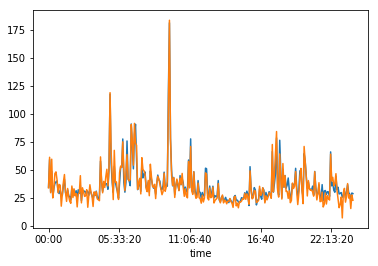

In [90]:
# assess when clustered fit is optimal
# grouping by 5-min interval, using 1 separate location, applied combined clustered fit

for name in RT[RT.columns[2]].iloc[0:1]:
    AEC = RT[RT[RT.columns[2]]==name][['Interval',' LMP']]
    AEC = AEC.rename(columns={' LMP':'LMP'})
    AEC_DA = DA2018[DA2018[DA2018.columns[2]]==name][['Interval','LMP']]
    AEC.index = AEC['Interval']
    AEC_DA.index = AEC_DA['Interval']
    DART_AEC = AEC_DA.join(AEC,how='right',lsuffix='_DA',rsuffix='_RT')
    DART_AEC = filler(DART_AEC, 'LMP_DA')
    DART_AEC[' LMP_DA'] = DART_AEC['LMP_DA']
    DART_AEC = DART_AEC.drop(columns=DART_AEC.columns[0:2])
    DART_AEC = add_info(DART_AEC)
    DART_AEC = DART_AEC.rename(columns={' LMP_DA':'LMP_DA'})
    
    n = 20
    clusters_array = np.empty(n)
    changes_array = np.empty(n)
    best_clusters = []
    errors = 0
    for i in range(n):
        clusters_pe = []
        changes_list = []
        for j in range(1,13):
            by_month = DART_AEC[DART_AEC['Month']==j]

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
            train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

            test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
            test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
            test_data['fitted RT (1)'] = (test_data['DA_sem']*result.params[3] +
                                    test_data['RT_sem']*result.params[2] +
                                    test_data['LMP_DA']*result.params[1] +
                                    result.params[0])
            
            size = test_data.index.shape[0]
            k = 0
            
            test_data['fitted RT'] = test_data['fitted RT (1)']
            test_data['fitted RT (2)'] = np.empty(size)            
            
            cl = clusters_dfs(ssr_split3(train_data, 'LMP_RT'))
            cl_plot = clusters2(ssr_split3(train_data, 'LMP_RT'))

            for cluster in cl:
                result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=cluster).fit()
                for hour in cluster.index:
                    try:
                        test_data['fitted RT (2)'].loc[hour] = (test_data['DA_sem'].loc[hour]*result.params[3] + 
                                                    test_data['RT_sem'].loc[hour]*result.params[2] + 
                                                    test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                    result.params[0])
                        if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                            abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                            test_data['fitted RT'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                            k += 1
                            best_clusters.append(hour)
                        else:
                            continue
                    except:
                        errors += 1
                        continue
                        
            clusters_pe.append(offset(test_data['fitted RT'],test_data['LMP_RT']))
            
            if i==1 and j==1:
                plt.plot(test_data.index, test_data['fitted RT'])
                plt.plot(test_data.index, test_data['LMP_RT'])
            
            changes_list.append(k/size)
        try:
            changes_array[i] = np.nanmean(np.array(changes_list))
            clusters_array[i] = np.nanmean(np.array(clusters_pe))
        except:
            continue
    print(np.nanmean(clusters_array), np.nanmean(changes_array))

In [91]:
len(best_clusters)

29796

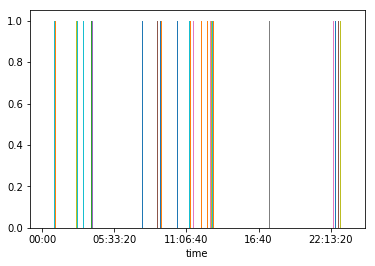

In [106]:
# _ = plt.hist(np.array(best_clusters[0:(3022)])) # not useful -- investigate why

In [129]:
# issue with unnesting
cl[4]

LMP_RT     LMP_DA     RT_sem    DA_sem      Means
Local Time                                                      
16:50:00    30.056967  26.453124   3.350601  1.697935  35.707931
16:55:00    46.806581  26.375424  10.735967  1.698423  35.707931
17:00:00    31.643267  27.484976   5.458203  1.588585  35.707931
17:05:00    25.982748  28.972310   2.217065  1.626851  35.707931
17:10:00    26.364305  30.326081   2.327349  1.843917  35.707931
17:15:00    24.509771  30.727200   1.473118  2.027346  35.707931
17:20:00    32.215811  34.387337   2.953932  2.099419  35.707931
17:25:00    36.288141  31.102255   4.616933  1.896137  35.707931
17:30:00    43.861017  33.273196  10.409892  1.945085  35.707931
17:35:00    53.713121  30.704487  15.054102  1.933782  35.707931
17:40:00    46.841044  32.673800  16.404593  2.379758  35.707931
17:45:00    30.212395  31.254671   2.200175  2.021447  35.707931

In [136]:
type(ssr_split3(train_data, 'LMP_RT')[1][1][0])

pandas.core.frame.DataFrame

In [137]:
train_data.shape

(288, 4)

In [84]:
def ssr_split4(df, s):
    if df.shape[0]>(288/4):
        smallest_y = 0
        smallest_x = 0
        for i in range(0, df.shape[0]):
            try:
                y_avg1 = df[s][0:i+1].values.mean()
                y_avg2 = df[s][i:df.shape[0]].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum() + ((df[s][i:df.shape[0]].values - y_avg2)**2).sum()
                if i == 0:
                    smallest_y = ssr
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
            except:
                y_avg1 = df[s].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum()
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
        smallest = df.iloc[0:smallest_x+1]
        largest = df.iloc[smallest_x+1:]
        if smallest.shape[0] > largest.shape[0]:
            temp = smallest
            smallest = largest
            largest = temp
        concat = [smallest] + [ssr_split4(largest, s)]
        return concat
    else:
        return df

def unnest(l, empty_l):
    for i in l:
        if type(i) == list:
            unnest(i, empty_l)
        else:
            empty_l.append(i)
            

In [85]:
empty = []
l = unnest(ssr_split3(train_data, 'LMP_RT'), empty)
len(empty)

11

In [86]:
te = []
unnest(ssr_split4(train_data, 'LMP_RT'), te)
len(te)

7

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
clustered: 12.269985016550468;
 averaged: 11.223428855172479;
    total: 12.135809690331644
multiple clusters perform better 50.07812500000001% of times


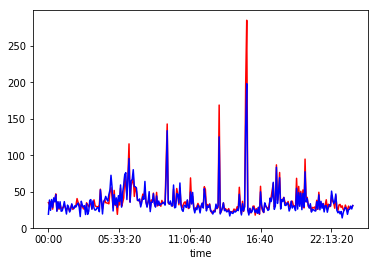

In [87]:
# fit1 + fit2 / 2 -- fixed clustering

for name in RT[RT.columns[2]].iloc[0:1]:
    AEC = RT[RT[RT.columns[2]]==name][['Interval',' LMP']]
    AEC = AEC.rename(columns={' LMP':'LMP'})
    AEC_DA = DA2018[DA2018[DA2018.columns[2]]==name][['Interval','LMP']]
    AEC.index = AEC['Interval']
    AEC_DA.index = AEC_DA['Interval']
    DART_AEC = AEC_DA.join(AEC,how='right',lsuffix='_DA',rsuffix='_RT')
    DART_AEC = filler(DART_AEC, 'LMP_DA')
    DART_AEC[' LMP_DA'] = DART_AEC['LMP_DA']
    DART_AEC = DART_AEC.drop(columns=DART_AEC.columns[0:2])
    DART_AEC = add_info(DART_AEC)
    DART_AEC = DART_AEC.rename(columns={' LMP_DA':'LMP_DA'})
    
    n = 10
    clusters_array = np.empty(n)
    average_array = np.empty(n)
    total_array = np.empty(n)
    errors = 0
    check_list = []
    changes_array = np.empty(n)
    best_array = np.empty(n)
    for i in range(n):
        clusters_pe = []
        average_pe = []
        total_pe = []
        changes_list = []
        best_list = []
        for j in range(1,13):
            by_month = DART_AEC[DART_AEC['Month']==j]

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
            train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

            test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
            test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
            test_data['fitted RT (1)'] = (test_data['DA_sem']*result.params[3] +
                                    test_data['RT_sem']*result.params[2] +
                                    test_data['LMP_DA']*result.params[1] +
                                    result.params[0])
            
            size = test_data.index.shape[0]
            k = 0
            test_data['fitted RT (2)'] = np.zeros(size)            
            test_data['fitted RT (best)'] = test_data['fitted RT (1)']
            
            cl = []
            unnest(ssr_split4(train_data, 'LMP_RT'), cl)

            for cluster in cl:
                result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=cluster).fit()
                for hour in cluster.index:
                    test_data['fitted RT (2)'].loc[hour] = (test_data['DA_sem'].loc[hour]*result.params[3] + 
                                                test_data['RT_sem'].loc[hour]*result.params[2] + 
                                                test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                result.params[0])
                    if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                        abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                        test_data['fitted RT (best)'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                        k += 1
                    else:
                        continue
            
            check = np.where(test_data['fitted RT (2)']==0.0,1,0).sum()
            if check > 0:
                check_list.append(check)
            
            test_data['fitted RT'] = (test_data['fitted RT (1)'] + test_data['fitted RT (2)'])/2
            
            clusters_pe.append(offset(test_data['fitted RT (2)'], test_data['LMP_RT']).mean())
            average_pe.append(offset(test_data['fitted RT'], test_data['LMP_RT']).mean())
            total_pe.append(offset(test_data['fitted RT (1)'], test_data['LMP_RT']).mean())
            best_list.append(offset(test_data['fitted RT (best)'], test_data['LMP_RT']).mean())
            changes_list.append(k/size)
            
            if i==1 and j==1:
                plt.plot(test_data.index, test_data['fitted RT'],'red')
                plt.plot(test_data.index, test_data['LMP_RT'],'blue')
 
        print('{}%'.format(10*i))

        clusters_array[i] = np.array(clusters_pe).mean()
        average_array[i] = np.array(average_pe).mean()
        total_array[i] = np.array(total_pe).mean()
        changes_array[i] = np.array(changes_list).mean()
        best_array[i] = np.array(best_list).mean()

        
    print('clustered: {};\n averaged: {};\n    total: {}'.format(clusters_array.mean(),average_array.mean(),total_array.mean()))
    print('multiple clusters perform better {}% of times'.format(100*changes_array.mean()))

In [88]:
print('how many weird zeros? {}'.format(check))
print('ideally, {}'.format(best_array.mean()))

how many weird zeros? 0
ideally, 8.631840851554571


In [89]:
# 1st assessment shows that single-cluster method is slightly better than multiple-clusters (12.2 vs 12.4 MAPE) 
stats.sem(clusters_array), stats.sem(total_array)
# but they agree within uncertainties

(0.10690086830814438, 0.1126947719182727)

In [91]:
def unnested_df(l):
    for df in l:
        means = np.empty(df.shape[0])
        means.fill(df['LMP_RT'].mean())
        df['Means'] = means
    unnested = pd.concat(l)
    unnested['Time'] = unnested.index
    unnested = unnested.sort_values('Time')
    return unnested

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


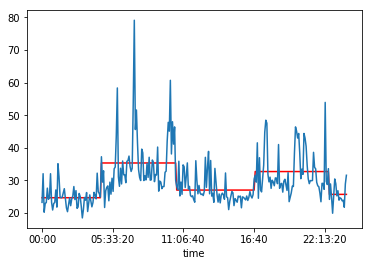

In [92]:
cl_plot = unnested_df(cl)
plt.plot(cl_plot.index, cl_plot['Means'], 'red')
plt.plot(train_data.index, train_data['LMP_RT'])

In [93]:
def ssr_split5(df, s, n):
    if df.shape[0]>(288/(n-1)):
        smallest_y = 0
        smallest_x = 0
        for i in range(0, df.shape[0]):
            try:
                y_avg1 = df[s][0:i+1].values.mean()
                y_avg2 = df[s][i:df.shape[0]].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum() + ((df[s][i:df.shape[0]].values - y_avg2)**2).sum()
                if i == 0:
                    smallest_y = ssr
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
            except:
                y_avg1 = df[s].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum()
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
        smallest = df.iloc[0:smallest_x+1]
        largest = df.iloc[smallest_x+1:]
        if smallest.shape[0] > largest.shape[0]:
            temp = smallest
            smallest = largest
            largest = temp
        concat = [smallest] + [ssr_split5(largest, s, n)]
        return concat
    else:
        return df


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


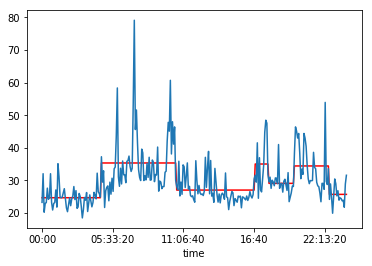

In [94]:
cl = []
unnest(ssr_split5(train_data, 'LMP_RT', 9), cl)
cl_plot = unnested_df(cl)
plt.plot(cl_plot.index, cl_plot['Means'], 'red')
plt.plot(train_data.index, train_data['LMP_RT'])

# determine optimal splitting (?)

0%


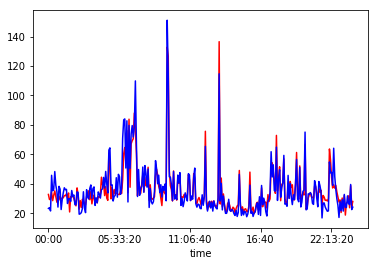

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


10%
20%
30%
40%
50%
60%
70%
80%
90%
clustered: 12.686314651756778;
 averaged: 11.479890608801774;
    total: 12.349062809155807
multiple clusters perform better 50.6568287037037% of times


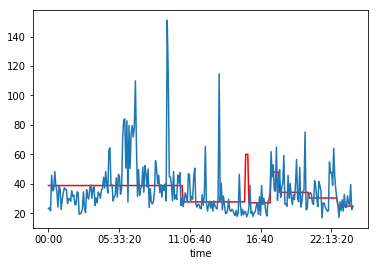

In [103]:
# fit1 + fit2 / 2 -- updated clustering, aiming for 6 clusters (AEC)

for name in RT[RT.columns[2]].iloc[0:1]:
    AEC = RT[RT[RT.columns[2]]==name][['Interval',' LMP']]
    AEC = AEC.rename(columns={' LMP':'LMP'})
    AEC_DA = DA2018[DA2018[DA2018.columns[2]]==name][['Interval','LMP']]
    AEC.index = AEC['Interval']
    AEC_DA.index = AEC_DA['Interval']
    DART_AEC = AEC_DA.join(AEC,how='right',lsuffix='_DA',rsuffix='_RT')
    DART_AEC = filler(DART_AEC, 'LMP_DA')
    DART_AEC[' LMP_DA'] = DART_AEC['LMP_DA']
    DART_AEC = DART_AEC.drop(columns=DART_AEC.columns[0:2])
    DART_AEC = add_info(DART_AEC)
    DART_AEC = DART_AEC.rename(columns={' LMP_DA':'LMP_DA'})
    
    n = 10
    clusters_array = np.empty(n)
    average_array = np.empty(n)
    total_array = np.empty(n)
    errors = 0
    check_list = []
    changes_array = np.empty(n)
    best_array = np.empty(n)
    for i in range(n):
        clusters_pe = []
        average_pe = []
        total_pe = []
        changes_list = []
        best_list = []
        for j in range(1,13):
            by_month = DART_AEC[DART_AEC['Month']==j]

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
            train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

            test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
            test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
            test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
            test_data['fitted RT (1)'] = (test_data['DA_sem']*result.params[3] +
                                    test_data['RT_sem']*result.params[2] +
                                    test_data['LMP_DA']*result.params[1] +
                                    result.params[0])
            
            size = test_data.index.shape[0]
            k = 0
            test_data['fitted RT (2)'] = np.zeros(size)            
            test_data['fitted RT (best)'] = test_data['fitted RT (1)']
            
            cl = []
            unnest(ssr_split5(train_data, 'LMP_RT',7), cl)

            for cluster in cl:
                result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=cluster).fit()
                for hour in cluster.index:
                    test_data['fitted RT (2)'].loc[hour] = (test_data['DA_sem'].loc[hour]*result.params[3] + 
                                                test_data['RT_sem'].loc[hour]*result.params[2] + 
                                                test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                                result.params[0])
                    if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                        abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                        test_data['fitted RT (best)'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                        k += 1
                    else:
                        continue
            
            check = np.where(test_data['fitted RT (2)']==0.0,1,0).sum()
            if check > 0:
                check_list.append(check)
            
            test_data['fitted RT'] = (test_data['fitted RT (1)'] + test_data['fitted RT (2)'])/2
            
            clusters_pe.append(offset(test_data['fitted RT (2)'], test_data['LMP_RT']).mean())
            average_pe.append(offset(test_data['fitted RT'], test_data['LMP_RT']).mean())
            total_pe.append(offset(test_data['fitted RT (1)'], test_data['LMP_RT']).mean())
            best_list.append(offset(test_data['fitted RT (best)'], test_data['LMP_RT']).mean())
            changes_list.append(k/size)
            
            if i==1 and j==1:
                plt.plot(test_data.index, test_data['fitted RT'],'red')
                plt.plot(test_data.index, test_data['LMP_RT'],'blue')
                plt.show()
                cl_plot = unnested_df(cl)
                plt.plot(cl_plot.index, cl_plot['Means'], 'red')
                plt.plot(test_data.index, test_data['LMP_RT'])

 
        print('{}%'.format(10*i))

        clusters_array[i] = np.array(clusters_pe).mean()
        average_array[i] = np.array(average_pe).mean()
        total_array[i] = np.array(total_pe).mean()
        changes_array[i] = np.array(changes_list).mean()
        best_array[i] = np.array(best_list).mean()

        
    print('clustered: {};\n averaged: {};\n    total: {}'.format(clusters_array.mean(),average_array.mean(),total_array.mean()))
    print('multiple clusters perform better {}% of times'.format(100*changes_array.mean()))

In [ ]:
# still got KeyError from indexes

In [227]:
# for now, multiple clusters and single cluster perform quite similar
# weirdly, k > 0.50

In [95]:
DART_gen_2018 = DART_gen_2018.rename(columns={'Local Time_price':'Local Time'})

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
clustered: 2.209485481166256;
 averaged: -8.752074465512818;
    total: -17.727626822463158
multiple clusters perform better 50.30671296296296% of times
how many weird zeros? 0
ideally, -2.248482731750767


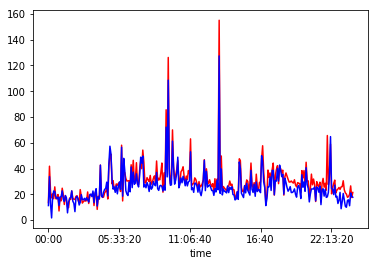

In [96]:
# fit1 + fit2 / 2 -- updated clustering (5 clusters)
# system-wide, 5 predictors

n = 10
clusters_array = np.empty(n)
average_array = np.empty(n)
total_array = np.empty(n)
errors = 0
check_list = []
changes_array = np.empty(n)
best_array = np.empty(n)
for i in range(n):
    clusters_pe = []
    average_pe = []
    total_pe = []
    changes_list = []
    best_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=train_data).fit()
        test_data['fitted RT (1)'] = (test_data['Wind']*result.params[5] +
                                test_data['Load']*result.params[4] +
                                test_data['DA_sem']*result.params[3] +
                                test_data['RT_sem']*result.params[2] +
                                test_data['LMP_DA']*result.params[1] +
                                result.params[0])

        size = test_data.index.shape[0]
        k = 0
        test_data['fitted RT (2)'] = np.zeros(size)            
        test_data['fitted RT (best)'] = test_data['fitted RT (1)']

        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)

        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            for hour in cluster.index:
                test_data['fitted RT (2)'].loc[hour] = (test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
                if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                    abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                    test_data['fitted RT (best)'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                    k += 1
                else:
                    continue

        check = np.where(test_data['fitted RT (2)']==0.0,1,0).sum()
        if check > 0:
            check_list.append(check)

        test_data['fitted RT'] = (test_data['fitted RT (1)'] + test_data['fitted RT (2)'])/2

        clusters_pe.append(offset(test_data['fitted RT (2)'], test_data['LMP_RT']).mean())
        average_pe.append(offset(test_data['fitted RT'], test_data['LMP_RT']).mean())
        total_pe.append(offset(test_data['fitted RT (1)'], test_data['LMP_RT']).mean())
        best_list.append(offset(test_data['fitted RT (best)'], test_data['LMP_RT']).mean())
        changes_list.append(k/size)

        if i==1 and j==1:
            plt.plot(test_data.index, test_data['fitted RT'],'red')
            plt.plot(test_data.index, test_data['LMP_RT'],'blue')

    print('{}%'.format(10*i))

    clusters_array[i] = np.array(clusters_pe).mean()
    average_array[i] = np.array(average_pe).mean()
    total_array[i] = np.array(total_pe).mean()
    changes_array[i] = np.array(changes_list).mean()
    best_array[i] = np.array(best_list).mean()


print('clustered: {};\n averaged: {};\n    total: {}'.format(clusters_array.mean(),average_array.mean(),total_array.mean()))
print('multiple clusters perform better {}% of times'.format(100*changes_array.mean()))
print('how many weird zeros? {}'.format(check))
print('ideally, {}'.format(best_array.mean()))

In [ ]:
# multi performed slightly better than single
# got messed up result when retesting

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
clustered: 13.483354819905376;
 averaged: 12.272309299566896;
    total: 13.939111281136203
multiple clusters perform better 52.4681712962963% of times
how many weird zeros? 0
ideally, 9.246595942393602


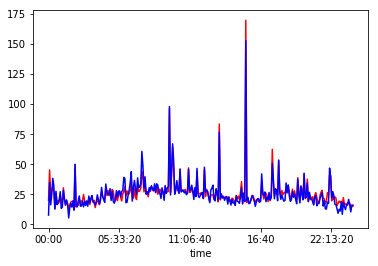

In [56]:
# fit1 + fit2 / 2 -- updated clustering (5 clusters)
# system-wide, 3 predictors

n = 10
clusters_array = np.empty(n)
average_array = np.empty(n)
total_array = np.empty(n)
errors = 0
check_list = []
changes_array = np.empty(n)
best_array = np.empty(n)
for i in range(n):
    clusters_pe = []
    average_pe = []
    total_pe = []
    changes_list = []
    best_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
        test_data['fitted RT (1)'] = (
                                test_data['DA_sem']*result.params[3] +
                                test_data['RT_sem']*result.params[2] +
                                test_data['LMP_DA']*result.params[1] +
                                result.params[0])

        size = test_data.index.shape[0]
        k = 0
        test_data['fitted RT (2)'] = np.zeros(size)            
        test_data['fitted RT (best)'] = test_data['fitted RT (1)']

        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)

        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=cluster).fit()
            for hour in cluster.index:
                test_data['fitted RT (2)'].loc[hour] = (
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
                if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                    abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                    test_data['fitted RT (best)'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                    k += 1
                else:
                    continue

        check = np.where(test_data['fitted RT (2)']==0.0,1,0).sum()
        if check > 0:
            check_list.append(check)

        test_data['fitted RT'] = (test_data['fitted RT (1)'] + test_data['fitted RT (2)'])/2

        clusters_pe.append(offset(test_data['fitted RT (2)'], test_data['LMP_RT']).mean())
        average_pe.append(offset(test_data['fitted RT'], test_data['LMP_RT']).mean())
        total_pe.append(offset(test_data['fitted RT (1)'], test_data['LMP_RT']).mean())
        best_list.append(offset(test_data['fitted RT (best)'], test_data['LMP_RT']).mean())
        changes_list.append(k/size)

        if i==1 and j==1:
            plt.plot(test_data.index, test_data['fitted RT'],'red')
            plt.plot(test_data.index, test_data['LMP_RT'],'blue')

    print('{}%'.format(10*i))

    clusters_array[i] = np.array(clusters_pe).mean()
    average_array[i] = np.array(average_pe).mean()
    total_array[i] = np.array(total_pe).mean()
    changes_array[i] = np.array(changes_list).mean()
    best_array[i] = np.array(best_list).mean()


print('clustered: {};\n averaged: {};\n    total: {}'.format(clusters_array.mean(),average_array.mean(),total_array.mean()))
print('multiple clusters perform better {}% of times'.format(100*changes_array.mean()))
print('how many weird zeros? {}'.format(check))
print('ideally, {}'.format(best_array.mean()))

In [107]:
stats.sem(clusters_array),stats.sem(total_array)

(0.17485276815287093, 0.1329525643610866)

In [108]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LMP_RT   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     108.7
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           3.77e-21
Time:                        15:22:14   Log-Likelihood:                -114.71
No. Observations:                  51   AIC:                             237.4
Df Residuals:                      47   BIC:                             245.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.4802      3.048      5.406      0.000      10.347      22.613
LMP_DA         0.2750      0.138      1.988      0.053      -0.003       0.553
RT_sem         1.4739      0.083     17.701      0.000       1.306       1.641
DA_sem        -2.0276      1.637     -1.239      0.222      -5.320       1.265
==============================================================================
Omnibus:                        2.123   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.346   Jarque-Bera (JB):                1.888
Skew:                           0.463   Prob(JB):                        0.389
Kurtosis:                       2.826   Cond. No.                         283.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
clustered: 13.84215896073917;
 averaged: 12.690977607784623;
    total: 14.2861449773169
multiple clusters perform better 51.88946759259259% of times
how many weird zeros? 0
ideally, 9.51854988550554
weight on single: 13.180742177930867;
weight on multiple: 12.896517945330734


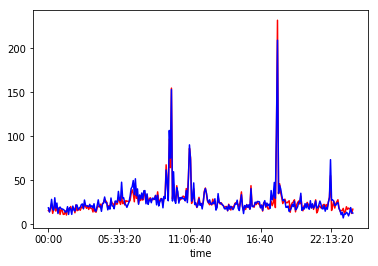

In [109]:
# fit1 + fit2 / 2 -- updated clustering (5 clusters)
# system-wide, 3 predictors
# testing different weights for method 1 and 2

n = 10
clusters_array = np.empty(n)
average_array = np.empty(n)
total_array = np.empty(n)
errors = 0
check_list = []
changes_array = np.empty(n)
best_array = np.empty(n)
weight1_array = np.empty(n)
weight2_array = np.empty(n)
for i in range(n):
    clusters_pe = []
    average_pe = []
    total_pe = []
    changes_list = []
    best_list = []
    weight1_list = []
    weight2_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
        test_data['fitted RT (1)'] = (
                                test_data['DA_sem']*result.params[3] +
                                test_data['RT_sem']*result.params[2] +
                                test_data['LMP_DA']*result.params[1] +
                                result.params[0])

        size = test_data.index.shape[0]
        k = 0
        test_data['fitted RT (2)'] = np.zeros(size)            
        test_data['fitted RT (best)'] = test_data['fitted RT (1)']

        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)

        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=cluster).fit()
            for hour in cluster.index:
                test_data['fitted RT (2)'].loc[hour] = (
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
                if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                    abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                    test_data['fitted RT (best)'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                    k += 1
                else:
                    continue

        check = np.where(test_data['fitted RT (2)']==0.0,1,0).sum()
        if check > 0:
            check_list.append(check)

        test_data['fitted RT'] = (test_data['fitted RT (1)'] + test_data['fitted RT (2)'])/2

        clusters_pe.append(offset(test_data['fitted RT (2)'], test_data['LMP_RT']).mean())
        average_pe.append(offset(test_data['fitted RT'], test_data['LMP_RT']).mean())
        total_pe.append(offset(test_data['fitted RT (1)'], test_data['LMP_RT']).mean())
        best_list.append(offset(test_data['fitted RT (best)'], test_data['LMP_RT']).mean())
        changes_list.append(k/size)
        weight1_list.append(offset((0.75*test_data['fitted RT (1)']+0.25*test_data['fitted RT (2)']), test_data['LMP_RT']).mean())
        weight2_list.append(offset((0.25*test_data['fitted RT (1)']+0.75*test_data['fitted RT (2)']), test_data['LMP_RT']).mean())


        if i==1 and j==1:
            plt.plot(test_data.index, test_data['fitted RT'],'red')
            plt.plot(test_data.index, test_data['LMP_RT'],'blue')

    print('{}%'.format(10*i))

    clusters_array[i] = np.array(clusters_pe).mean()
    average_array[i] = np.array(average_pe).mean()
    total_array[i] = np.array(total_pe).mean()
    changes_array[i] = np.array(changes_list).mean()
    best_array[i] = np.array(best_list).mean()
    weight1_array[i] = np.array(weight1_list).mean()
    weight2_array[i] = np.array(weight2_list).mean()


print('clustered: {};\n averaged: {};\n    total: {}'.format(clusters_array.mean(),average_array.mean(),total_array.mean()))
print('multiple clusters perform better {}% of times'.format(100*changes_array.mean()))
print('how many weird zeros? {}'.format(check))
print('ideally, {}'.format(best_array.mean()))
print('weight on single: {};\nweight on multiple: {}'.format(weight1_array.mean(),weight2_array.mean()))

##### let's study R^2

In [97]:
# system-wide, 3 vs 5 predictors -- comparing R^2

n = 100
single3_PE_array = np.empty(n)
single3_R2_array = np.empty(n)
single5_PE_array = np.empty(n)
single5_R2_array = np.empty(n)
for i in range(n):
    single3_PE_list = []
    single3_R2_list = []
    single5_PE_list = []
    single5_R2_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        result3 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem", data=train_data).fit()
        test_data['fitted RT (3)'] = (
                                test_data['DA_sem']*result3.params[3] +
                                test_data['RT_sem']*result3.params[2] +
                                test_data['LMP_DA']*result3.params[1] +
                                result3.params[0])
        single3_PE_list.append(offset(test_data['fitted RT (3)'],test_data['LMP_RT']).mean())
        single3_R2_list.append(result3.rsquared)
        
        result5 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=train_data).fit()
        test_data['fitted RT (5)'] = (test_data['Wind']*result5.params[5] +
                                test_data['Load']*result5.params[4] +
                                test_data['DA_sem']*result5.params[3] +
                                test_data['RT_sem']*result5.params[2] +
                                test_data['LMP_DA']*result5.params[1] +
                                result5.params[0])
        single5_PE_list.append(offset(test_data['fitted RT (5)'],test_data['LMP_RT']).mean())
        single5_R2_list.append(result5.rsquared)
    
    single3_PE_array[i] = np.array(single3_PE_list).mean()
    single3_R2_array[i] = np.array(single3_R2_list).mean()
    single5_PE_array[i] = np.array(single5_PE_list).mean()
    single5_R2_array[i] = np.array(single5_R2_list).mean()
    
    if i%10==0:
        print('{}%'.format(i))


print('3 predictors:\n\tMAPE: {};\n\tMean R^2: {};'.format(single3_PE_array.mean(),single3_R2_array.mean()))
print('5 predictors:\n\tMAPE: {};\n\tMean R^2: {};'.format(single5_PE_array.mean(),single5_R2_array.mean()))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
3 predictors:
	MAPE: 13.997089849337147;
	Mean R^2: 0.9227716108831389;
5 predictors:
	MAPE: 13.24385950657407;
	Mean R^2: 0.9433650553599534;


In [112]:
# 5 predictors showed better results as expected (even though some previous test pointed otherwise)

In [100]:
DART_gen_2018['Coal'] = DART_gen_2018['Coal_Mkt'] + DART_gen_2018['Coal_Self']

In [101]:
# system-wide, 5 vs 6 predictors -- comparing R^2

n = 100
single3_PE_array = np.empty(n)
single3_R2_array = np.empty(n)
single3_R2adj_array = np.empty(n)
single5_PE_array = np.empty(n)
single5_R2_array = np.empty(n)
single5_R2adj_array = np.empty(n)
for i in range(n):
    single3_PE_list = []
    single3_R2_list = []
    single3_R2adj_list = []
    single5_PE_list = []
    single5_R2_list = []
    single5_R2adj_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Coal", data=train_data).fit()
        test_data['fitted RT (6)'] = (test_data['Coal']*result6.params[6] +
                                test_data['Wind']*result6.params[5] +
                                test_data['Load']*result6.params[4] +
                                test_data['DA_sem']*result6.params[3] +
                                test_data['RT_sem']*result6.params[2] +
                                test_data['LMP_DA']*result6.params[1] +
                                result6.params[0])
        single3_PE_list.append(offset(test_data['fitted RT (6)'],test_data['LMP_RT']).mean())
        single3_R2_list.append(result6.rsquared)
        single3_R2adj_list.append(result6.rsquared_adj)
        
        result5 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=train_data).fit()
        test_data['fitted RT (5)'] = (test_data['Wind']*result5.params[5] +
                                test_data['Load']*result5.params[4] +
                                test_data['DA_sem']*result5.params[3] +
                                test_data['RT_sem']*result5.params[2] +
                                test_data['LMP_DA']*result5.params[1] +
                                result5.params[0])
        single5_PE_list.append(offset(test_data['fitted RT (5)'],test_data['LMP_RT']).mean())
        single5_R2_list.append(result5.rsquared)
        single5_R2adj_list.append(result5.rsquared_adj)

    
    single3_PE_array[i] = np.array(single3_PE_list).mean()
    single3_R2_array[i] = np.array(single3_R2_list).mean()
    single3_R2adj_array[i] = np.array(single3_R2adj_list).mean()
    single5_PE_array[i] = np.array(single5_PE_list).mean()
    single5_R2_array[i] = np.array(single5_R2_list).mean()
    single5_R2adj_array[i] = np.array(single5_R2adj_list).mean()
    
    if i%10==0:
        print('{}%'.format(i))


print('6 predictors:\n\tMAPE: {};\n\tMean R^2: {};'.format(single3_PE_array.mean(),single3_R2_array.mean()))
print('\tMean Adj R^2: {}'.format(single3_R2adj_array.mean()))
print('5 predictors:\n\tMAPE: {};\n\tMean R^2: {};'.format(single5_PE_array.mean(),single5_R2_array.mean()))
print('\tMean Adj R^2: {}'.format(single5_R2adj_array.mean()))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
6 predictors:
	MAPE: 17.40014500832002;
	Mean R^2: 0.9446154211089555;
	Mean Adj R^2: 0.9434328322358371
5 predictors:
	MAPE: 17.177488755869895;
	Mean R^2: 0.9432832969499912;
	Mean Adj R^2: 0.9422776816476863


In [103]:
single5_PE_array.max() # got an extraordinarily bad one

422.7593031739494

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
single cluster:
	MAPE: 13.408949144743621;
	Mean R^2: 0.9444396672947433;
multiple clusters:
	MAPE: 14.095454688865749;
	Mean R^2: 0.8839058740765499;


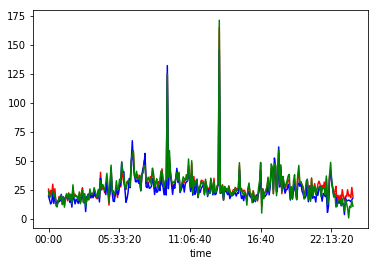

In [104]:
# system-wide, 5 predictors
# multi or single clustered -- comparings R^2

n = 10
single_PE_array = np.empty(n)
single_R2_array = np.empty(n)
multi_PE_array = np.empty(n)
multi_R2_array = np.empty(n)

for i in range(n):
    single_PE_list = []
    single_R2_list = []
    multi_PE_list = []
    multi_R2_list = []

    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        result6 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Coal", data=train_data).fit()
        single_R2_list.append(result6.rsquared)
        test_data['fitted RT (single)'] = (test_data['Coal']*result6.params[6] +
                                test_data['Wind']*result6.params[5] +
                                test_data['Load']*result6.params[4] +
                                test_data['DA_sem']*result6.params[3] +
                                test_data['RT_sem']*result6.params[2] +
                                test_data['LMP_DA']*result6.params[1] +
                                result6.params[0])

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Coal", data=cluster).fit()
            multi_R2_list.append(result.rsquared)
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (test_data['Coal'].loc[hour]*result.params[6] + 
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])

        single_PE_list.append(offset(test_data['fitted RT (single)'], test_data['LMP_RT']).mean())
        multi_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())
        
        if i==1 and j==1:
            plt.plot(test_data.index, test_data['fitted RT (single)'],'red')
            plt.plot(test_data.index, test_data['LMP_RT'],'blue')
            plt.plot(test_data.index, test_data['fitted RT (multi)'],'green')


    print('{}%'.format(10*i))

    single_PE_array[i] = np.array(single_PE_list).mean()
    single_R2_array[i] = np.array(single_R2_list).mean()
    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()


print('single cluster:\n\tMAPE: {};\n\tMean R^2: {};'.format(single_PE_array.mean(),single_R2_array.mean()))
print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(multi_PE_array.mean(),multi_R2_array.mean()))

In [105]:
def means_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = np.nanmean(np.array(d[key]))
    m = []
    for value in means_d.values():
        m.append(value)
    total_mean = np.nanmean(np.array(m))
    return means_d, total_mean

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multiple clusters:
	MAPE: 13.732165470978964;
	Mean R^2: 0.888452701780247;
check: 0


({0: 0.7271514294536826,
  1: 0.8919768218146122,
  2: 0.9113364064792688,
  3: 0.9336138196122715,
  4: 0.9441352764679334,
  5: 0.9233655427094865,
  6: 0.9183664622925767,
  7: 0.9297472004298482,
  8: 0.9460039812449041},
 0.9028552156116206)

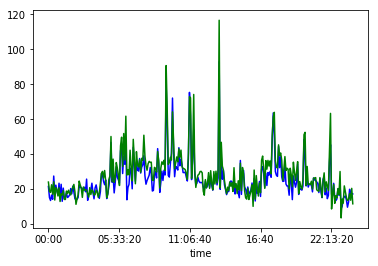

In [63]:
# system-wide, 5 predictors
# multi clustered -- dive into each cluster's R^2

n = 10
multi_PE_array = np.empty(n)
multi_R2_array = np.empty(n)

clusters_dict = {}

checks = []
for i in range(n):
    multi_PE_list = []
    multi_R2_list = []
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        k = 0
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Coal", data=cluster).fit()
            multi_R2_list.append(result.rsquared)
            if k not in clusters_dict.keys():
                clusters_dict[k] = []
                clusters_dict[k].append(result.rsquared)
            else:
                clusters_dict[k].append(result.rsquared) 
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (test_data['Coal'].loc[hour]*result.params[6] + 
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
            k += 1

        multi_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())

        check = np.where(test_data['fitted RT (multi)']==0.0,1,0).sum()
        if check > 0:
            checks.append(check)
            
        
        if i==1 and j==1:
            plt.plot(test_data.index, test_data['LMP_RT'],'blue')
            plt.plot(test_data.index, test_data['fitted RT (multi)'],'green')


    print('{}%'.format(10*i))

    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()


print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(multi_PE_array.mean(),multi_R2_array.mean()))
print('check: {}'.format(len(checks)))
r = means_dict(clusters_dict)
r[0],r[1]

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multiple clusters:
	MAPE: 13.876913722187846;
	Mean R^2: 0.8907705498490686;
	Mean # of clusters: 6.108333333333333


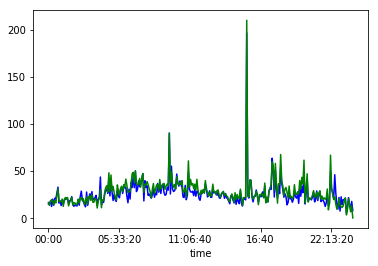

In [64]:
# getting too many clusters, further investigate:

n = 10
multi_PE_array = np.empty(n)
multi_R2_array = np.empty(n)
ks = []

for i in range(n):
    multi_PE_list = []
    multi_R2_list = []
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        k = 0
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Coal", data=cluster).fit()
            multi_R2_list.append(result.rsquared)
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (test_data['Coal'].loc[hour]*result.params[6] + 
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
            k += 1

        multi_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())
        ks.append(k)
        
        if i==1 and j==1:
            plt.plot(test_data.index, test_data['LMP_RT'],'blue')
            plt.plot(test_data.index, test_data['fitted RT (multi)'],'green')


    print('{}%'.format(10*i))

    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()


print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(multi_PE_array.mean(),multi_R2_array.mean()))
print('\tMean # of clusters: {}'.format(np.array(ks).mean()))

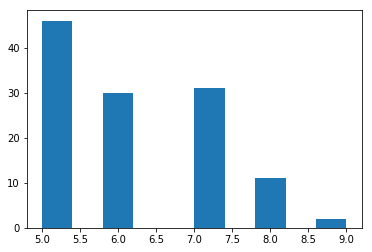

In [65]:
_ = plt.hist(np.array(ks))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multiple clusters:
	MAPE: 14.880140533403324;
	Mean R^2: 0.8886512882775854;
	Mean # of clusters: 5.933333333333334


({0: 0.7271514294536826,
  1: 0.8919768218146122,
  2: 0.9113364064792688,
  3: 0.9336138196122715,
  4: 0.9441352764679334,
  5: 0.9233655427094865,
  6: 0.9183664622925767,
  7: 0.9297472004298482,
  8: 0.9460039812449041},
 0.9028552156116206)

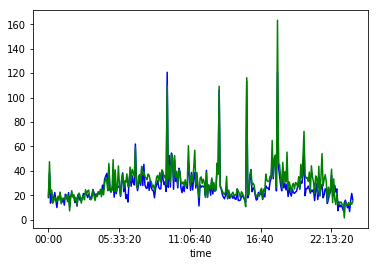

In [66]:
# getting too many clusters -- let's investigate R^s by # of clusters

n = 10
multi_PE_array = np.empty(n)
multi_R2_array = np.empty(n)
ks = []

clusters_R2 = {}

for i in range(n):
    multi_PE_list = []
    multi_R2_list = []
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        k = 0
        rs = []
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Coal", data=cluster).fit()
            multi_R2_list.append(result.rsquared)
            rs.append(result.rsquared)
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (test_data['Coal'].loc[hour]*result.params[6] + 
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
            k += 1

        multi_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())
        ks.append(k)
        
        if k not in clusters_R2.keys():
            clusters_R2[k] = []
            clusters_R2[k].append(np.array(rs).mean())
        else:
            clusters_R2[k].append(np.array(rs).mean())            
        
        if i==1 and j==1:
            plt.plot(test_data.index, test_data['LMP_RT'],'blue')
            plt.plot(test_data.index, test_data['fitted RT (multi)'],'green')


    print('{}%'.format(10*i))

    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()


print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(multi_PE_array.mean(),multi_R2_array.mean()))
print('\tMean # of clusters: {}'.format(np.array(ks).mean()))
r = means_dict(clusters_R2)
r[0],r[1]

In [156]:
r = means_dict(clusters_R2)
r[0],r[1]

({6: 0.8857579855302379,
  7: 0.916096455978141,
  8: 0.9035931352660055,
  5: 0.8647827477009492,
  9: 0.8928371619470425,
  10: 0.9110096098300813},
 0.8956795160420762)

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


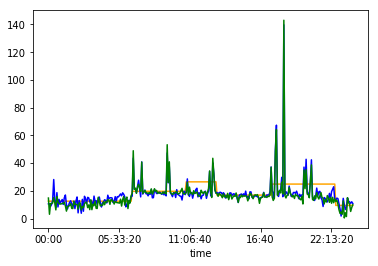

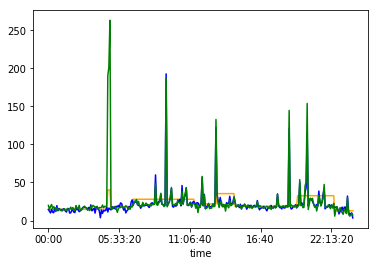

0%


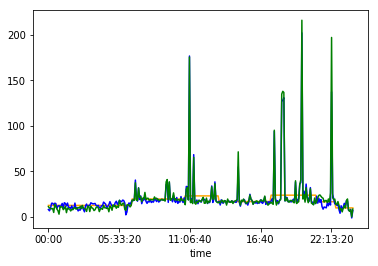

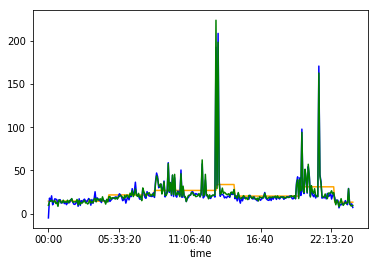

10%


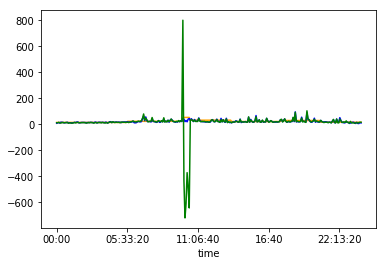

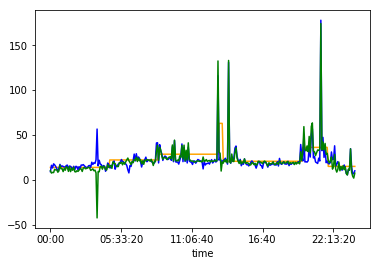

20%


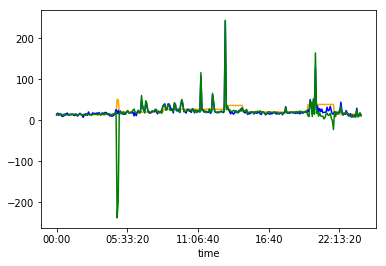

30%


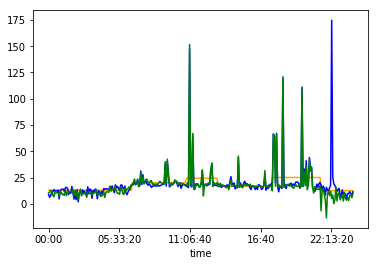

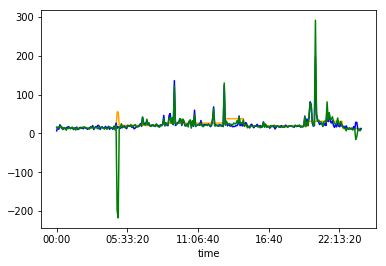

40%


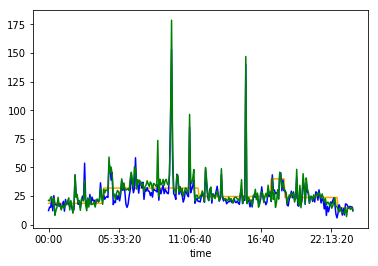

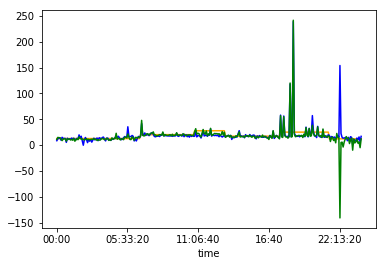

50%


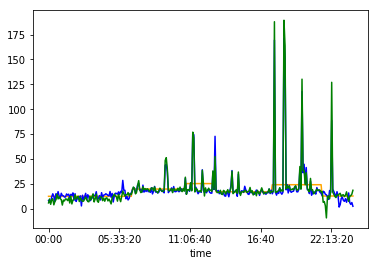

60%


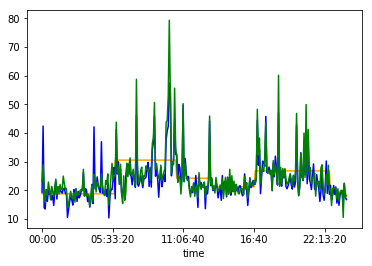

70%


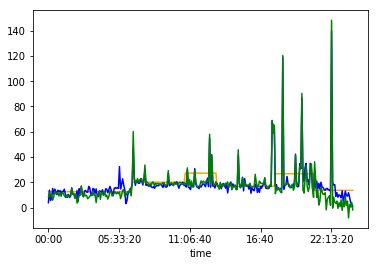

80%


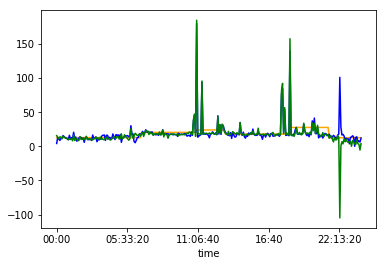

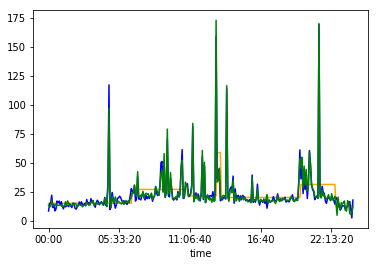

90%
multiple clusters:
	MAPE: 10.366414103372438;
	Mean R^2: 0.8882966960174563;
	Mean # of clusters: 6.125
17.5% of months were discarded due to low performance


({5: 0.8748440800894285,
  7: 0.8886964431933145,
  6: 0.8808717137461255,
  9: 0.9361157966212791,
  8: 0.9172787755054312,
  10: 0.9619077072459581},
 0.9099524194002561)

In [106]:
# let's study the small R^2 clusters
# getting too many clusters -- let's investigate R^s by # of clusters

n = 10
multi_PE_array = np.zeros(n)
multi_R2_array = np.zeros(n)
ks = []

clusters_R2 = {}
lows = 0

for i in range(n):
    multi_PE_list = []
    multi_R2_list = []
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        k = 0
        rs = []
        alert = False
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Coal", data=cluster).fit()
            multi_R2_list.append(result.rsquared)
            rs.append(result.rsquared)
            if result.rsquared < 0.5:
                alert = True
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (test_data['Coal'].loc[hour]*result.params[6] + 
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
            k += 1

        if alert == False:
            multi_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())
            
        ks.append(k)
        
        if k not in clusters_R2.keys():
            clusters_R2[k] = []
            clusters_R2[k].append(np.array(rs).mean())
        else:
            clusters_R2[k].append(np.array(rs).mean())            
        
        if alert == True:
            lows += 1
            cl_plot = unnested_df(cl)
            plt.plot(cl_plot.index, cl_plot['Means'],'orange')
            plt.plot(test_data.index, test_data['LMP_RT'],'blue')
            plt.plot(test_data.index, test_data['fitted RT (multi)'],'green')
            plt.show()


    print('{}%'.format(10*i))

    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()

MAPE = multi_PE_array.sum()/np.nonzero(multi_PE_array)[0].size
R2 = multi_R2_array.sum()/np.nonzero(multi_R2_array)[0].size

print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(MAPE,R2))
print('\tMean # of clusters: {}'.format(np.array(ks).mean()))
print('{}% of months were discarded due to low performance'.format(100*lows/(12*n)))
r = means_dict(clusters_R2)
r[0],r[1]

In [ ]:
# clusters that are too small -- trained on peaks -- predict poorly for other results

In [86]:
multi_PE_array

array([11.30545296, 16.19011965, 12.19403012, 11.2523089 , 13.41653861,
       11.98943539, 11.96504106, 12.55282464, 12.31006292, 12.05223589])

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multiple clusters:
	MAPE: 14.562167161148173;
	Mean R^2: 0.8893736128341452;
	Mean # of clusters: 6.225
19.166666666666668% of months were discarded due to low performance


({6: 0.8789459202184985,
  7: 0.9181154478612654,
  5: 0.8700113456856523,
  4: 0.9183536349462396,
  8: 0.9103302487180914,
  9: 0.8773146319001585,
  10: 0.8945223023286036},
 0.8953705045226441)

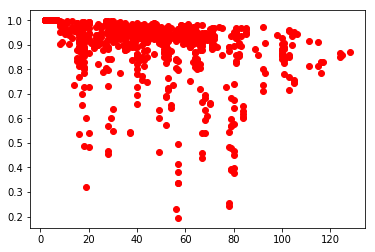

In [93]:
# cluster size vs R^2

# getting too many clusters -- let's investigate R^s by # of clusters

n = 10
multi_PE_array = np.zeros(n)
multi_R2_array = np.zeros(n)
ks = []

clusters_R2 = {}
lows = 0

cluster_sizes = []
cluster_rs = []

for i in range(n):
    multi_PE_list = []
    multi_R2_list = []
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Coal']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        k = 0
        rs = []
        alert = False
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind + Coal", data=cluster).fit()
            multi_R2_list.append(result.rsquared)
            rs.append(result.rsquared)
            cluster_rs.append(result.rsquared)
            cluster_sizes.append(cluster.index.size)
            if result.rsquared < 0.5:
                alert = True
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (test_data['Coal'].loc[hour]*result.params[6] + 
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
            k += 1

        if alert == False:
            multi_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())
            
        ks.append(k)
        
        if k not in clusters_R2.keys():
            clusters_R2[k] = []
            clusters_R2[k].append(np.array(rs).mean())
        else:
            clusters_R2[k].append(np.array(rs).mean())            
        
        if alert == True:
            lows += 1
            #cl_plot = unnested_df(cl)
            #plt.plot(cl_plot.index, cl_plot['Means'],'orange')
            #plt.plot(test_data.index, test_data['LMP_RT'],'blue')
            #plt.plot(test_data.index, test_data['fitted RT (multi)'],'green')
            #plt.show()


    print('{}%'.format(10*i))

    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()

print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(multi_PE_array.mean(),multi_R2_array.mean()))
print('\tMean # of clusters: {}'.format(np.array(ks).mean()))
print('{}% of months were discarded due to low performance'.format(100*lows/(12*n)))
plt.plot(np.array(cluster_sizes),np.array(cluster_rs),'ro')
r = means_dict(clusters_R2)
r[0],r[1]

In [94]:
# running previous tests without coal
# cluster size vs R^2

# getting too many clusters -- let's investigate R^s by # of clusters

n = 10
multi_PE_array = np.zeros(n)
multi_R2_array = np.zeros(n)
ks = []

clusters_R2 = {}
lows = 0

cluster_sizes = []
cluster_rs = []

for i in range(n):
    multi_PE_list = []
    multi_R2_list = []
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        k = 0
        rs = []
        alert = False
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            multi_R2_list.append(result.rsquared)
            rs.append(result.rsquared)
            cluster_rs.append(result.rsquared)
            cluster_sizes.append(cluster.index.size)
            if result.rsquared < 0.5:
                alert = True
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
            k += 1

        if alert == False:
            multi_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())
            
        ks.append(k)
        
        if k not in clusters_R2.keys():
            clusters_R2[k] = []
            clusters_R2[k].append(np.array(rs).mean())
        else:
            clusters_R2[k].append(np.array(rs).mean())            
        
        if alert == True:
            lows += 1
            #cl_plot = unnested_df(cl)
            #plt.plot(cl_plot.index, cl_plot['Means'],'orange')
            #plt.plot(test_data.index, test_data['LMP_RT'],'blue')
            #plt.plot(test_data.index, test_data['fitted RT (multi)'],'green')
            #plt.show()


    print('{}%'.format(10*i))

    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()

print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(multi_PE_array.mean(),multi_R2_array.mean()))
print('\tMean # of clusters: {}'.format(np.array(ks).mean()))
print('{}% of months were discarded due to low performance'.format(100*lows/(12*n)))
plt.plot(np.array(cluster_sizes),np.array(cluster_rs),'ro')
r = means_dict(clusters_R2)
r[0],r[1]

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multiple clusters:
	MAPE: 12.824923521392074;
	Mean R^2: 0.8801737457459458;
	Mean # of clusters: 6.133333333333334
23.333333333333332% of months were discarded due to low performance


({6: 0.8719979124672396,
  5: 0.8651448793211655,
  9: 0.9231640195197819,
  4: 0.9108934107048997,
  8: 0.8978188821811026,
  7: 0.8902154842823226},
 0.8932057647460853)

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multiple clusters:
	MAPE: 13.114806097536874;
	Mean R^2: 0.8872062976574309;
	Mean # of clusters: 6.125
16.666666666666668% of months were discarded due to low performance
Keeping all months: 
	MAPE: 14.022555459837989


({7: 0.9080415510848848,
  6: 0.8759759382432053,
  9: 0.9003323945453742,
  5: 0.8649302782407233,
  10: 0.9199765137043262,
  8: 0.9255866188324998,
  4: 0.9260215522841067},
 0.9029806924193029)

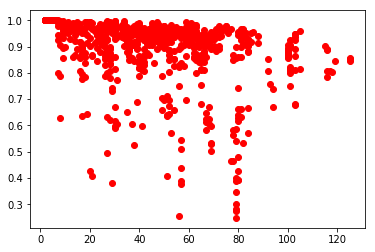

In [95]:
# now, let's test: discard vs keep low-R^2 fits

# running previous tests without coal
# cluster size vs R^2

# getting too many clusters -- let's investigate R^s by # of clusters

n = 10
multi_PE_array = np.zeros(n)
multi_R2_array = np.zeros(n)
keep_PE_array = np.zeros(n)
ks = []

clusters_R2 = {}
lows = 0

cluster_sizes = []
cluster_rs = []

for i in range(n):
    multi_PE_list = []
    multi_R2_list = []
    keep_PE_list = []
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        k = 0
        rs = []
        alert = False
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            multi_R2_list.append(result.rsquared)
            rs.append(result.rsquared)
            cluster_rs.append(result.rsquared)
            cluster_sizes.append(cluster.index.size)
            if result.rsquared < 0.5:
                alert = True
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
            k += 1

        if alert == False:
            multi_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())

        keep_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())
        
        ks.append(k)
        
        if k not in clusters_R2.keys():
            clusters_R2[k] = []
            clusters_R2[k].append(np.array(rs).mean())
        else:
            clusters_R2[k].append(np.array(rs).mean())            
        
        if alert == True:
            lows += 1


    print('{}%'.format(10*i))

    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()
    keep_PE_array[i] = np.array(keep_PE_list).mean()

print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(multi_PE_array.mean(),multi_R2_array.mean()))
print('\tMean # of clusters: {}'.format(np.array(ks).mean()))
print('{}% of months were discarded due to low performance'.format(100*lows/(12*n)))
print('Keeping all months: \n\tMAPE: {}'.format(keep_PE_array.mean()))
plt.plot(np.array(cluster_sizes),np.array(cluster_rs),'ro')
r = means_dict(clusters_R2)
r[0],r[1]

In [ ]:
# number of clusters and size of clusters don't seem to have a great impact on R^2

In [107]:
# now, let's test: which clusters are being discarded (1st, 2nd, ...)
# cluster size vs R^2


n = 10
multi_PE_array = np.zeros(n)
multi_R2_array = np.zeros(n)
keep_PE_array = np.zeros(n)
ks = []

clusters_R2 = {}
lows = 0

cluster_sizes = []
cluster_rs = []

discarded_ks = []

for i in range(n):
    multi_PE_list = []
    multi_R2_list = []
    keep_PE_list = []
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        k = 0
        rs = []
        alert = False
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            multi_R2_list.append(result.rsquared)
            rs.append(result.rsquared)
            cluster_rs.append(result.rsquared)
            cluster_sizes.append(cluster.index.size)
            if result.rsquared < 0.5:
                alert = True
                discarded_ks.append(k)
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
            k += 1

        if alert == False:
            multi_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())

        keep_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())
        
        ks.append(k)
        
        if k not in clusters_R2.keys():
            clusters_R2[k] = []
            clusters_R2[k].append(np.array(rs).mean())
        else:
            clusters_R2[k].append(np.array(rs).mean())            
        
        if alert == True:
            lows += 1


    print('{}%'.format(10*i))

    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()
    keep_PE_array[i] = np.array(keep_PE_list).mean()

print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(multi_PE_array.mean(),multi_R2_array.mean()))
print('\tMean # of clusters: {}'.format(np.array(ks).mean()))
print('{}% of months were discarded due to low performance'.format(100*lows/(12*n)))
print('Keeping all months: \n\tMAPE: {}'.format(keep_PE_array.mean()))
plt.plot(np.array(cluster_sizes),np.array(cluster_rs),'ro')
r = means_dict(clusters_R2)
r[0],r[1]

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multiple clusters:
	MAPE: 12.11570084858208;
	Mean R^2: 0.8823112086505969;
	Mean # of clusters: 6.216666666666667
21.666666666666668% of months were discarded due to low performance
Keeping all months: 
	MAPE: 16.3540470991069


({7: 0.8935226578009404,
  6: 0.8656241490957988,
  5: 0.8627403491631016,
  9: 0.9032246256995509,
  8: 0.9290628479817338,
  4: 0.9131971334645845,
  10: 0.9595571723028538},
 0.9038469907869376)

In [101]:
_ = plt.hist(np.array(discarded_ks))

In [ ]:
# for some reason, the 0th cluster is the one performing poorly

In [98]:
multi_R2_array

array([0.88235741, 0.87968563, 0.88391919, 0.87740035, 0.87994012,
       0.87305595, 0.88937593, 0.88430642, 0.87459685, 0.87375852])

In [100]:
keep_PE_array

array([  12.8851734 ,   -0.85401952,   14.25797929,   13.54012752,
         13.2857737 ,   12.87538392, -125.37122625,   13.44033576,
         13.21218336,   13.65585708])

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multiple clusters:
	MAPE: 13.732521402085307;
	Mean R^2: 0.8812016262699263;
	Mean # of clusters: 6.066666666666666


({0: 0.6946757662352082,
  1: 0.8802114737227797,
  2: 0.9144831645700525,
  3: 0.9337628730032176,
  4: 0.9446127481843813,
  5: 0.9270355976453613,
  6: 0.910325483123913,
  7: 0.8834378736478398,
  8: 0.9425861936823337},
 0.8923479082016763)

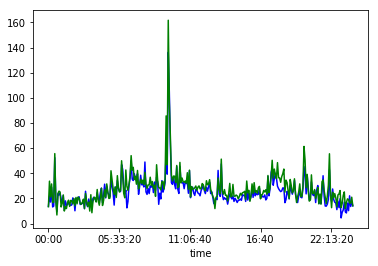

In [107]:
# going back to analyzing performance 0th, 1st, 2nd... cluster


n = 10
multi_PE_array = np.empty(n)
multi_R2_array = np.empty(n)
ks = []

clusters_R2 = {}

discarded_sizes = []

for i in range(n):
    multi_PE_list = []
    multi_R2_list = []
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        k = 0
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            R2 = result.rsquared
            multi_R2_list.append(R2)
            rs.append(R2)
            if k not in clusters_R2.keys():
                clusters_R2[k] = []
                clusters_R2[k].append(R2)
            else:
                clusters_R2[k].append(R2) 
                
            if result.rsquared < 0.5:
                discarded_sizes.append(cluster.index.size)
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
            k += 1

        multi_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())
        ks.append(k)
        
                 
        if i==1 and j==1:
            plt.plot(test_data.index, test_data['LMP_RT'],'blue')
            plt.plot(test_data.index, test_data['fitted RT (multi)'],'green')


    print('{}%'.format(10*i))

    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()


print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(multi_PE_array.mean(),multi_R2_array.mean()))
print('\tMean # of clusters: {}'.format(np.array(ks).mean()))
r = means_dict(clusters_R2)
r[0],r[1]

In [109]:
_ = plt.hist(np.array(discarded_sizes))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multiple clusters:
	MAPE: 12.762105818456051;
	Mean R^2: 0.8770526915125391;
	Mean # of clusters: 6.175


({0: 12.011819953202613,
  1: 14.634621573480523,
  2: 14.089045074593855,
  3: 13.963043026873939,
  4: 12.658619876084112,
  5: 11.135016007949275,
  6: 9.837881031873815,
  7: 9.035508326655618,
  8: 11.819855384035089},
 12.131712250527649)

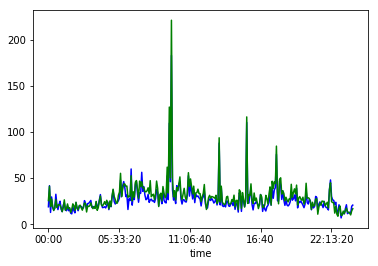

In [109]:
# going back to analyzing performance 0th, 1st, 2nd... cluster
# but now, look at each MAPE


n = 10
multi_PE_array = np.empty(n)
multi_R2_array = np.empty(n)
ks = []

clusters_R2 = {}

discarded_sizes = []

for i in range(n):
    multi_PE_list = []
    multi_R2_list = []
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        k = 0
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            multi_R2_list.append(result.rsquared)
            if result.rsquared < 0.5:
                discarded_sizes.append(cluster.index.size)
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
                PE = offset(test_data['fitted RT (multi)'].loc[hour], test_data['LMP_RT'].loc[hour])
                if k not in clusters_R2.keys():
                    clusters_R2[k] = []
                    clusters_R2[k].append(PE)
                else:
                    clusters_R2[k].append(PE)
            k += 1

        multi_PE_list.append(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())
        ks.append(k)
        
                 
        if i==1 and j==1:
            plt.plot(test_data.index, test_data['LMP_RT'],'blue')
            plt.plot(test_data.index, test_data['fitted RT (multi)'],'green')


    print('{}%'.format(10*i))

    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()


print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(multi_PE_array.mean(),multi_R2_array.mean()))
print('\tMean # of clusters: {}'.format(np.array(ks).mean()))
r = means_dict(clusters_R2)
r[0],r[1]

In [ ]:
# last test showed that 0th cluster does not necessarily perform worse
# but it is still clear that some abnormalities occur

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


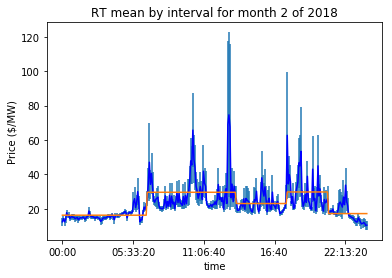

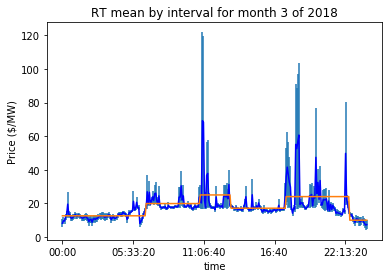

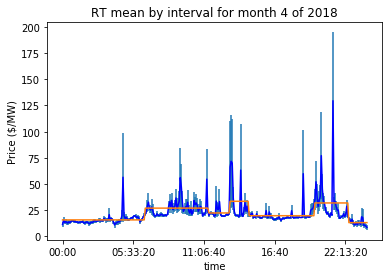

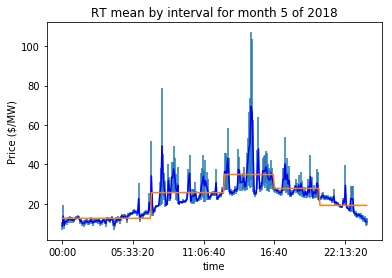

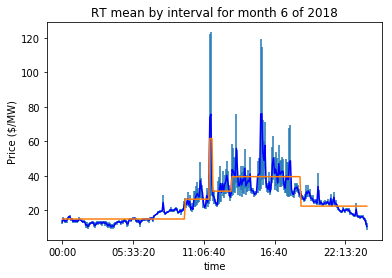

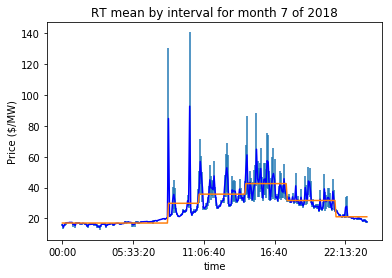

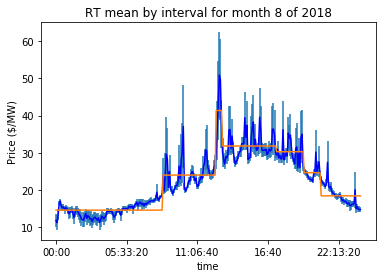

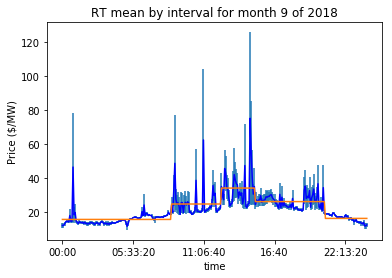

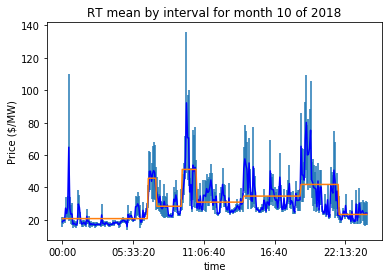

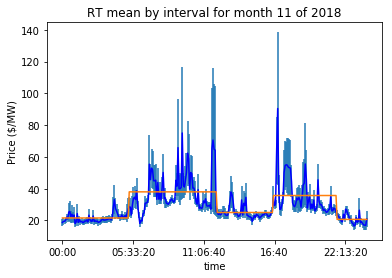

In [113]:
# 5-min clustering -- closer look

for n in range(1,13):
    by_month = DART_gen_2018[DART_gen_2018['Month']==float(n)]
    
    data = by_month.groupby('Local Time')[['LMP_RT','LMP_DA']].mean()
    data['sem_RT'] = by_month.groupby('Local Time')[['LMP_RT']].sem()
    data['sem_DA'] = by_month.groupby('Local Time')[['LMP_DA']].sem()    
    time = data.index
    
    fig, ax1 = plt.subplots()
    ax1.plot(time, data['LMP_RT'], 'blue')
    ax1.errorbar(time, data['LMP_RT'], data['sem_RT'], fmt='none')
    
    cl = []
    unnest(ssr_split4(data, 'LMP_RT'), cl)
    cl_plot = unnested_df(cl)
    plt.plot(cl_plot.index,cl_plot['Means'])
        
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by interval for month {} of 2018'.format(n))
    plt.show()

19.15589060506999


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


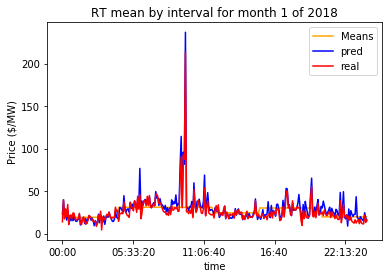

16.8881007255129


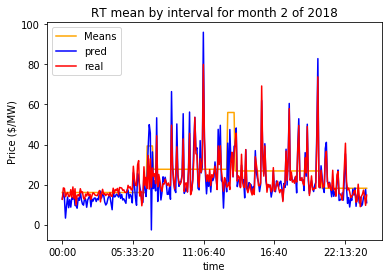

15.832195538915443


16.658591291986298


12.658081489478603


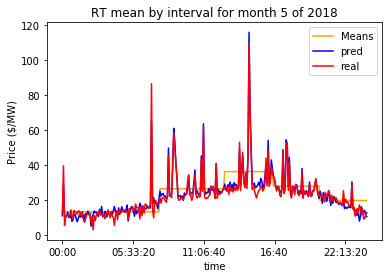

12.484598779515542


6.2766489577771


14.239904376052827


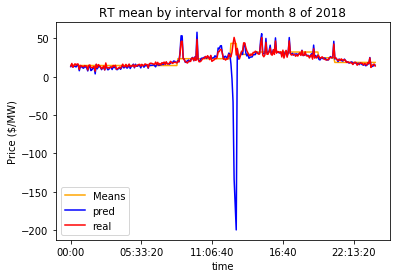

15.25143648920519


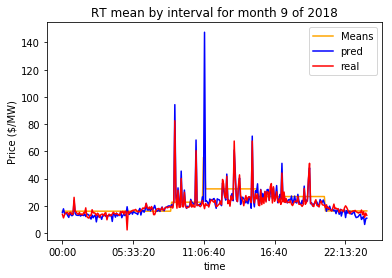

15.166658910573979


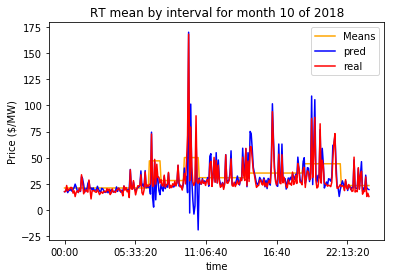

10.269140350212647


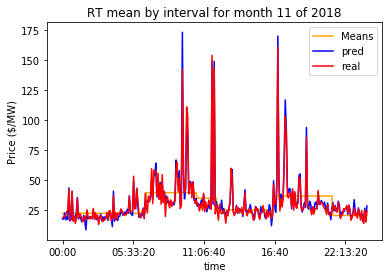

12.480816789829781


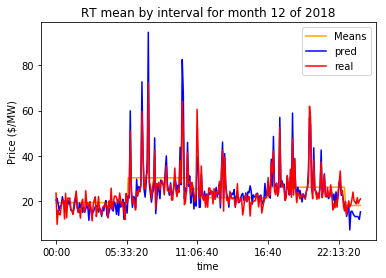

In [117]:
for j in range(1,13):
    by_month = DART_gen_2018[DART_gen_2018['Month']==j]

    train, test = train_test_split(by_month, test_size=0.33)

    train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
    train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
    train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

    test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
    test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
    test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

    size = test_data.index.shape[0]
    test_data['fitted RT (multi)'] = np.zeros(size)            
    cl = []
    unnest(ssr_split4(train_data, 'LMP_RT'), cl)
    for cluster in cl:
        result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
        for hour in cluster.index:
            test_data['fitted RT (multi)'].loc[hour] = (
                                        test_data['Wind'].loc[hour]*result.params[5] + 
                                        test_data['Load'].loc[hour]*result.params[4] + 
                                        test_data['DA_sem'].loc[hour]*result.params[3] + 
                                        test_data['RT_sem'].loc[hour]*result.params[2] + 
                                        test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                        result.params[0])
            
    print(offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean())
    cl_plot = unnested_df(cl)
    plt.plot(cl_plot.index,cl_plot['Means'],'orange')
    plt.plot(test_data.index, test_data['fitted RT (multi)'],'blue',label='pred')
    plt.plot(test_data.index, test_data['LMP_RT'],'red',label='real')
    plt.legend()
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by interval for month {} of 2018'.format(j))
    plt.show()

In [ ]:
# plot R^2 vs PE
# plot R^2 adj vs PE

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multiple clusters:
	MAPE: 13.092209219868835;
	Mean R^2: 0.8847285559532982;


Text(0.5, 0, 'R^2')

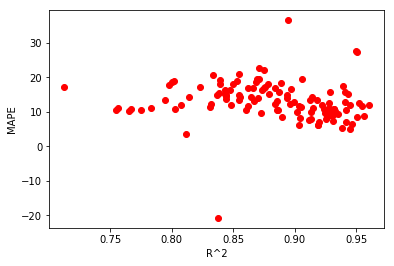

In [124]:

n = 10
multi_PE_array = np.empty(n)
multi_R2_array = np.empty(n)
all_PE = []
all_R2 = []

for i in range(n):
    multi_PE_list = []
    multi_R2_list = []
    
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (multi)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        month_R2 = []
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            R2 = result.rsquared
            multi_R2_list.append(R2)
            month_R2.append(R2)
            for hour in cluster.index:
                test_data['fitted RT (multi)'].loc[hour] = (
                                            test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
        MAPE = offset(test_data['fitted RT (multi)'], test_data['LMP_RT']).mean()
        multi_PE_list.append(MAPE)
        all_PE.append(MAPE)
        all_R2.append(np.array(month_R2).mean())

    print('{}%'.format(10*i))

    multi_PE_array[i] = np.array(multi_PE_list).mean()
    multi_R2_array[i] = np.array(multi_R2_list).mean()


print('multiple clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(multi_PE_array.mean(),multi_R2_array.mean()))
plt.plot(np.array(all_R2), np.array(all_PE), 'ro')
plt.ylabel('MAPE')
plt.xlabel('R^2')

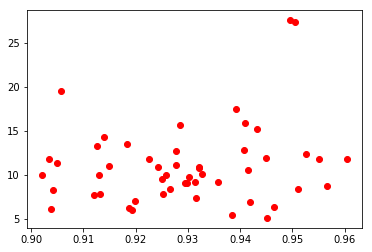

In [129]:
R2_MAPE = pd.DataFrame({'R2':np.array(all_R2),
                       'MAPE':np.array(all_PE)})
plt.plot(R2_MAPE[R2_MAPE['R2']>0.900]['R2'], R2_MAPE[R2_MAPE['R2']>0.900]['MAPE'], 'ro')

In [130]:
R2_MAPE[R2_MAPE['R2']>0.900]['MAPE'].mean()

11.03236860306918

In [132]:
# test based on recent conclusions:
# 5 predictors, do not eliminate R^2 for now, evaluate mean of two methods


n = 10
multi_array = np.empty(n)
average_array = np.empty(n)
single_array = np.empty(n)
errors = 0
check_list = []
changes_array = np.empty(n)
best_array = np.empty(n)
for i in range(n):
    multi_pe = []
    average_pe = []
    single_pe = []
    changes_list = []
    best_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=train_data).fit()
        test_data['fitted RT (1)'] = (test_data['Wind']*result.params[5] +
                                test_data['Load']*result.params[4] +
                                test_data['DA_sem']*result.params[3] +
                                test_data['RT_sem']*result.params[2] +
                                test_data['LMP_DA']*result.params[1] +
                                result.params[0])

        size = test_data.index.shape[0]
        k = 0
        test_data['fitted RT (2)'] = np.zeros(size)            
        test_data['fitted RT (best)'] = test_data['fitted RT (1)']

        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)

        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            for hour in cluster.index:
                test_data['fitted RT (2)'].loc[hour] = (test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
                if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                    abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                    test_data['fitted RT (best)'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                    k += 1
                else:
                    continue

        check = np.where(test_data['fitted RT (2)']==0.0,1,0).sum()
        if check > 0:
            check_list.append(check)

        test_data['fitted RT'] = (test_data['fitted RT (1)'] + test_data['fitted RT (2)'])/2

        multi_pe.append(offset(test_data['fitted RT (2)'], test_data['LMP_RT']).mean())
        average_pe.append(offset(test_data['fitted RT'], test_data['LMP_RT']).mean())
        single_pe.append(offset(test_data['fitted RT (1)'], test_data['LMP_RT']).mean())
        best_list.append(offset(test_data['fitted RT (best)'], test_data['LMP_RT']).mean())
        changes_list.append(k/size)

    print('{}%'.format(10*i))

    multi_array[i] = np.array(multi_pe).mean()
    average_array[i] = np.array(average_pe).mean()
    single_array[i] = np.array(single_pe).mean()
    changes_array[i] = np.array(changes_list).mean()
    best_array[i] = np.array(best_list).mean()


print('multi: {};\n averaged: {};\n    single: {}'.format(multi_array.mean(),average_array.mean(),single_array.mean()))
print('multiple clusters perform better {}% of times'.format(100*changes_array.mean()))
print('how many weird zeros? {}'.format(check))
print('ideally, {}'.format(best_array.mean()))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
clustered: 15.681148988092824;
 averaged: 13.7556058669111;
    total: 16.305037235062304
multiple clusters perform better 50.42534722222223% of times
how many weird zeros? 0
ideally, 10.182711584218989


In [140]:
# test based on recent conclusions:
# 5 predictors, DO eliminate R^2, evaluate mean of two methods


n = 10
multi_array = np.empty(n)
average_array = np.empty(n)
single_array = np.empty(n)
errors = 0
check_list = []
changes_array = np.empty(n)
best_array = np.empty(n)
optimize_avg_array = np.empty(n)
discarded_months = 0
for i in range(n):
    multi_pe = []
    average_pe = []
    single_pe = []
    changes_list = []
    best_list = []
    optimize_avg_list = []
    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        result1 = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=train_data).fit()
        test_data['fitted RT (1)'] = (test_data['Wind']*result1.params[5] +
                                test_data['Load']*result1.params[4] +
                                test_data['DA_sem']*result1.params[3] +
                                test_data['RT_sem']*result1.params[2] +
                                test_data['LMP_DA']*result1.params[1] +
                                result1.params[0])

        size = test_data.index.shape[0]
        k = 0
        test_data['fitted RT (2)'] = np.zeros(size)            
        test_data['fitted RT (best)'] = test_data['fitted RT (1)']

        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        month_R2 = []
        
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            month_R2.append(result.rsquared)
            for hour in cluster.index:
                test_data['fitted RT (2)'].loc[hour] = (test_data['Wind'].loc[hour]*result.params[5] + 
                                            test_data['Load'].loc[hour]*result.params[4] + 
                                            test_data['DA_sem'].loc[hour]*result.params[3] + 
                                            test_data['RT_sem'].loc[hour]*result.params[2] + 
                                            test_data['LMP_DA'].loc[hour]*result.params[1] + 
                                            result.params[0])
                if (abs(test_data['fitted RT (2)'].loc[hour] - test_data['LMP_RT'].loc[hour]) < 
                    abs(test_data['fitted RT (1)'].loc[hour] - test_data['LMP_RT'].loc[hour])):
                    test_data['fitted RT (best)'].loc[hour] = test_data['fitted RT (2)'].loc[hour]
                    k += 1
                else:
                    continue

        check = np.where(test_data['fitted RT (2)']==0.0,1,0).sum()
        if check > 0:
            check_list.append(check)

        test_data['fitted RT'] = (test_data['fitted RT (1)'] + test_data['fitted RT (2)'])/2

        multi_pe.append(offset(test_data['fitted RT (2)'], test_data['LMP_RT']).mean())
        average_pe.append(offset(test_data['fitted RT'], test_data['LMP_RT']).mean())
        single_pe.append(offset(test_data['fitted RT (1)'], test_data['LMP_RT']).mean())
        best_list.append(offset(test_data['fitted RT (best)'], test_data['LMP_RT']).mean())
        changes_list.append(k/size)
        
        if result1.rsquared > 0.9 and np.array(month_R2).mean() > 0.9:
            test_data['fitted RT (optimized)'] = (test_data['fitted RT (1)'] + test_data['fitted RT (2)'])/2
            optimize_avg_list.append(offset(test_data['fitted RT (optimized)'], test_data['LMP_RT']).mean())
        else:
            discarded_months += 1

    print('{}%'.format(10*i))

    multi_array[i] = np.array(multi_pe).mean()
    average_array[i] = np.array(average_pe).mean()
    single_array[i] = np.array(single_pe).mean()
    changes_array[i] = np.array(changes_list).mean()
    best_array[i] = np.array(best_list).mean()
    optimize_avg_array[i] = np.array(optimize_avg_list).mean()


print('multi: {};\n averaged: {};\n    single: {}'.format(multi_array.mean(),average_array.mean(),single_array.mean()))
print('multiple clusters perform better {}% of times'.format(100*changes_array.mean()))
print('how many weird zeros? {}'.format(check))
print('ideally, {}'.format(best_array.mean()))
print('only using R^2 > 0.9: MAPE = {}'.format(optimize_avg_array.mean()))

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
multi: 14.338651302173963;
 averaged: 13.107573002327143;
    single: 14.182368993390629
multiple clusters perform better 49.97106481481481% of times
how many weird zeros? 0
ideally, 9.414625222941954
only using R^2 > 0.9: MAPE = 9.594925961239628


In [141]:
optimize_avg_array

array([ 9.98583826,  8.49340894,  9.45709855, 10.90722096,  7.65790469,
       10.20305763,  9.30668753, 12.19484808,  9.11908608,  8.62410889])

In [144]:
discarded_months/120

0.625

In [ ]:
# ~10% MAPE for R^2 > 0.9

In [146]:
# Reading curtailment dataset

path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\Curtailment\2018'
curtail_path = 'VER-Curtailments-2018'
end = '.csv'
dfs = []
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}
for key in cal_dict.keys():
    for value in cal_dict[key]:
        day_df = pd.read_csv(path+'\\'+key+'\\'+curtail_path+key+value+end)
        dfs.append(day_df)
curt = pd.concat(dfs,ignore_index=True)
curt.tail()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



GMTINTERVALENDING           GMTIntervalEnding LOCALINTERVALENDING  \
105115               NaN  01/01/2019 05:40:00.000000                 NaN   
105116               NaN  01/01/2019 05:45:00.000000                 NaN   
105117               NaN  01/01/2019 05:50:00.000000                 NaN   
105118               NaN  01/01/2019 05:55:00.000000                 NaN   
105119               NaN  01/01/2019 06:00:00.000000                 NaN   

               LocalIntervalEnding  WINDCURTAILEDFORENERGY  \
105115  12/31/2018 23:40:00.000000                     NaN   
105116  12/31/2018 23:45:00.000000                     NaN   
105117  12/31/2018 23:50:00.000000                     NaN   
105118  12/31/2018 23:55:00.000000                     NaN   
105119  01/01/2019 00:00:00.000000                     NaN   

        WINDMANUALCURTAILMENTS  WINDREDISPATCHCURTAILMENTS  \
105115                     NaN                         NaN   
105116                     NaN                         NaN   
105117                     NaN                         NaN   
105118                     NaN                         NaN   
105119                     NaN                         NaN   

        WindManualCurtailments  WindRedispatchCurtailments  
105115                     0.0                      640.68  
105116                     0.0                      545.50  
105117                     0.0                      538.91  
105118                     0.0                      547.44  
105119                     0.0                      615.87

In [154]:
# converting datetime to float
minutes = []
for time in train_data.index:
    minutes.append(time.hour * 60 + time.minute)
train_data['minutes'] = np.array(minutes)
minutes = []
for time in test_data.index:
    minutes.append(time.hour * 60 + time.minute)
test_data['minutes'] = np.array(minutes)

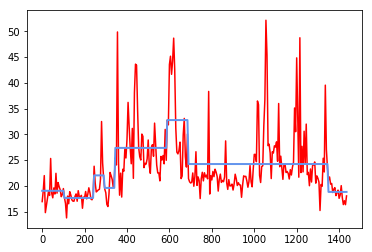

In [162]:
# testing existing module

X = train_data['minutes'].values.reshape(-1,1)
y = train_data['LMP_RT']

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=3)
regr_1.fit(X, y)

# Predict
X_test = test_data['minutes'].values.reshape(-1,1)
y_1 = regr_1.predict(X_test)

# Plot the results
plt.figure()
plt.plot(X, y, "red")
plt.plot(X_test, y_1, color="cornflowerblue",label="max_depth=2", linewidth=2)

In [168]:
test_data['sklearn cluster'] = y_1
price_leaves = []
for price in y_1:
    if price not in price_leaves:
        price_leaves.append(price)
branch_dfs = []
for price in price_leaves:
    branch_dfs.append(test_data[test_data['sklearn cluster']==price])

In [181]:
# system-wide, 5 predictors
# multi or single clustered -- comparings R^2

n = 1
custom_PE_array = np.empty(n)
custom_R2_array = np.empty(n)
sklearn_PE_array = np.empty(n)
sklearn_R2_array = np.empty(n)

for i in range(n):
    custom_PE_list = []
    custom_R2_list = []
    sklearn_PE_list = []
    sklearn_R2_list = []

    for j in range(1,13):
        by_month = DART_gen_2018[DART_gen_2018['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        train_data['RT_sem'] = train.groupby('Local Time')['LMP_RT'].sem()
        train_data['DA_sem'] = train.groupby('Local Time')['LMP_DA'].sem()        

        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind']].mean()
        test_data['RT_sem'] = test.groupby('Local Time')['LMP_RT'].sem()
        test_data['DA_sem'] = test.groupby('Local Time')['LMP_DA'].sem() 

        size = test_data.index.shape[0]
        test_data['fitted RT (custom)'] = np.zeros(size)            
        cl = []
        unnest(ssr_split4(train_data, 'LMP_RT'), cl)
        
        test_data_copy = test_data.copy()
        
        for cluster in cl:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            custom_R2_list.append(result.rsquared)
            for hour in cluster.index:
                test_data['fitted RT (custom)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour].copy()*result.params[5] + 
                                            test_data_copy['Load'].loc[hour].copy()*result.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour].copy()*result.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour].copy()*result.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour].copy()*result.params[1] + 
                                            result.params[0])

        custom_PE_list.append(offset(test_data['fitted RT (custom)'], test_data['LMP_RT']).mean())
        

        # converting datetime to float
        minutes = []
        for time in train_data.index:
            minutes.append(time.hour * 60 + time.minute)
        train_data['minutes'] = np.array(minutes)
        minutes = []
        for time in test_data.index:
            minutes.append(time.hour * 60 + time.minute)
        test_data['minutes'] = np.array(minutes)
        # testing existing module
        X = train_data['minutes'].values.reshape(-1,1)
        y = train_data['LMP_RT']
        # Fit regression model
        regr_1 = DecisionTreeRegressor(max_depth=3)
        regr_1.fit(X, y)
        # Predict
        X_test = test_data['minutes'].values.reshape(-1,1)
        y_1 = regr_1.predict(X_test)
        test_data['sklearn cluster'] = y_1
        price_leaves = []
        for price in y_1:
            if price not in price_leaves:
                price_leaves.append(price)
        branch_dfs = []
        for price in price_leaves:
            branch_dfs.append(test_data[test_data['sklearn cluster']==price])
        size = test_data.index.shape[0]
        test_data['fitted RT (sklearn)'] = np.zeros(size) 
        for cluster in branch_dfs:
            result = smf.ols(formula="LMP_RT ~ LMP_DA + RT_sem + DA_sem + Load + Wind", data=cluster).fit()
            sklearn_R2_list.append(result.rsquared)
            for hour in cluster.index:
                test_data['fitted RT (sklearn)'].loc[hour] = ( 
                                            test_data_copy['Wind'].loc[hour].copy()*result.params[5] + 
                                            test_data_copy['Load'].loc[hour].copy()*result.params[4] + 
                                            test_data_copy['DA_sem'].loc[hour].copy()*result.params[3] + 
                                            test_data_copy['RT_sem'].loc[hour].copy()*result.params[2] + 
                                            test_data_copy['LMP_DA'].loc[hour].copy()*result.params[1] + 
                                            result.params[0])

        sklearn_PE_list.append(offset(test_data['fitted RT (sklearn)'], test_data['LMP_RT']).mean())
            
    print('{}%'.format(10*i))

    custom_PE_array[i] = np.array(custom_PE_list).mean()
    custom_R2_array[i] = np.array(custom_R2_list).mean()
    sklearn_PE_array[i] = np.array(sklearn_PE_list).mean()
    sklearn_R2_array[i] = np.array(sklearn_R2_list).mean()


print('custom cluster:\n\tMAPE: {};\n\tMean R^2: {};'.format(custom_PE_array.mean(),custom_R2_array.mean()))
print('sklearn clusters:\n\tMAPE: {};\n\tMean R^2: {};'.format(sklearn_PE_array.mean(),sklearn_R2_array.mean()))

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodel

0%
custom cluster:
	MAPE: 13.193863214813119;
	Mean R^2: 0.8842343956635665;
sklearn clusters:
	MAPE: 7.332713918830554;
	Mean R^2: nan;


In [ ]:
# still need to fix warnings

In [178]:
sklearn_PE_list

[9.240137615371195,
 7.559208191322731,
 7.750591383004429,
 9.890188069736805,
 6.496607274410527,
 4.862079825619357,
 3.9486168924869087,
 4.696354333118385,
 6.5142236796562125,
 7.5455242448290205,
 8.989631481080524,
 6.799119896097054]